In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Env
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine
import psycopg2
import sqlite3

# Basics
import datetime as dt
import pickle
import json
import gzip

# Plots, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Control
from tqdm import tqdm
import time
from multiprocessing import Pool, cpu_count

# FB Prophet
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.serialize import model_to_json, model_from_json

from fixprophet.fixserialize import fix_model_from_json, fix_model_from_dict
#import fixserialize
#from fixprophet.fixserialize 

#import tensorflow as tf
#from tensorflow.keras import models, layers, optimizers, metrics
#from tensorflow.keras.layers.experimental.preprocessing import Normalization

In [3]:
sns.set()

# Get the Data
___

## Load the Data

In [4]:
REMOTE = False

### Remote data load

In [ ]:
# Set postgres credentials
load_dotenv()
user = os.getenv('DB_USER')
password = os.getenv('DB_PASSWORD')
host = os.getenv('DB_HOST')
port = os.getenv('DB_PORT')
db = os.getenv('DB')

In [ ]:
# A long string that contains the necessary Postgres login information
postgres_str = ('postgresql://{username}:{password}@{ipaddress}:{port}/{dbname}'
                .format(username=user,
                        password=password,
                        ipaddress=host,
                        port=port,
                        dbname=db))
cnx = create_engine(postgres_str)

In [ ]:
# List DB tables
conn = psycopg2.connect(postgres_str)
cursor = conn.cursor()
cursor.execute("""SELECT relname FROM pg_class WHERE relkind='r'
                  AND relname !~ '^(pg_|sql_)';""") # "rel" is short for relation.

tables_list = [i[0] for i in cursor.fetchall()] # A list() of tables.
#check available tables
tables_list

In [ ]:
# Load datasets
if REMOTE:
    shops_df = pd.read_sql_query('''SELECT * FROM shops_en;''', cnx)
    item_categories_df = pd.read_sql_query('''SELECT * FROM item_categories_en;''', cnx)
    test_df = pd.read_sql_query('''SELECT * FROM test;''', cnx)
    sales_train_df = pd.read_sql_query('''SELECT * FROM sales_train;''', cnx)
    items_df = pd.read_sql_query('''SELECT * FROM items_en;''', cnx)
    cleaning_store_df = pd.read_sql_query('''SELECT * FROM cleaning_store_id;''', cnx)
    cleaning_item_category_df = pd.read_sql_query('''SELECT * FROM cleaning_item_category_id;''', cnx)

#### Preprocessing for RNN

In [ ]:
# Merge with categories to get the Ids
sales_train_df = pd.merge(sales_train_df, items_df, left_on='item_id', right_on='item_id', how='left')

# Merge with cleaning_item_category_df to get the status of active and non active categories
sales_train_df = pd.merge(sales_train_df, cleaning_item_category_df, left_on='item_category_id', right_on='item_category_id', how='left')

# Merge with cleaning_store_df to get the status of active and non active shops
sales_train_df = pd.merge(sales_train_df, cleaning_store_df, left_on='shop_id', right_on='shop_id', how='left')

# Drop column that contais the items name, category status name, and shop status name
sales_train_df.drop(labels=['item_name', 'category_status','shop_status'], axis=1, inplace=True)

# Set date to YYYY/mm/dd
sales_train_df['date'] = pd.to_datetime(sales_train_df['date'], format='%d.%m.%Y')

# Set property dtypes for all other columns
sales_train_df = sales_train_df.astype({'date_block_num':'Int32',
                                        'shop_id':'Int32',
                                        'item_id':'Int32',
                                        'item_price':'float32',
                                        'item_cnt_day':'Int32',
                                        'item_category_id':'Int32',
                                        'category_status_code':'Int32',
                                        'shop_status_code':'Int32'})

# Set a new DataFrame to work with models
sales_train_clean_df = sales_train_df.copy()

# Filter only active categories and stores
sales_train_clean_df = sales_train_clean_df.query('category_status_code == 1').query('shop_status_code == 1')

# Drop category_status_code and shop_status_code to lightweight the dataframe
sales_train_clean_df.drop(labels=['category_status_code', 'shop_status_code'], axis=1, inplace=True)

# Drop duplicates, just in case
sales_train_clean_df.drop_duplicates(inplace=True)

### Local data Load

In [5]:
path = "../raw_data/"

In [6]:
# local data
os.path.join(path, "item_categories.csv")

'../raw_data/item_categories.csv'

In [7]:
REMOTE

False

In [8]:
if not REMOTE:
    categories_ = pd.read_csv(os.path.join(path, "item_categories.csv"))
    items_ = pd.read_csv(os.path.join(path, "items.csv"))
    sales_ = pd.read_csv(os.path.join(path, "sales_train.csv"))
    shops_ = pd.read_csv(os.path.join(path, "shops.csv"))
    test_ = pd.read_csv(os.path.join(path, "test.csv"))
    sample_ = pd.read_csv(os.path.join(path, "sample_submission.csv"))
elif REMOTE:
    categories_ = item_categories_df.copy()
    items_ = items_df.copy()
    sales_ = sales_train_df.copy()
    shops_ = shops_df.copy()
    test_ = test_df.copy()
    sample_ = pd.DataFrame()

In [9]:
categories_local_df = categories_.copy()
items_local_df = items_.copy()
shops_local_df = shops_.copy()
sales_local_df = sales_.copy()
test_local_df = test_.copy()
sample_local_df = sample_.copy()

#### Merge and Clean the Data

In [10]:
# column type to datetime
sales_local_df["date"] = pd.to_datetime(sales_local_df.date, dayfirst=True)

# rename item_category_id to cat_id
categories_local_df.rename(columns={'item_category_id': 'cat_id'}, inplace=True)
items_local_df.rename(columns={'item_category_id': 'cat_id'}, inplace=True)
sales_local_df.rename(columns={'item_category_id': 'cat_id'}, inplace=True)

# merge test_local_df with item_df on item_id
test_local_df = test_local_df.merge(items_local_df[['item_id', 'cat_id']], how='left', on='item_id')

# merge items_local_df with sales_local_df on item_id
sales_local_df = sales_local_df.merge(items_local_df[['item_id', 'cat_id']], on='item_id')

# chage types
sales_local_df['item_cnt_day'] = sales_local_df['item_cnt_day'].astype('int32')
sales_local_df['date_block_num'] = sales_local_df['date_block_num'].astype('int32')
sales_local_df['shop_id'] = sales_local_df['shop_id'].astype('int32')
sales_local_df['item_id'] = sales_local_df['item_id'].astype('int32')
sales_local_df['cat_id'] = sales_local_df['cat_id'].astype('int32')
sales_local_df['item_price'] = sales_local_df['item_price'].astype('float32')

# create final price column and remove negative values
sales_local_df['final_price'] = sales_local_df.item_cnt_day * sales_local_df.item_price
sales_local_df['final_price'] = sales_local_df['final_price'].astype('float32')
sales_local_df.loc[sales_local_df['final_price'] < 0, ['final_price']] = 0

# sort by date
sales_local_df.sort_values("date", inplace=True)

In [16]:
# Run this to make all data Clean
sales_local_df = sales_local_df[
    sales_local_df['shop_id'].isin(unique_shops)
    & sales_local_df['cat_id'].isin(unique_cats)
    & sales_local_df['item_id'].isin(unique_item)
]

categories_local_df = categories_local_df[
    categories_local_df['cat_id'].isin(unique_cats)
]


shops_local_df = shops_local_df[
    shops_local_df['shop_id'].isin(unique_shops)
]

items_local_df = items_local_df[
    items_local_df['item_id'].isin(unique_item)
]

## Look at the Data

In [18]:
sales_local_df

date  date_block_num  shop_id  item_id   item_price  \
1005087 2013-01-01               0       14    15438   599.000000   
128444  2013-01-01               0       41     1523   799.000000   
128357  2013-01-01               0       28     1523   799.000000   
128396  2013-01-01               0       14     1523   799.000000   
760355  2013-01-01               0       15     8685   199.000000   
...            ...             ...      ...      ...          ...   
1788495 2015-10-31              33       58     3734  3399.000000   
2715396 2015-10-31              33       58    17748   288.149994   
1502745 2015-10-31              33       26    20949     5.000000   
2931438 2015-10-31              33       46     7223  3999.000000   
2922155 2015-10-31              33       31     3352  2999.000000   

         item_cnt_day  cat_id  final_price  
1005087             1      63   599.000000  
128444              1      21   799.000000  
128357              1      21   799.000000  
128396              1      21   799.000000  
760355              1      55   199.000000  
...               ...     ...          ...  
1788495             1      23  3399.000000  
2715396             1      70   288.149994  
1502745             3      71    15.000000  
2931438             1      20  3999.000000  
2922155             1      23  2999.000000  

[1224439 rows x 8 columns]

In [19]:
sales_local_df.dtypes

date              datetime64[ns]
date_block_num             int32
shop_id                    int32
item_id                    int32
item_price               float32
item_cnt_day               int32
cat_id                     int32
final_price              float32
dtype: object

In [20]:
sales_local_df.describe()

date_block_num       shop_id       item_id    item_price  item_cnt_day  \
count    1.224439e+06  1.224439e+06  1.224439e+06  1.224439e+06  1.224439e+06   
mean     1.935472e+01  3.215117e+01  9.614866e+03  1.030666e+03  1.321234e+00   
std      9.110722e+00  1.646562e+01  6.299870e+03  1.827384e+03  3.312997e+00   
min      0.000000e+00  2.000000e+00  3.000000e+01  5.000000e-01 -1.600000e+01   
25%      1.200000e+01  1.900000e+01  4.181000e+03  2.990000e+02  1.000000e+00   
50%      2.100000e+01  3.100000e+01  7.856000e+03  5.490000e+02  1.000000e+00   
75%      2.700000e+01  4.600000e+01  1.522900e+04  1.199000e+03  1.000000e+00   
max      3.300000e+01  5.900000e+01  2.216700e+04  5.920000e+04  2.169000e+03   

             cat_id   final_price  
count  1.224439e+06  1.224439e+06  
mean   4.055878e+01  1.406299e+03  
std    1.860682e+01  7.241286e+03  
min    2.000000e+00  0.000000e+00  
25%    2.500000e+01  2.990000e+02  
50%    3.800000e+01  5.990000e+02  
75%    5.500000e+01  1.398000e+03  
max    8.300000e+01  1.829990e+06

In [21]:
print(
    f"Shop id Shape: {shops_local_df.shape}",
    f"Categories id Shape: {categories_local_df.shape}",
    f"Items id Shape: {items_local_df.shape}",
    f"Test Shape: {test_local_df.shape}",
    sep="\n"
)

Shop id Shape: (42, 2)
Categories id Shape: (62, 2)
Items id Shape: (5100, 3)
Test Shape: (214200, 4)


## First time run parameter

In [22]:
# Frequency analysis in days
# d: days
# w: weeks
# m: months
freq_analysis = 'm'

# Load the models from local directory
LOADED = True
SAVED = False
PATH_MODELS = '../raw_data/prophet'

In [23]:
# Saved files names:
# Print models name im PATH directory
"""
group by shop:
 - prophet_shops_id_sales_model.gz
 - prophet_shops_id_sales_forecast.gz
 - prophet_shops_id_sales_train.gz
 - prophet_shops_id_sales_horizon.pkl

 - prophet_shops_id_values_model.gz
 - prophet_shops_id_values_forecast.gz
 - prophet_shops_id_values_train.gz
 - prophet_shops_id_values_horizon.pkl
 
Group by Categoory:
 - prophet_cats_id_sales.json
 - prophet_cats_id_values.json
"""

! ls ../raw_data/prophet

cat_pred.csv				 prophet_cats_shops_id_sales_train.gz
cats_shops_pred.csv			 prophet_items_id_sales_forecast.gz
final.csv				 prophet_items_id_sales_horizon.pkl
items_pred.csv				 prophet_items_id_sales_model.gz
prophet_cats_id_sales_forecast.gz	 prophet_items_id_sales_train.gz
prophet_cats_id_sales_horizon.pkl	 prophet_shops_id_sales_forecast.gz
prophet_cats_id_sales_model.gz		 prophet_shops_id_sales_horizon.pkl
prophet_cats_id_sales_test.gz		 prophet_shops_id_sales_model.gz
prophet_cats_id_sales_train.gz		 prophet_shops_id_sales_test.gz
prophet_cats_id_values_forecast.gz	 prophet_shops_id_sales_train.gz
prophet_cats_id_values_horizon.pkl	 prophet_shops_id_values_forecast.gz
prophet_cats_id_values_model.gz		 prophet_shops_id_values_horizon.pkl
prophet_cats_id_values_test.gz		 prophet_shops_id_values_model.gz
prophet_cats_id_values_train.gz		 prophet_shops_id_values_test.gz
prophet_cats_shops_id_sales_forecast.gz  prophet_shops_id_values_train.gz
prophet_cats_shops_id_sales_horizon.pkl

## Helper Functions

### Sort and Plot

In [24]:
def new_sort(df_type, feature):
    df_id = pd.pivot_table(
        sales_local_df, values=feature,
        index=df_type, columns=['date'],
        aggfunc=np.sum 
    )
    return df_id.fillna(0).T

In [25]:
# sort the Data Frame by "types" to be used in the analysis
def sort_sales(df: pd.core.frame.DataFrame, name: str, feature: str) -> pd.core.frame.DataFrame:
    """
    Sort the Data Frame by "type(name)" to be used in the analysis.
    df: Data Frame.
    name: shop, cat, item.
    feature: item_cnt_day, final_price.
    """
    
    df_feature = pd.DataFrame()

    for id in range(df.shape[0]):
        name_id = f'{name}_id_{id}'
        df = sales_local_df[sales_local_df[f'{name}_id'] == id]
        df = df.resample(freq_analysis, on='date').sum()[[feature]]
        df.rename(columns = {feature:name_id}, inplace=True)
        df_feature = pd.concat([df_feature, df], axis=1)

    return df_feature

In [26]:
# bar plot function
def bar_plot_func(df: pd.core.frame.DataFrame, xlabel="", ylabel="", start=0) -> None:
    """
    Bar plot the data.
    data: dictionary with the values.
    """
    df = df.sum().sort_values(ascending=False)
    df = df.iloc[start:80+start]
    plt.figure(figsize=(12, 5))
    sns.barplot(x=df.index, y=df.values, order=df.index)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tick_params(axis='x', labelsize=6, rotation=90)
    plt.tick_params(axis='y', labelsize=10)
    plt.show()

In [27]:
# line plot function
def line_plot_func(df: pd.core.frame.DataFrame, number=2, sample: list=[], ylabel="") -> None:
    """
    Line plot the data.
    df: data frame to be ploted.
    number: number of randon samples.
    sample: a list with itens to be ploted, override number.
    """
    plt.figure(figsize=(12, 7))
    if sample:
        sns.lineplot(df.loc[:,sample])
    else:
        sns.lineplot(data=df.sample(number, axis=1))
    plt.xlabel("Date")
    plt.ylabel(ylabel)
    plt.tick_params(axis='x', labelsize=10, rotation=45)
    plt.tick_params(axis='y', labelsize=10)
    plt.legend(fontsize=10)
    plt.show()

# Sorting the Data
___

## Group by Shop

### Number of Sales (file name _shops\_sales_)

In [ ]:
# shops_sales = sort_sales(shops_local_df, "shop", "item_cnt_day")
# shops_sales.head()

In [28]:
shops_sales = new_sort("shop_id", "item_cnt_day")
shops_sales.head()

shop_id       2     3     4    5     6     7    10   12    14    15  ...   48  \
date                                                                 ...        
2013-01-01   4.0   0.0   0.0  0.0   0.0  19.0  0.0  0.0  22.0  30.0  ...  0.0   
2013-01-02  11.0  15.0  35.0  0.0  50.0  54.0  2.0  0.0  33.0  36.0  ...  0.0   
2013-01-03  20.0  13.0  25.0  0.0  44.0  27.0  4.0  0.0  36.0  42.0  ...  0.0   
2013-01-04  12.0  11.0  22.0  0.0  40.0  27.0  2.0  0.0  28.0  38.0  ...  0.0   
2013-01-05  20.0   7.0  23.0  0.0  41.0  32.0  9.0  0.0  24.0  29.0  ...  0.0   

shop_id      49    50    52    53   55    56   57   58    59  
date                                                          
2013-01-01  0.0   0.0   0.0   0.0  0.0   0.0  0.0  0.0   0.0  
2013-01-02  0.0  44.0  28.0  29.0  0.0  68.0  0.0  0.0  28.0  
2013-01-03  0.0  62.0  19.0  32.0  0.0  57.0  0.0  0.0  31.0  
2013-01-04  0.0  50.0  24.0  31.0  0.0  23.0  0.0  0.0  23.0  
2013-01-05  0.0  34.0  14.0  33.0  0.0  33.0  0.0  0.0  25.0  

[5 rows x 42 columns]

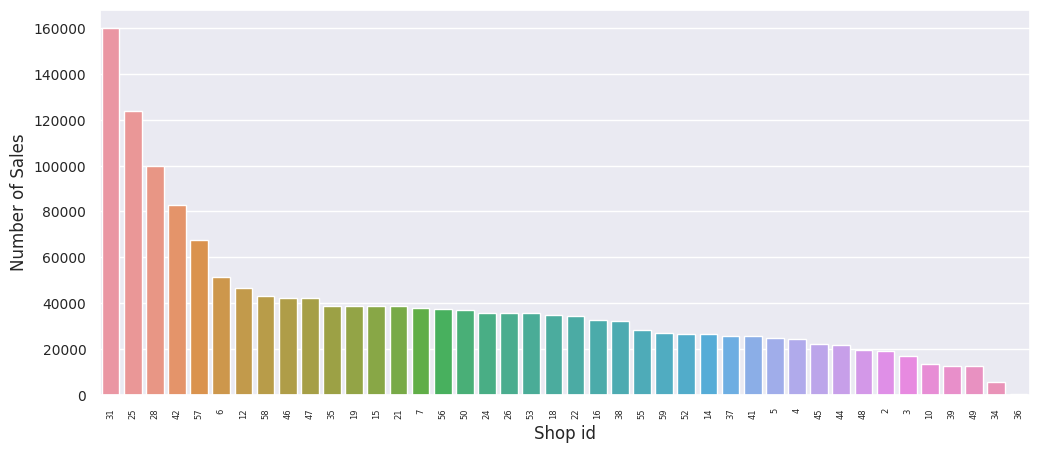

In [29]:
bar_plot_func(shops_sales, "Shop id", "Number of Sales")

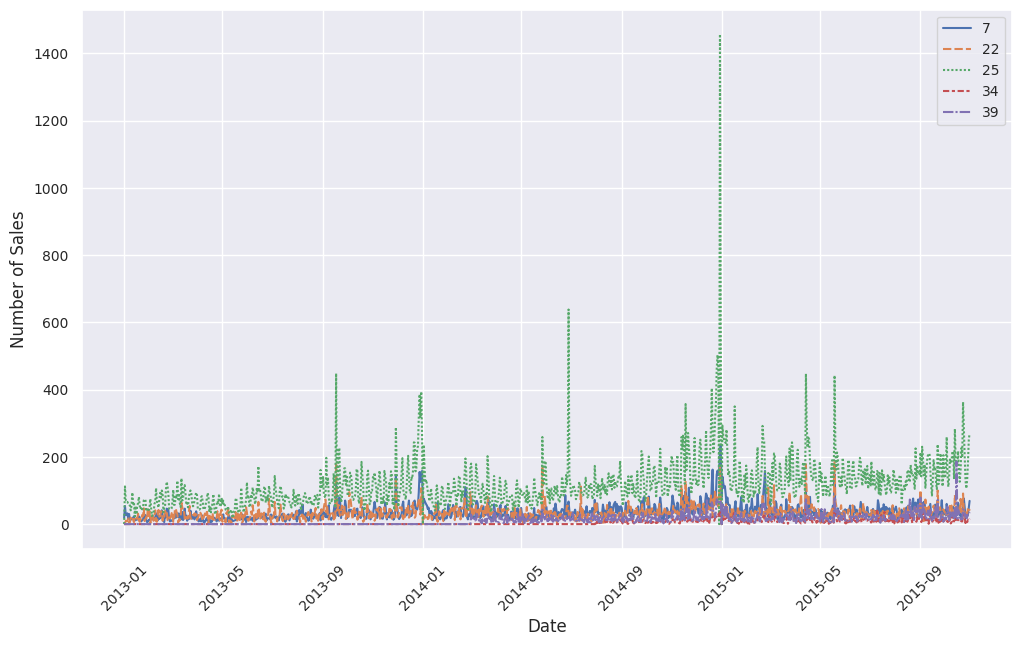

In [30]:
line_plot_func(shops_sales, number=5, ylabel="Number of Sales")

### Value of Sales (file name _shops\_values_)

In [ ]:
#shops_values = sort_sales(shops_local_df, "shop", "final_price")
#shops_values.head()

In [31]:
shops_values = new_sort("shop_id", "final_price")
shops_values.head()

shop_id               2        3             4    5        6             7   \
date                                                                          
2013-01-01   1496.000000      0.0      0.000000  0.0      0.0  13912.299805   
2013-01-02  10870.000000  10934.5  22818.500000  0.0  42157.0  37033.000000   
2013-01-03  19033.699219   7628.0  18463.500000  0.0  34273.5  17446.000000   
2013-01-04   6349.000000   6839.0  16699.000000  0.0  27621.5  20450.500000   
2013-01-05  12992.000000   4193.0  14706.700195  0.0  28818.0  25107.199219   

shop_id         10   12            14            15  ...   48   49  \
date                                                 ...             
2013-01-01     0.0  0.0  16489.000000  22442.500000  ...  0.0  0.0   
2013-01-02  1517.0  0.0  14787.000000  21177.960938  ...  0.0  0.0   
2013-01-03  4354.0  0.0  33088.300781  34864.500000  ...  0.0  0.0   
2013-01-04  1706.0  0.0  22583.000000  24531.500000  ...  0.0  0.0   
2013-01-05  3526.0  0.0  20398.000000  18861.000000  ...  0.0  0.0   

shop_id               50            52       53   55            56   57   58  \
date                                                                           
2013-01-01      0.000000      0.000000      0.0  0.0      0.000000  0.0  0.0   
2013-01-02  39378.398438  18243.000000  26992.5  0.0  37976.300781  0.0  0.0   
2013-01-03  34310.500000   8842.799805  21547.5  0.0  29665.500000  0.0  0.0   
2013-01-04  41102.500000  10746.500000  28064.0  0.0  14090.000000  0.0  0.0   
2013-01-05  31394.500000   9457.000000  27817.0  0.0  19801.550781  0.0  0.0   

shop_id               59  
date                      
2013-01-01      0.000000  
2013-01-02  19268.380859  
2013-01-03  21148.000000  
2013-01-04  16744.000000  
2013-01-05  19088.500000  

[5 rows x 42 columns]

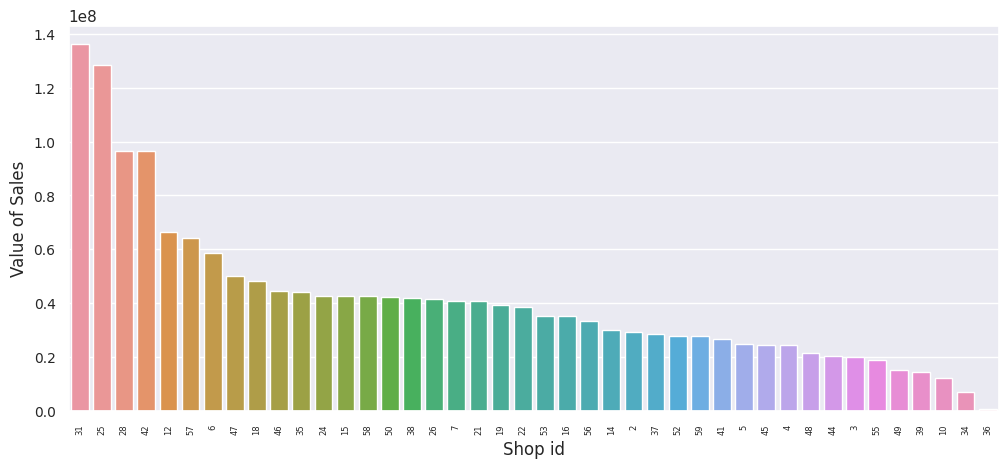

In [32]:
bar_plot_func(shops_values, "Shop id", "Value of Sales")

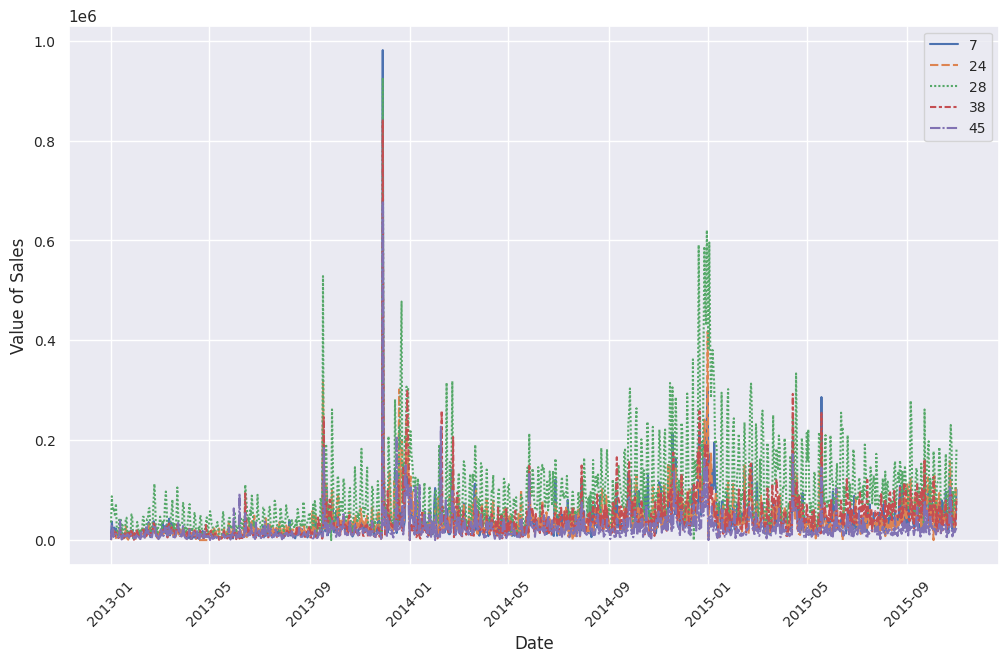

In [33]:
line_plot_func(shops_values, number=5, ylabel="Value of Sales")

## Group by Category

### Number of Sales  (file name _cats\_sales_)

In [ ]:
#cats_sales = sort_sales(categories_local_df, "cat", "item_cnt_day")
#cats_sales.head()

In [34]:
cats_sales = new_sort("cat_id", "item_cnt_day")
cats_sales.head()

cat_id        2    3     5     6    7    9    11   12   15   16  ...   71  \
date                                                             ...        
2013-01-01   4.0  0.0   4.0   3.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
2013-01-02  24.0  0.0  12.0  33.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
2013-01-03  27.0  0.0   8.0  18.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
2013-01-04  15.0  0.0   6.0  23.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
2013-01-05  15.0  0.0  12.0  18.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   

cat_id       72   73   74    75   76   77   78   79    83  
date                                                       
2013-01-01  0.0  0.0  0.0   3.0  0.0  1.0  0.0  1.0  14.0  
2013-01-02  5.0  3.0  0.0   9.0  0.0  3.0  0.0  5.0  98.0  
2013-01-03  3.0  9.0  0.0  21.0  0.0  3.0  0.0  0.0  52.0  
2013-01-04  2.0  5.0  0.0  22.0  0.0  1.0  0.0  6.0  28.0  
2013-01-05  3.0  8.0  0.0  10.0  0.0  1.0  0.0  4.0  29.0  

[5 rows x 60 columns]

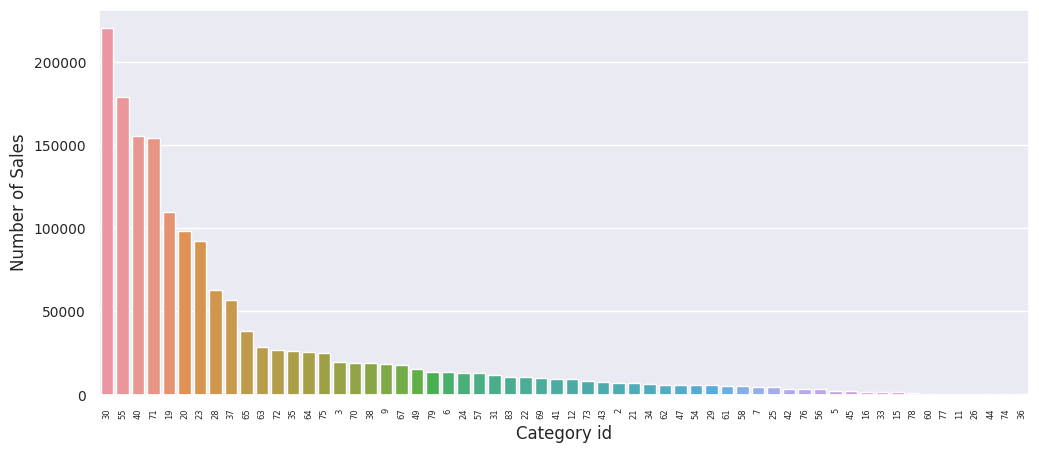

In [35]:
bar_plot_func(cats_sales, "Category id", "Number of Sales")

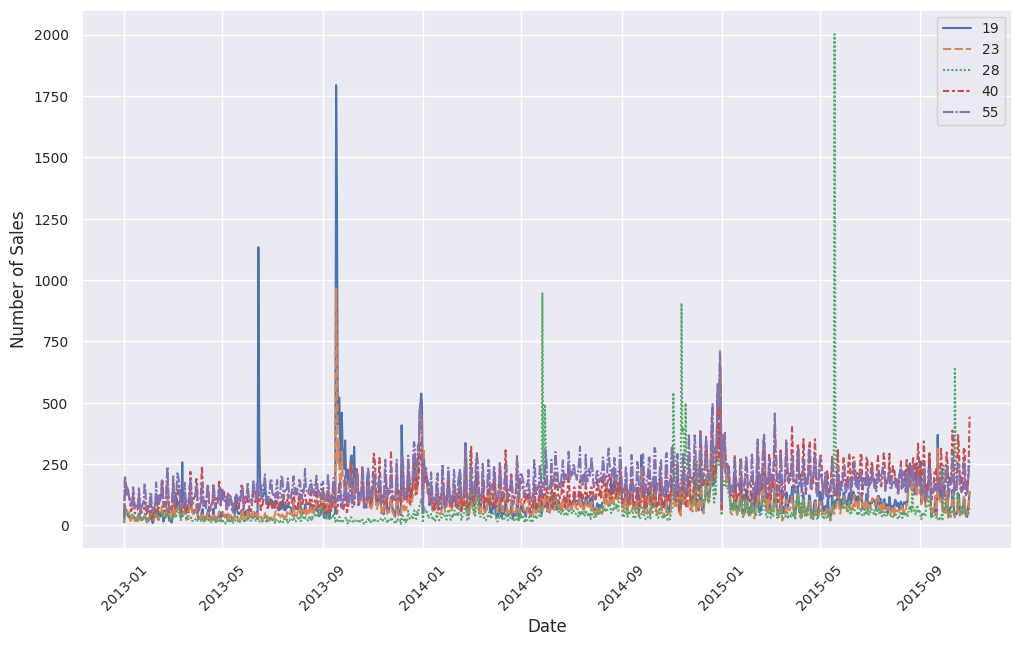

In [36]:
sample_id = [19, 28, 23, 55, 40]
line_plot_func(cats_sales, sample=sample_id, ylabel="Number of Sales")

### Value of Sales (file name _cats\_values_)

In [ ]:
#cats_values = sort_sales(categories_local_df, "cat", "final_price")
#cats_values.head()

In [37]:
cats_values = new_sort("cat_id", "final_price")
cats_values.head()

cat_id                2    3            5             6    7    9    11   12  \
date                                                                           
2013-01-01   7960.000000  0.0  2586.300049   4270.000000  0.0  0.0  0.0  0.0   
2013-01-02  50137.851562  0.0  7588.399902  63800.699219  0.0  0.0  0.0  0.0   
2013-01-03  50384.000000  0.0  4472.299805  26347.500000  0.0  0.0  0.0  0.0   
2013-01-04  30250.000000  0.0  3494.899902  39674.000000  0.0  0.0  0.0  0.0   
2013-01-05  29450.000000  0.0  6330.399902  30017.000000  0.0  0.0  0.0  0.0   

cat_id       15   16  ...   71      72       73   74       75   76     77  \
date                  ...                                                   
2013-01-01  0.0  0.0  ...  0.0     0.0      0.0  0.0   4870.0  0.0  199.0   
2013-01-02  0.0  0.0  ...  0.0  6025.0   7200.0  0.0  14000.0  0.0  597.0   
2013-01-03  0.0  0.0  ...  0.0  3577.0  19550.0  0.0  35740.0  0.0  597.0   
2013-01-04  0.0  0.0  ...  0.0  2348.0  11100.0  0.0  29178.0  0.0  199.0   
2013-01-05  0.0  0.0  ...  0.0  3077.0  27700.0  0.0  17079.0  0.0  199.0   

cat_id       78      79           83  
date                                  
2013-01-01  0.0   499.0  1226.000000  
2013-01-02  0.0  2595.0  8847.870117  
2013-01-03  0.0     0.0  4678.000000  
2013-01-04  0.0  2894.0  2752.000000  
2013-01-05  0.0  2126.0  2531.000000  

[5 rows x 60 columns]

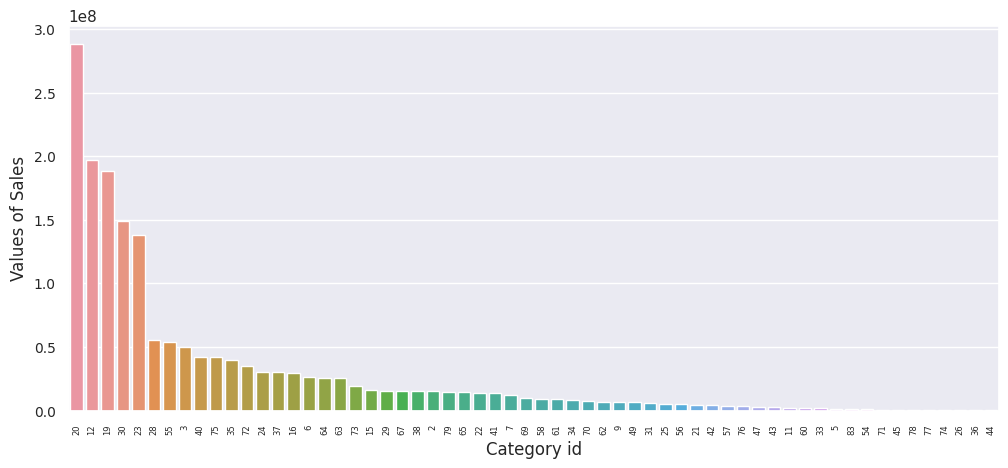

In [38]:
bar_plot_func(cats_values, "Category id", "Values of Sales")

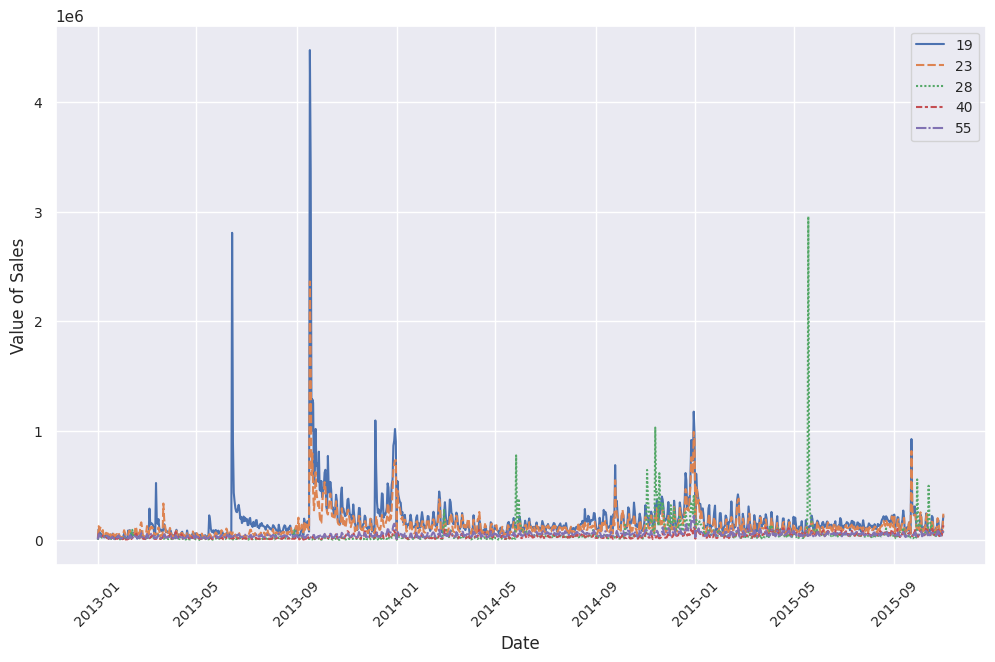

In [39]:
sample_id = [19, 28, 23, 55, 40]
line_plot_func(cats_values, sample=sample_id, ylabel="Value of Sales")

## Group by item

### Cleaning the data with the _test\_df_ Data Frame as base line

First we will remove the categories that don't show in the _test\_df_, to reduce the amount of data. The amount of data is to big, and will make analysis difficult. And those shops, categories and items have really small number on the sales.

In [11]:
unique_shops = test_local_df['shop_id'].unique()
unique_shops, len(unique_shops)

(array([ 5,  4,  6,  3,  2,  7, 10, 12, 28, 31, 26, 25, 22, 24, 21, 15, 16,
        18, 14, 19, 42, 50, 49, 53, 52, 47, 48, 57, 58, 59, 55, 56, 36, 37,
        35, 38, 34, 46, 41, 44, 39, 45]),
 42)

In [12]:
unique_cats = test_local_df['cat_id'].unique()
unique_cats, len(unique_cats)

(array([19, 55, 23, 20, 30, 22, 72, 35,  2,  3, 65, 24, 21, 28, 40, 70, 37,
        42, 69, 41, 67, 60, 38, 12, 31,  6, 15,  7, 29, 61, 49, 79, 64, 63,
        47, 16, 33, 25, 71, 77, 73, 56, 58, 75, 83, 62,  5, 57,  9, 45, 43,
         0, 11, 54, 76, 78, 34, 36, 27, 26, 74, 44]),
 62)

In [13]:
unique_item = test_local_df['item_id'].unique()
unique_item, len(unique_item)

(array([ 5037,  5320,  5233, ..., 15757, 19648,   969]), 5100)

In [14]:
sales_clean_df = sales_local_df[
    sales_local_df['shop_id'].isin(unique_shops)
    & sales_local_df['cat_id'].isin(unique_cats)
    & sales_local_df['item_id'].isin(unique_item)
]
sales_clean_df

date  date_block_num  shop_id  item_id   item_price  \
1005087 2013-01-01               0       14    15438   599.000000   
128444  2013-01-01               0       41     1523   799.000000   
128357  2013-01-01               0       28     1523   799.000000   
128396  2013-01-01               0       14     1523   799.000000   
760355  2013-01-01               0       15     8685   199.000000   
...            ...             ...      ...      ...          ...   
1788495 2015-10-31              33       58     3734  3399.000000   
2715396 2015-10-31              33       58    17748   288.149994   
1502745 2015-10-31              33       26    20949     5.000000   
2931438 2015-10-31              33       46     7223  3999.000000   
2922155 2015-10-31              33       31     3352  2999.000000   

         item_cnt_day  cat_id  final_price  
1005087             1      63   599.000000  
128444              1      21   799.000000  
128357              1      21   799.000000  
128396              1      21   799.000000  
760355              1      55   199.000000  
...               ...     ...          ...  
1788495             1      23  3399.000000  
2715396             1      70   288.149994  
1502745             3      71    15.000000  
2931438             1      20  3999.000000  
2922155             1      23  2999.000000  

[1224439 rows x 8 columns]

In [17]:
print(
    f"sales_local_df Rows: {sales_local_df.shape[0]}",
    f"sales_clean_df Rows: {sales_clean_df.shape[0]}",
    sep='\n'
)

sales_local_df Rows: 1224439
sales_clean_df Rows: 1224439


### Number of Sales (file name _items\_sales_)

In [40]:
items_sales = pd.pivot_table(
    sales_clean_df, values='item_cnt_day',
    index='item_id', columns=['date'],
    aggfunc=np.sum 
)
items_sales.fillna(0, inplace=True)
items_sales = items_sales.T

In [41]:
items_sales.head()

item_id     30     31     32     33     38     42     45     51     53     \
date                                                                        
2013-01-01    0.0    0.0    4.0    0.0    0.0    0.0    0.0    0.0    0.0   
2013-01-02    0.0    0.0   12.0    3.0    0.0    0.0    1.0    0.0    1.0   
2013-01-03    0.0    0.0   15.0    1.0    0.0    0.0    1.0    2.0    1.0   
2013-01-04    0.0    0.0   11.0    2.0    0.0    0.0    0.0    0.0    0.0   
2013-01-05    0.0    0.0   14.0    4.0    0.0    0.0    0.0    1.0    0.0   

item_id     57     ...  22111  22118  22139  22145  22154  22162  22163  \
date               ...                                                    
2013-01-01    0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2013-01-02    0.0  ...    0.0    0.0    1.0    0.0    3.0    0.0    0.0   
2013-01-03    0.0  ...    1.0    0.0    2.0    0.0    1.0    0.0    0.0   
2013-01-04    0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2013-01-05    0.0  ...    0.0    0.0    1.0    0.0    1.0    0.0    0.0   

item_id     22164  22166  22167  
date                             
2013-01-01    0.0    0.0    0.0  
2013-01-02    0.0    0.0    0.0  
2013-01-03    0.0    0.0    0.0  
2013-01-04    0.0    0.0    0.0  
2013-01-05    0.0    0.0    0.0  

[5 rows x 4716 columns]

In [42]:
items_sales.sum().sort_values(ascending=False)

item_id
20949    154077.0
2808      13955.0
3732      13582.0
17717     13553.0
5822      12268.0
           ...   
12400         1.0
21001         1.0
21007         1.0
21010         1.0
5959          1.0
Length: 4716, dtype: float64

<AxesSubplot: ylabel='Percent'>

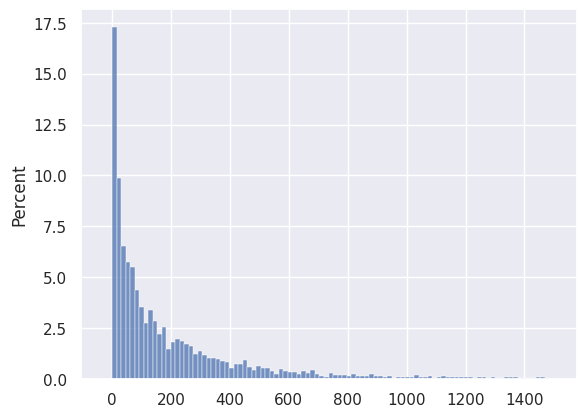

In [43]:
xxx = items_sales.sum().sort_values(ascending=False)
sns.histplot(xxx, stat='percent', bins=100, binrange=(-30, 1_500))

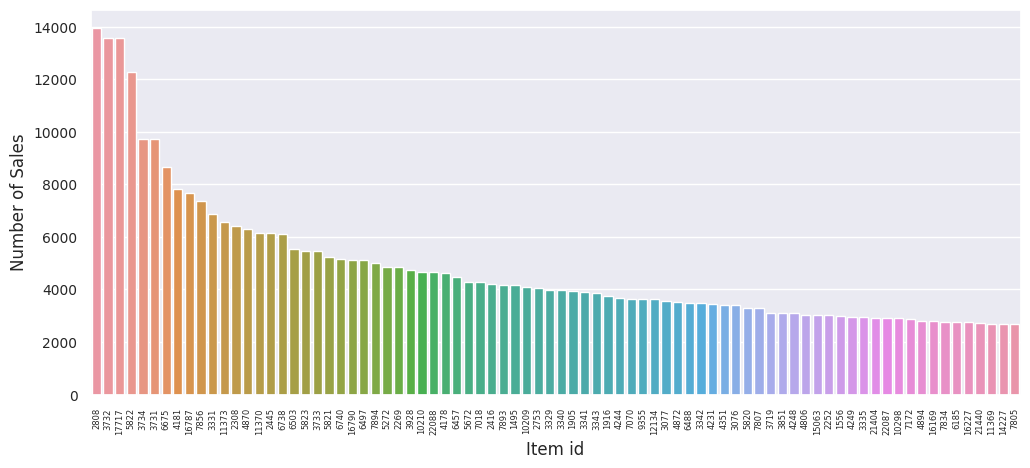

In [44]:
# Start at column = 1
bar_plot_func(items_sales, "Item id", "Number of Sales", start=1)

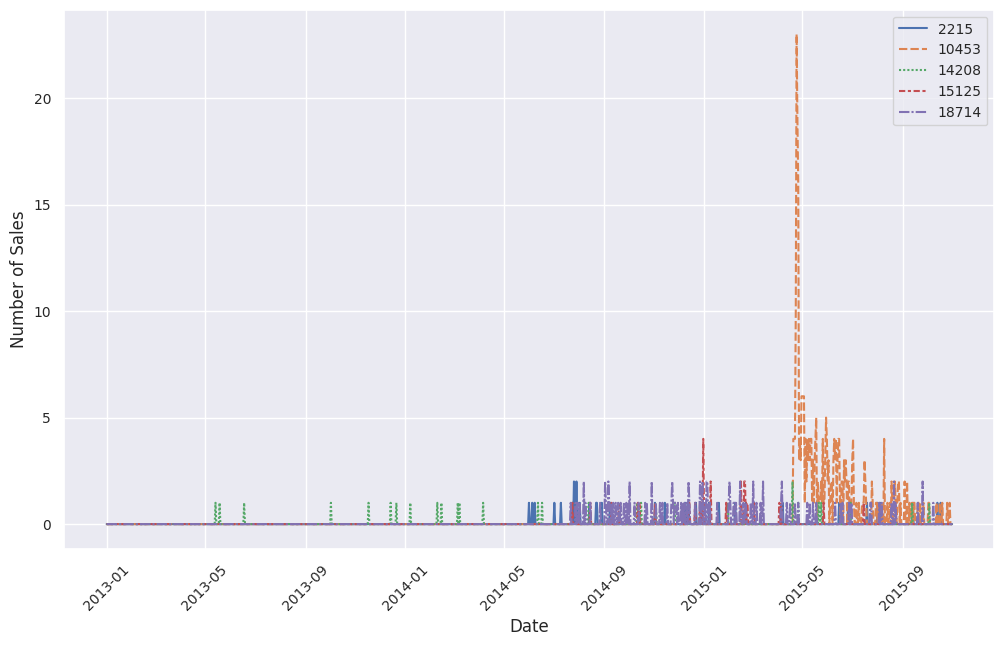

In [45]:
line_plot_func(items_sales, number=5, ylabel=f"Number of Sales")

### Values of Sales (file name _items\_values_)

In [46]:
items_values = pd.pivot_table(
    sales_clean_df, values='final_price',
    index=['item_id'], columns=['date'],
    aggfunc=np.sum 
)
items_values.fillna(0, inplace=True)
items_values = items_values.T

In [47]:
items_values.head()

item_id     30     31           32      33     38     42     45     51     \
date                                                                        
2013-01-01    0.0    0.0  1395.439941     0.0    0.0    0.0    0.0    0.0   
2013-01-02    0.0    0.0  4186.870117  1497.0    0.0    0.0  299.0    0.0   
2013-01-03    0.0    0.0  5217.549805   499.0    0.0    0.0  299.0  498.0   
2013-01-04    0.0    0.0  3839.000000   998.0    0.0    0.0    0.0    0.0   
2013-01-05    0.0    0.0  4886.000000  1996.0    0.0    0.0    0.0  249.0   

item_id     53     57     ...  22111  22118        22139  22145   22154  \
date                      ...                                             
2013-01-01    0.0    0.0  ...    0.0    0.0     0.000000    0.0     0.0   
2013-01-02  299.0    0.0  ...    0.0    0.0   791.119995    0.0  2997.0   
2013-01-03  299.0    0.0  ...  349.0    0.0  1998.000000    0.0   999.0   
2013-01-04    0.0    0.0  ...    0.0    0.0     0.000000    0.0     0.0   
2013-01-05    0.0    0.0  ...    0.0    0.0   899.369995    0.0   999.0   

item_id     22162  22163  22164  22166  22167  
date                                           
2013-01-01    0.0    0.0    0.0    0.0    0.0  
2013-01-02    0.0    0.0    0.0    0.0    0.0  
2013-01-03    0.0    0.0    0.0    0.0    0.0  
2013-01-04    0.0    0.0    0.0    0.0    0.0  
2013-01-05    0.0    0.0    0.0    0.0    0.0  

[5 rows x 4716 columns]

In [48]:
items_values.sum().sort_values(ascending=False)

item_id
6675     185097376.0
3732      35825964.0
3734      26103438.0
3731      19258302.0
3733      18826444.0
            ...     
18707          149.0
8247           149.0
342            144.0
4491            99.0
180             80.0
Length: 4716, dtype: float32

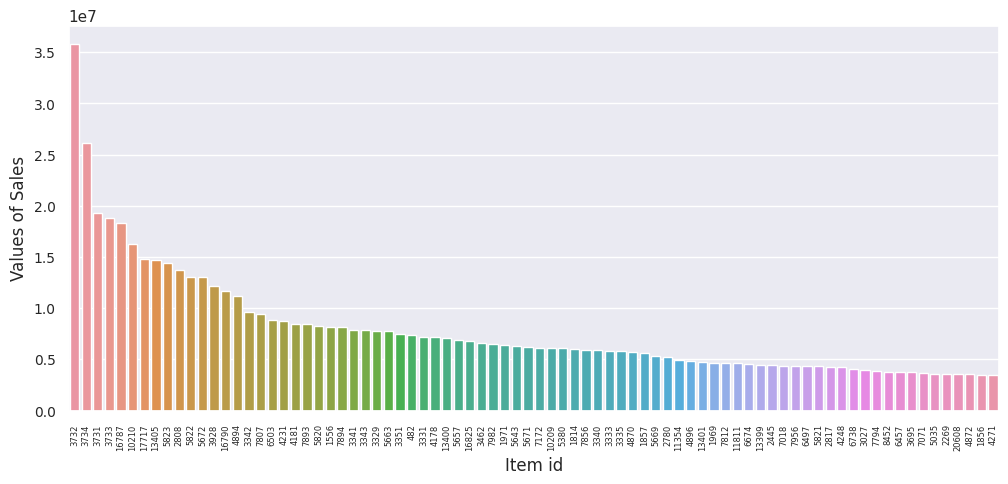

In [49]:
# Start at column = 1
bar_plot_func(items_values, "Item id", "Values of Sales", start=1)

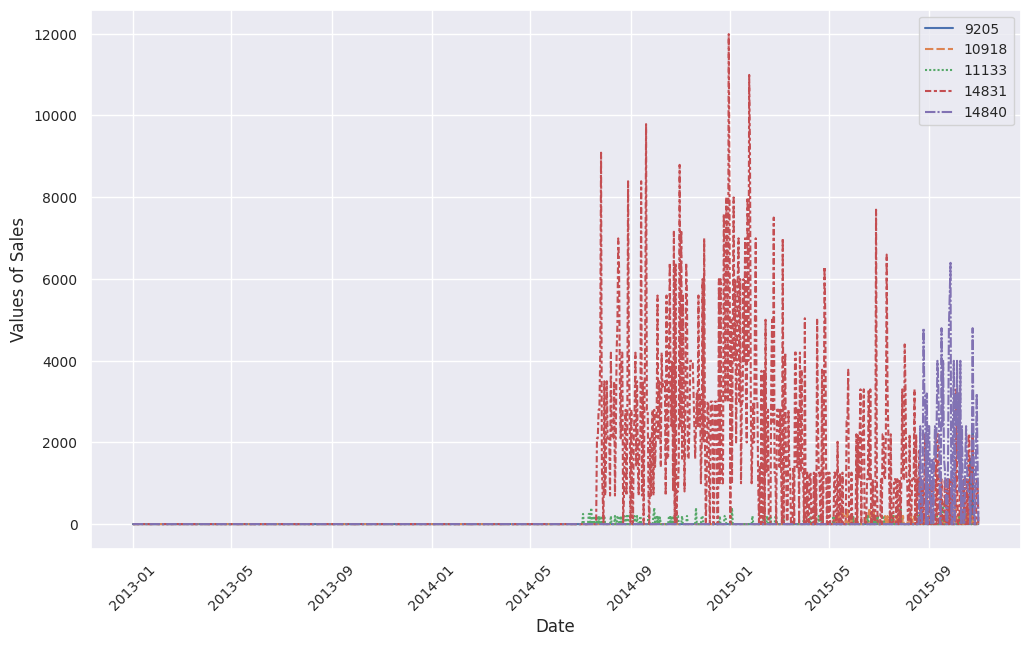

In [50]:
line_plot_func(items_values, number=5, ylabel=f"Values of Sales")

## Group  Categories by Shop

### Number of Sales (file name _cats_shops_sales_)

In [75]:
cats_shops_sales = pd.pivot_table(
    sales_clean_df, values='item_cnt_day',
    index=['shop_id', 'cat_id'], columns=['date'],
    aggfunc=np.sum 
)
cats_shops_sales.fillna(0, inplace=True)
cats_shops_sales = cats_shops_sales.T

In [76]:
cats_shops_sales

shop_id      2                                                ...   59       \
cat_id       2    3    5    6    7    11   12   15   16   19  ...   67   69   
date                                                          ...             
2013-01-01  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2013-01-02  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...  2.0  0.0   
2013-01-03  2.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  2.0  ...  1.0 -2.0   
2013-01-04  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  3.0  0.0   
2013-01-05  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  2.0  ...  1.0  0.0   
...         ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
2015-10-27  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...  0.0  3.0   
2015-10-28  0.0  2.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  3.0  ...  0.0  1.0   
2015-10-29  0.0  2.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  ...  0.0  0.0   
2015-10-30  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  4.0  ...  1.0  0.0   
2015-10-31  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  2.0  ...  0.0  0.0   

shop_id                                             
cat_id       70   71   72   73   75   77   79   83  
date                                                
2013-01-01  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2013-01-02  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2013-01-03  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  
2013-01-04  0.0  0.0  0.0  0.0  3.0  0.0  0.0  0.0  
2013-01-05  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  
...         ...  ...  ...  ...  ...  ...  ...  ...  
2015-10-27  1.0  1.0  0.0  0.0  2.0  0.0  0.0  1.0  
2015-10-28  1.0  2.0  0.0  0.0  1.0  0.0  0.0  0.0  
2015-10-29  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2015-10-30  1.0  0.0  1.0  0.0  1.0  0.0  1.0  0.0  
2015-10-31  1.0  1.0  2.0  1.0  1.0  0.0  1.0  0.0  

[1034 rows x 2008 columns]

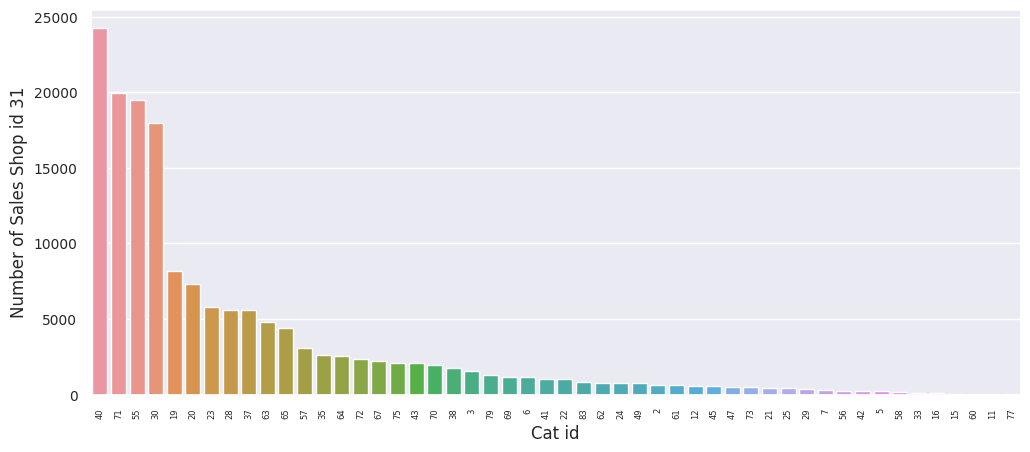

In [77]:
shop_id = 31
bar_plot_func(cats_shops_sales[shop_id], "Cat id", f"Number of Sales Shop id {shop_id}")

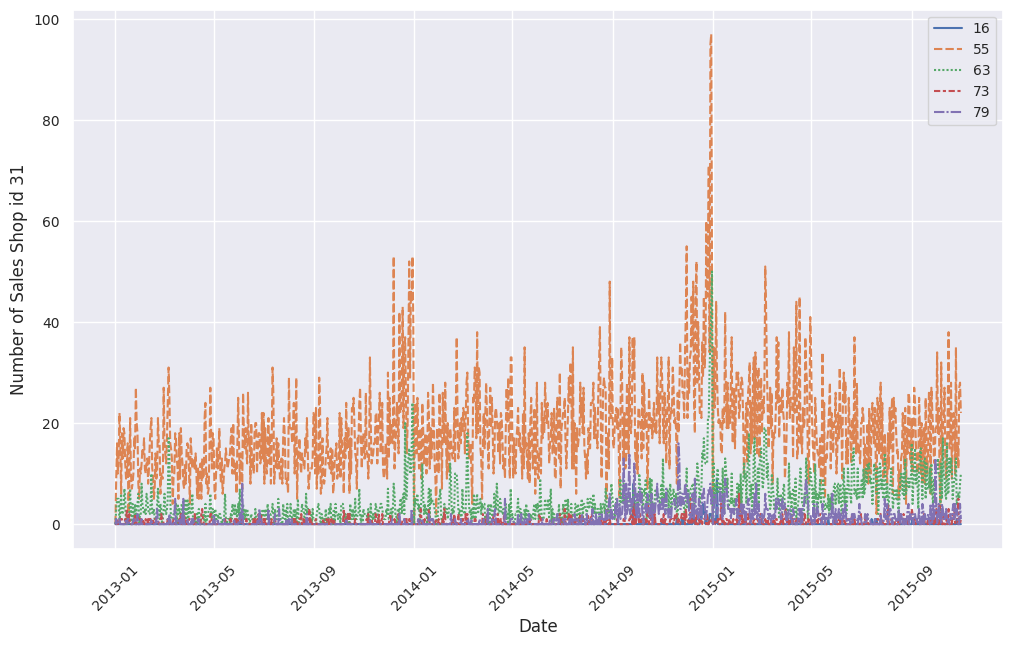

In [78]:
line_plot_func(cats_shops_sales[shop_id], number=5, ylabel=f"Number of Sales Shop id {shop_id}")

### Value of Sales (file name cats_shops_values)

In [79]:
cats_shops_values = pd.pivot_table(
    sales_clean_df, values='final_price',
    index=['shop_id', 'cat_id'], columns=['date'],
    aggfunc=np.sum 
)
cats_shops_values.fillna(0, inplace=True)
cats_shops_values = cats_shops_values.T

In [80]:
cats_shops_values.head()

shop_id         2                                                             \
cat_id          2    3           5       6    7    11   12   15   16      19   
date                                                                           
2013-01-01     0.0  0.0    0.000000     0.0  0.0  0.0  0.0  0.0  0.0     0.0   
2013-01-02  3180.0  0.0    0.000000     0.0  0.0  0.0  0.0  0.0  0.0  1199.0   
2013-01-03  3180.0  0.0  489.299988  1990.0  0.0  0.0  0.0  0.0  0.0  1798.0   
2013-01-04     0.0  0.0  699.000000     0.0  0.0  0.0  0.0  0.0  0.0     0.0   
2013-01-05  1590.0  0.0    0.000000     0.0  0.0  0.0  0.0  0.0  0.0  2698.0   

shop_id     ...      59                                                   
cat_id      ...      67   69   70   71   72   73      75   77   79    83  
date        ...                                                           
2013-01-01  ...     0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0   0.0  
2013-01-02  ...  1298.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0   0.0  
2013-01-03  ...   299.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  79.0  
2013-01-04  ...  1670.0  0.0  0.0  0.0  0.0  0.0  3450.0  0.0  0.0   0.0  
2013-01-05  ...   949.0  0.0  0.0  0.0  0.0  0.0  3500.0  0.0  0.0   0.0  

[5 rows x 2008 columns]

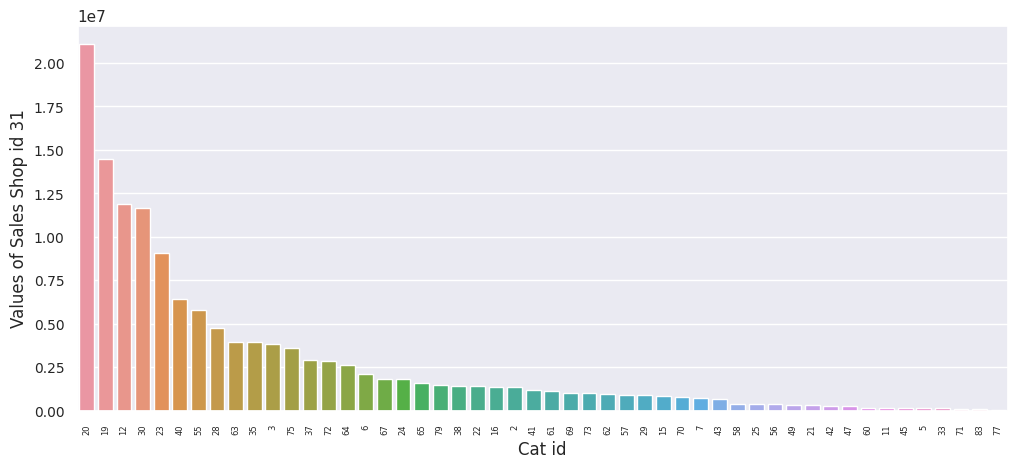

In [81]:
shop_id = 31
bar_plot_func(cats_shops_values[shop_id], "Cat id", f"Values of Sales Shop id {shop_id}")

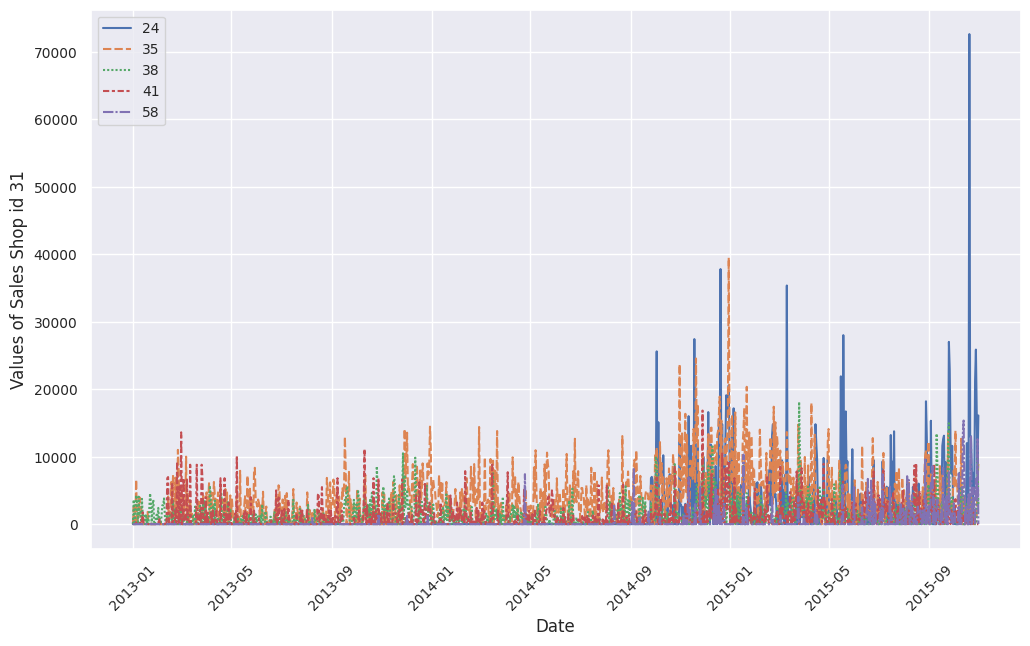

In [82]:
line_plot_func(cats_shops_values[shop_id], number=5, ylabel=f"Values of Sales Shop id {shop_id}")

## Total

### Files names: _total\_sales_ and _total\_values_

In [83]:
agg_month_graph_total_sales = sales_local_df.resample('m', on="date").sum()[['item_cnt_day']]
agg_month_total_values = sales_local_df.resample('m', on="date").sum()[['final_price']]

In [84]:
total_sales = sales_local_df.resample('d', on="date").sum()[['item_cnt_day']]
total_values = sales_local_df.resample('d', on="date").sum()[['final_price']]

In [85]:
agg_month_graph_total_sales

item_cnt_day
date                    
2013-01-31         20612
2013-02-28         22163
2013-03-31         31599
2013-04-30         20704
2013-05-31         23322
2013-06-30         32505
2013-07-31         29960
2013-08-31         32344
2013-09-30         44102
2013-10-31         39753
2013-11-30         44447
2013-12-31         68218
2014-01-31         41955
2014-02-28         42844
2014-03-31         49074
2014-04-30         37005
2014-05-31         42786
2014-06-30         44659
2014-07-31         44126
2014-08-31         52959
2014-09-30         48203
2014-10-31         53319
2014-11-30         69358
2014-12-31        104048
2015-01-31         67576
2015-02-28         54597
2015-03-31         54853
2015-04-30         58947
2015-05-31         56376
2015-06-30         51802
2015-07-31         52305
2015-08-31         59577
2015-09-30         58824
2015-10-31         62849

In [86]:
agg_month_total_values

final_price
date                   
2013-01-31   14820719.0
2013-02-28   17656040.0
2013-03-31   24484252.0
2013-04-30   14401244.0
2013-05-31   13896521.0
2013-06-30   22126696.0
2013-07-31   17934690.0
2013-08-31   18028178.0
2013-09-30   46259332.0
2013-10-31   36087648.0
2013-11-30   61222400.0
2013-12-31   97944576.0
2014-01-31   40332240.0
2014-02-28   55554428.0
2014-03-31   52259344.0
2014-04-30   34379796.0
2014-05-31   44524228.0
2014-06-30   41299128.0
2014-07-31   41375480.0
2014-08-31   49921580.0
2014-09-30   56803284.0
2014-10-31   57336640.0
2014-11-30   86573304.0
2014-12-31  126091880.0
2015-01-31   74759392.0
2015-02-28   60757256.0
2015-03-31   62738000.0
2015-04-30   72946496.0
2015-05-31   64829128.0
2015-06-30   55473320.0
2015-07-31   50902168.0
2015-08-31   56788836.0
2015-09-30   75781800.0
2015-10-31   75637040.0

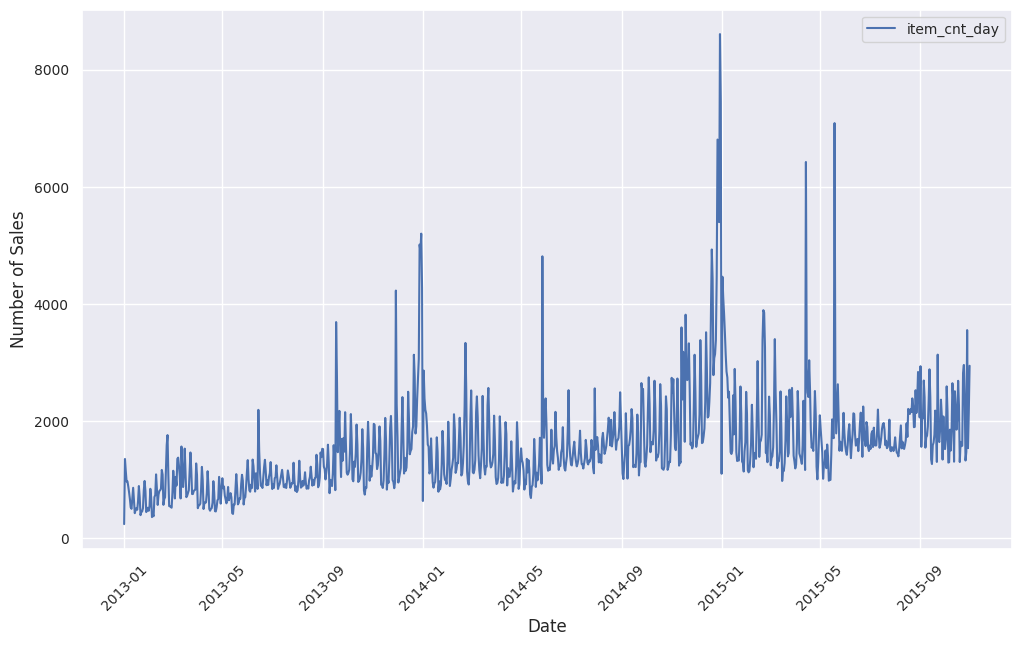

In [87]:
line_plot_func(total_sales, 1, ylabel="Number of Sales")

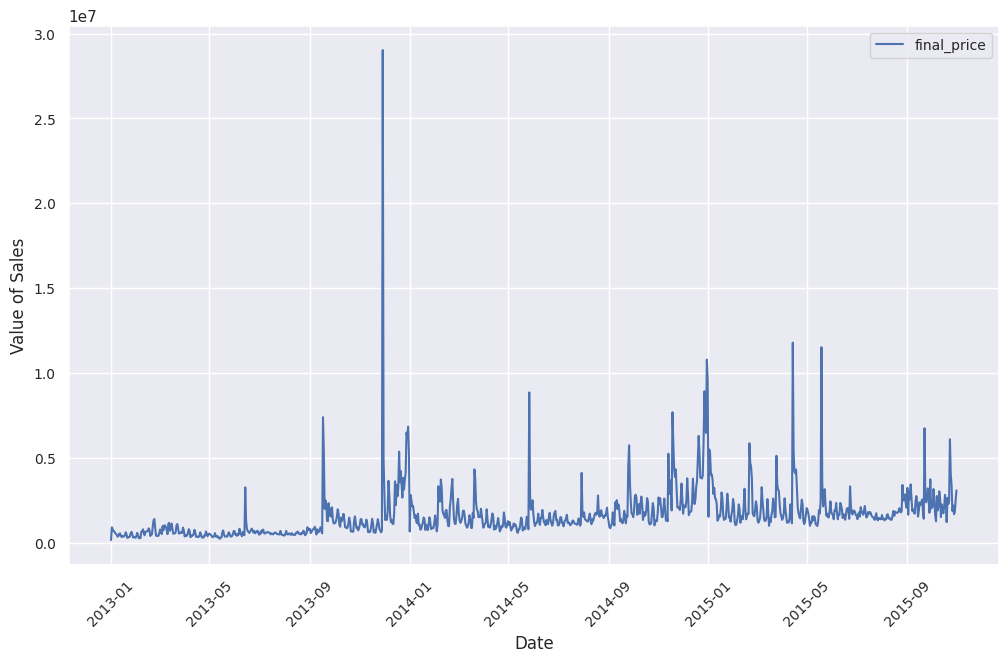

In [88]:
line_plot_func(total_values, 1, ylabel="Value of Sales")

### Need total DF

In [299]:
total_n_sales_day_v01 = total_sales.resample('d').sum()
total_n_sales_week_v01 = total_sales.resample('w').sum()
total_n_sales_month_v01 = total_sales.resample('m').sum()
total_n_sales_day_v01.to_csv('../raw_data/prophet_df/total_n_sales_day_v01.csv')
total_n_sales_week_v01.to_csv('../raw_data/prophet_df/total_n_sales_week_v01.csv')
total_n_sales_month_v01.to_csv('../raw_data/prophet_df/total_n_sales_month_v01.csv')

In [304]:
total_value_day_v01 = total_values.resample('d').sum()
total_value_week_v01 = total_values.resample('w').sum()
total_value_month_v01 = total_values.resample('m').sum()
total_value_day_v01.to_csv('../raw_data/prophet_df/total_value_day_v01.csv')
total_value_week_v01.to_csv('../raw_data/prophet_df/total_value_week_v01.csv')
total_value_month_v01.to_csv('../raw_data/prophet_df/total_value_month_v01.csv')

# Model Prophet
___

## Model Functions

In [51]:
# plot graph with train test and predict
def plot_forecast(prophet_dict: dict, test=True, pred=True, lower=False, upper=False, left=None, right=None) -> None:
    """
    Plot the train, test and forecast data.
    prophet_dict: prophet_model dictionary
    test, pred, lower, upper: turn on and off the plots.
    left, right: sets the x-axis limits, in date format.
    """
    plt.figure(figsize=(15, 8))
    
    # plots
    plt.plot(prophet_dict['train']['ds'], prophet_dict['train']['y'], label="Train")
    if test:
        plt.plot(prophet_dict['test']['ds'], prophet_dict['test']['y'], label="Test")
    if pred:
        plt.plot(
            prophet_dict['forecast'][-prophet_dict['horizon']:]['ds'],
            prophet_dict['forecast'][-prophet_dict['horizon']:]['yhat'],
            label="Pred")
    if lower:
        plt.plot(
            prophet_dict['forecast'][-prophet_dict['horizon']:]['ds'],
            prophet_dict['forecast'][-prophet_dict['horizon']:]['yhat_lower'],
            label="Lower")
    if upper:
        plt.plot(prophet_dict['forecast'][-prophet_dict['horizon']:]['ds'],
                 prophet_dict['forecast'][-prophet_dict['horizon']:]['yhat_upper'],
                 label="Upper")
    
    # x and y axis limits
    if left is not None:
        left = dt.datetime.strptime(left, '%Y-%m').date()
    if right is not None:
        right = dt.datetime.strptime(right, '%Y-%m').date()
    plt.xlim(left=left, right=right)    
    
    plt.legend(loc="best")
    plt.show()

In [52]:
# function to split the data between train and test
def set_train_data(df, split, frequency):
    """
    Split the Data Frame between train and test, if there is no need for test use split=1.
    df: Data Frame
    split: size (%) of the train data
    frequency: month, week, day
    """
    
    # Rename Columns to Prophet format
    df = df.reset_index()
    df.columns = ['ds', 'y']
    
    # Set size train and test df
    shape = df.shape[0]
    train_size = int(shape * split)
    train = df.iloc[:train_size]
    test = df.iloc[train_size:]
    
    # Set the horizin to predict
    horizon_dict = {'m': 2, 'w': 8, 'd':62} # two month, four weeks, 62 days
    horizon = (horizon_dict[frequency]) + (shape - train_size)
    return train, test, horizon

In [53]:
# fit the Prophet model
def prophet_model(df, split=0.9, seas_scale=10, inter_w=0.80, freq='d') -> dict:
    """
    Fit the whole model with FB Prophet.
    ------------------------------------
    data: the data to be used.
    split: Split between train and test, if there is no need for test use split=1.
    (seas_scale) seasonality_prior_scale:
        Larger values allow the model to fit larger seasonal fluctuations,
        smaller values dampen the seasonality.
    (inter_w) interval_width:
        Float, width of the uncertainty intervals provided for the forecast.
        Uses the MAP estimate of the extrapolated generative model.
    freq: Used to create the frequency (day, week, month), of train, test, forecast and horizon
    """
    # Split the data
    train_df, test_local_df, horizon = set_train_data(df, split, freq)
    
    # Prophet model fit
    model = prophet_fit(train_df, seas_scale, inter_w)
    
    # future prediction
    forecast = future_preds(model, horizon, freq)
    
    # dict with model, split data and forecast
    prophet_dict = {'model':model,
        'forecast':forecast,
        'train':train_df,
        'test':test_local_df,
        'horizon':horizon
    }
    
    return prophet_dict

In [54]:
# Prophet model
def prophet_fit(train_df, seas_scale, inter_w):
    model = Prophet(
        seasonality_mode='multiplicative', # or 'additive'
        seasonality_prior_scale=seas_scale, # default 10, smaller values dampen the seasonality
        interval_width=inter_w, # deaful 0.8, if mcmc < 0 will be integrated over all model parameters
        growth='linear', # is the default
        #yearly_seasonality=False, # default 'auto'
        #weekly_seasonality=True, # default 'auto'
        #daily_seasonality=False, # default 'auto'
        mcmc_samples=0, # default 0, if greater than 0, will do full Bayesian inference
    )
    return model.fit(train_df)    

In [55]:
# make future predictions
def future_preds(model, horizon, freq):
    """
    Return the forecast for a given model, frequency and horizon
    """
    future = model.make_future_dataframe(periods=horizon, freq=freq, )
    forecast = model.predict(future)
    # forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    return forecast    

## Get Forecast

In [56]:
def get_forecast_data(prophet_dict: dict):
    """
    Input is the dict return of the prophet_model function.
    Get the forecast for the predictions, by days (61), weeks (4) or month (2).
    """
    row_start = prophet_dict['train'].shape[0] + prophet_dict['test'].shape[0] + 1
    df = prophet_dict['forecast'][row_start:][['ds', 'yhat']]
    
    day_pred = df[['ds']].join(df['yhat'].round(2))
    week_pred = day_pred.resample('w', on='ds').sum().round(2).head(8)
    month_pred = day_pred.resample('m', on='ds').sum().round(2).head(2)
    
    forecast = {
        'day': day_pred,
        'week': week_pred,
        'month': month_pred
    }
    
    return forecast

In [ ]:
"""
def get_forecast_data(prophet_dict: dict):

    #Input is the dict return of the prophet_model function.
    #Get the forecast for the predictions, by days (61), weeks (4) or month (2).

    row_start = prophet_dict['train'].shape[0]+1
    df = prophet_dict['forecast'][row_start:][['ds', 'yhat']]
    
    day_pred = df[['ds']].join(df['yhat'].round(2))
    week_pred = day_pred.resample('w', on='ds').mean().round(2).head(8)
    month_pred = day_pred.resample('m', on='ds').mean().round(2).head(2)
    
    forecast = {
        'day': day_pred,
        'week': week_pred,
        'month': month_pred
    }
    
    return forecast
"""

## Evaluate Model for Total Data, _sales_ and _values_

### Fitting the Data and Making Future Predictions

In [308]:
# total_Shops_Number_sales
prophet_total_shops_sales = prophet_model(
    total_sales,
    split=0.90,
    seas_scale=10,
    inter_w=0.80,
    freq='d'
)

# total_Shops_Values
prophet_total_shops_values = prophet_model(
    total_values,
    split=0.90,
    seas_scale=10,
    inter_w=0.80,
    freq='d'
)

20:20:06 - cmdstanpy - INFO - Chain [1] start processing
20:20:06 - cmdstanpy - INFO - Chain [1] done processing
20:20:07 - cmdstanpy - INFO - Chain [1] start processing
20:20:07 - cmdstanpy - INFO - Chain [1] done processing


### Saving the Data

In [309]:
prophet_total_shops_sales.keys()

dict_keys(['model', 'forecast', 'train', 'test', 'horizon'])

In [310]:
prophet_total_shops_sales['horizon']

166

#### n_sale

In [311]:
model = prophet_total_shops_sales['model'] # model in jupyter notebook ###
print(type(model))
model = model_to_json(model)
print(type(json_model))

# here is the file NAME ##################################################
file = 'prophet_total_n_sales_' + 'model' + '.gz'
##########################################################################

dir_path = '../raw_data/cross_val/'
path = os.path.join(dir_path, file)
print(path)
with gzip.open(path, 'wt') as mdl:
    json.dump(model, mdl)

<class 'prophet.forecaster.Prophet'>


NameError: name 'json_model' is not defined

In [ ]:
forecast = prophet_total_shops_sales['forecast']
train = prophet_total_shops_sales['train']
test = prophet_total_shops_sales['test']
horizon = prophet_total_shops_sales['horizon']

prophet = 'prophet_total_n_sales_'
forecast_file = prophet + 'forecast' + '.csv'
train_file = prophet + 'train' + '.csv'
test_file = prophet + 'test' + '.csv'
horizon_file = prophet + 'horizon' + '.pkl'

print(os.path.join(dir_path, forecast_file))
print(os.path.join(dir_path, train_file))
print(os.path.join(dir_path, test_file))
print(os.path.join(dir_path, horizon_file))

forecast.to_csv(os.path.join(dir_path, forecast_file))
train.to_csv(os.path.join(dir_path, train_file))
test.to_csv(os.path.join(dir_path, test_file))

with open(os.path.join(dir_path, horizon_file), 'wb') as hrzn:
        pickle.dump(horizon, hrzn)

##### Load

In [ ]:
dir_path = '../raw_data/cross_val/'
file = 'prophet_total_n_sales_' + 'model' + '.gz'
path = os.path.join(dir_path, file)
prophet = 'prophet_total_n_sales_'
forecast_file = prophet + 'forecast' + '.csv'
train_file = prophet + 'train' + '.csv'
test_file = prophet + 'test' + '.csv'
horizon_file = prophet + 'horizon' + '.pkl'

print(path)
print(os.path.join(dir_path, forecast_file))
print(os.path.join(dir_path, train_file))
print(os.path.join(dir_path, test_file))
print(os.path.join(dir_path, horizon_file))

In [ ]:
../raw_data/cross_val/prophet_total_n_sales_model.gz
../raw_data/cross_val/prophet_total_n_sales_model.gz

In [ ]:
with gzip.open(path, 'rt') as mdl:
        model = fix_model_from_json(json.load(mdl))
        
forecast = pd.read_csv(os.path.join(dir_path, forecast_file)) 
train = pd.read_csv(os.path.join(dir_path, train_file))
test = pd.read_csv(os.path.join(dir_path, test_file))

forecast['ds'] = pd.to_datetime(forecast.ds)
train['ds'] = pd.to_datetime(train.ds)
test['ds'] = pd.to_datetime(test.ds)
            
with open(os.path.join(dir_path, horizon_file), 'rb') as hrzn:
    horizon = pickle.load(hrzn)        
    

##### TEST

In [ ]:
type(model)

In [ ]:
train.dtypes

In [ ]:
test.dtypes

In [ ]:
forecast.dtypes

In [ ]:
model.plot(forecast);

In [ ]:
test_model = {'model': model,
              'forecast': forecast,
              'train': train,
              'test': test,
              'horizon': horizon}
test_model['model']

In [ ]:
plot_forecast(test_model)

#### value

In [ ]:
model = prophet_total_shops_values['model'] # model in jupyter notebook ###
print(type(model))
model = model_to_json(model)
print(type(json_model))

# here is the file NAME ##################################################
file = 'prophet_total_value_' + 'model' + '.gz'
##########################################################################

dir_path = '../raw_data/cross_val/'
path = os.path.join(dir_path, file)
print(path)
with gzip.open(path, 'wt') as mdl:
    json.dump(model, mdl)

In [ ]:
forecast = prophet_total_shops_values['forecast']
train = prophet_total_shops_values['train']
test = prophet_total_shops_values['test']
horizon = prophet_total_shops_values['horizon']

prophet = 'prophet_total_value_'
forecast_file = prophet + 'forecast' + '.csv'
train_file = prophet + 'train' + '.csv'
test_file = prophet + 'test' + '.csv'
horizon_file = prophet + 'horizon' + '.pkl'

print(os.path.join(dir_path, forecast_file))
print(os.path.join(dir_path, train_file))
print(os.path.join(dir_path, test_file))
print(os.path.join(dir_path, horizon_file))

forecast.to_csv(os.path.join(dir_path, forecast_file))
train.to_csv(os.path.join(dir_path, train_file))
test.to_csv(os.path.join(dir_path, test_file))

with open(os.path.join(dir_path, horizon_file), 'wb') as hrzn:
        pickle.dump(horizon, hrzn)

##### Load

### Plotting the forecast test

#### Total Number of Sales

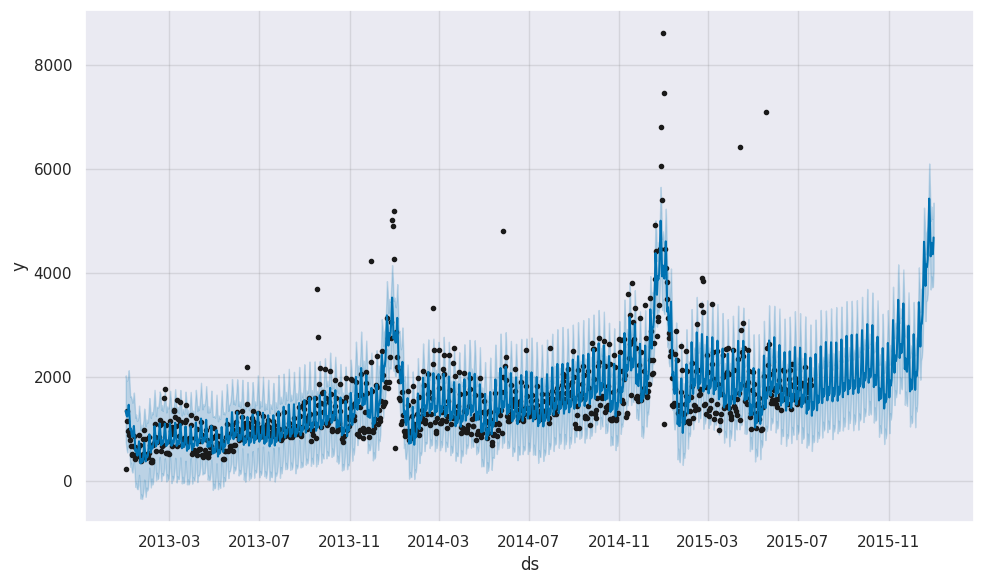

In [312]:
prophet_total_shops_sales['model'].plot(prophet_total_shops_sales['forecast']);

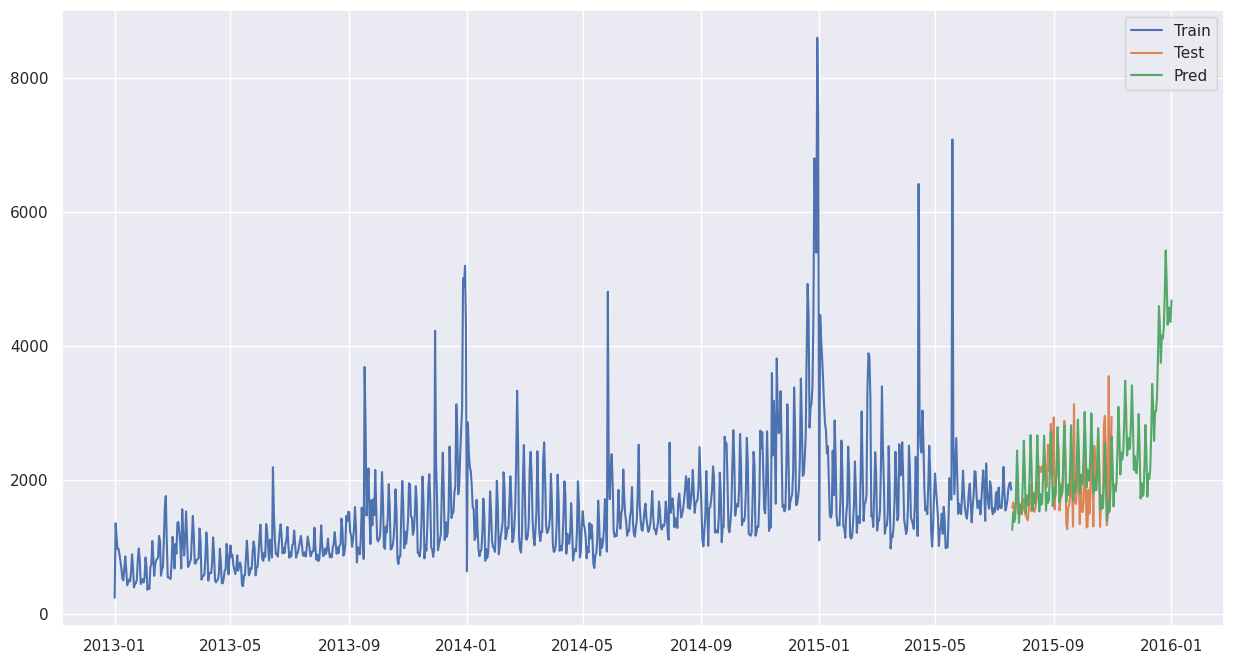

In [313]:
plot_forecast(prophet_total_shops_sales)

In [316]:
dt.datetime.strptime('2015-02', '%Y-%m').date()

datetime.date(2015, 2, 1)

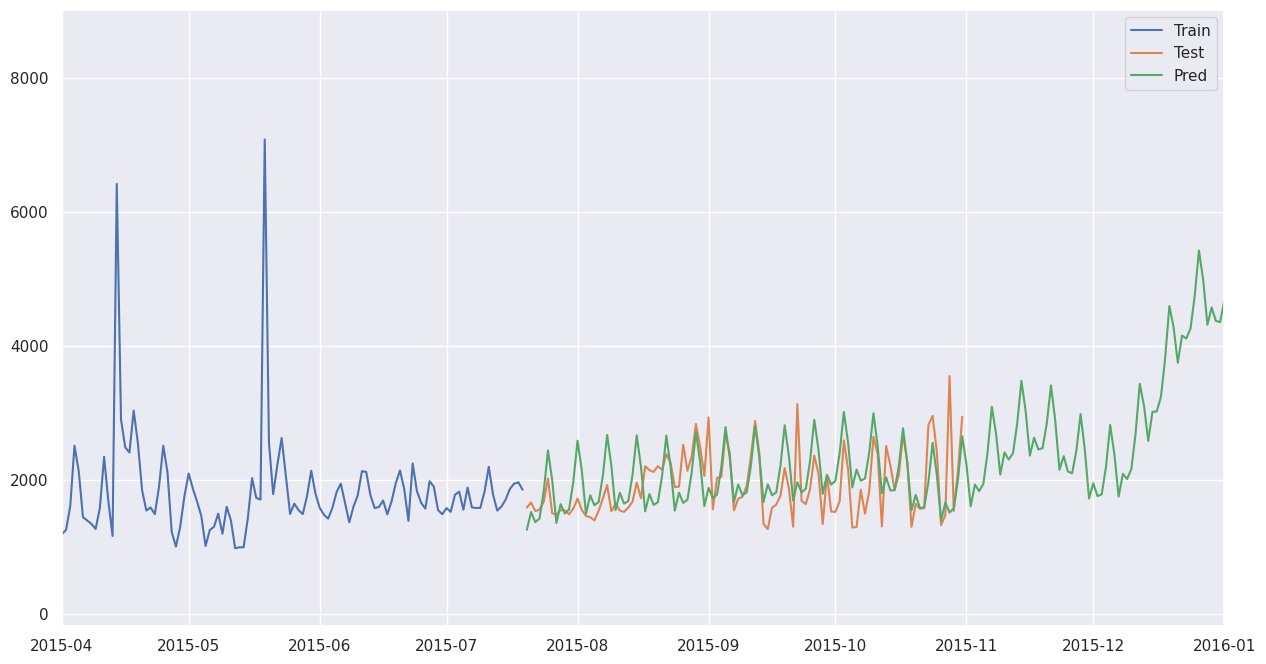

In [317]:
plot_forecast(prophet_total_shops_sales, left='2015-04', right='2016-01')

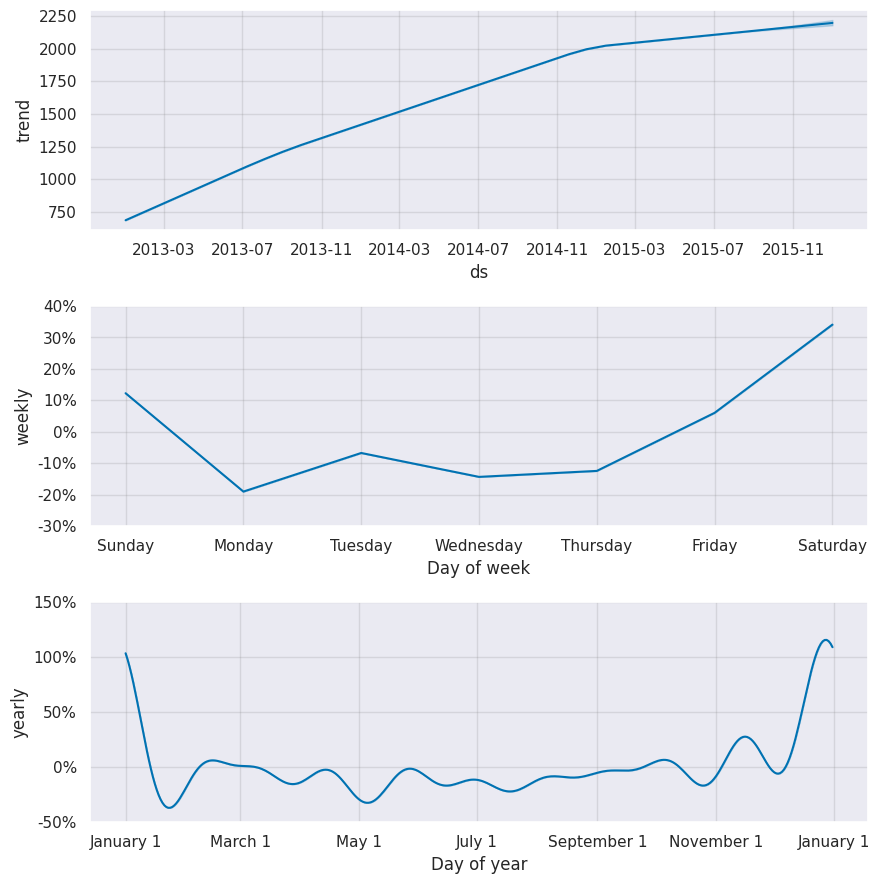

In [315]:
prophet_total_shops_sales['model'].plot_components(prophet_total_shops_sales['forecast']);

#### Total Value of Sales

In [ ]:
prophet_total_shops_values['model'].plot(prophet_total_shops_values['forecast']);

In [ ]:
plot_forecast(prophet_total_shops_values)

In [ ]:
plot_forecast(prophet_total_shops_values, left='2015-02', right='2016-01')

In [ ]:
prophet_total_shops_values['model'].plot_components(prophet_total_shops_values['forecast']);

### Cross-Validation

#### Sales

In [319]:
# cross-validation for frequency daily
cv_sales_results = cross_validation(
    model=prophet_total_shops_sales['model'],
    initial='365.25 days', # one year
    horizon='31 days', # one month
    period='7 days'
)

  0%|          | 0/77 [00:00<?, ?it/s]

21:31:27 - cmdstanpy - INFO - Chain [1] start processing
21:31:27 - cmdstanpy - INFO - Chain [1] done processing
21:31:27 - cmdstanpy - INFO - Chain [1] start processing
21:31:27 - cmdstanpy - INFO - Chain [1] done processing
21:31:28 - cmdstanpy - INFO - Chain [1] start processing
21:31:28 - cmdstanpy - INFO - Chain [1] done processing
21:31:28 - cmdstanpy - INFO - Chain [1] start processing
21:31:28 - cmdstanpy - INFO - Chain [1] done processing
21:31:29 - cmdstanpy - INFO - Chain [1] start processing
21:31:29 - cmdstanpy - INFO - Chain [1] done processing
21:31:29 - cmdstanpy - INFO - Chain [1] start processing
21:31:29 - cmdstanpy - INFO - Chain [1] done processing
21:31:29 - cmdstanpy - INFO - Chain [1] start processing
21:31:29 - cmdstanpy - INFO - Chain [1] done processing
21:31:29 - cmdstanpy - INFO - Chain [1] start processing
21:31:29 - cmdstanpy - INFO - Chain [1] done processing
21:31:29 - cmdstanpy - INFO - Chain [1] start processing
21:31:30 - cmdstanpy - INFO - Chain [1]

21:31:50 - cmdstanpy - INFO - Chain [1] done processing
21:31:50 - cmdstanpy - INFO - Chain [1] start processing
21:31:50 - cmdstanpy - INFO - Chain [1] done processing
21:31:50 - cmdstanpy - INFO - Chain [1] start processing
21:31:50 - cmdstanpy - INFO - Chain [1] done processing
21:31:50 - cmdstanpy - INFO - Chain [1] start processing
21:31:50 - cmdstanpy - INFO - Chain [1] done processing
21:31:50 - cmdstanpy - INFO - Chain [1] start processing
21:31:50 - cmdstanpy - INFO - Chain [1] done processing


In [320]:
cv_sales_results

ds         yhat   yhat_lower   yhat_upper     y     cutoff
0    2014-01-03  4164.251238  3724.266064  4579.227478  2382 2014-01-02
1    2014-01-04  4742.361534  4326.973016  5182.508007  2191 2014-01-02
2    2014-01-05  4298.035237  3871.530699  4728.186905  2126 2014-01-02
3    2014-01-06  3614.681182  3173.769673  4042.349005  1913 2014-01-02
4    2014-01-07  3777.244601  3355.704731  4196.814235  1594 2014-01-02
...         ...          ...          ...          ...   ...        ...
2382 2015-07-15  1449.080157   762.194553  2079.546708  1705 2015-06-18
2383 2015-07-16  1475.394558   799.394992  2142.632330  1866 2015-06-18
2384 2015-07-17  1888.534449  1231.408687  2578.598710  1942 2015-06-18
2385 2015-07-18  2531.487295  1845.793848  3210.386580  1963 2015-06-18
2386 2015-07-19  2022.893160  1356.179670  2689.398446  1852 2015-06-18

[2387 rows x 6 columns]

In [340]:
cv_sales_results.dtypes

ds            datetime64[ns]
yhat                 float64
yhat_lower           float64
yhat_upper           float64
y                      int32
cutoff        datetime64[ns]
dtype: object

In [332]:
performance_sales = performance_metrics(cv_sales_results)
performance_sales

horizon            mse        rmse         mae      mape     mdape  \
0   4 days  331570.426715  575.821523  403.368173  0.211088  0.156845   
1   5 days  687775.281179  829.322182  455.618597  0.245692  0.181044   
2   6 days  744399.166706  862.785701  458.014982  0.261258  0.185324   
3   7 days  781324.836768  883.925810  480.584674  0.279044  0.213453   
4   8 days  439945.596905  663.283949  415.092895  0.256504  0.179902   
5   9 days  415464.223210  644.565143  444.035323  0.250871  0.181569   
6  10 days  424265.173649  651.356411  459.854833  0.239388  0.178016   
7  11 days  422102.118419  649.693865  456.979089  0.252703  0.193030   
8  12 days  769410.872656  877.160688  504.716619  0.291946  0.208930   
9  13 days  805330.923276  897.402320  497.071132  0.304579  0.211593   
10 14 days  807625.159509  898.679676  498.391780  0.304932  0.211593   
11 15 days  426822.650684  653.316654  418.666348  0.265553  0.170708   
12 16 days  374270.835436  611.776786  440.381585  0.250363  0.176625   
13 17 days  368029.049726  606.653979  458.911744  0.237507  0.180820   
14 18 days  372339.799860  610.196526  457.942429  0.253369  0.187285   
15 19 days  723774.403091  850.749319  504.446915  0.288389  0.210023   
16 20 days  772983.055900  879.194550  496.249131  0.301132  0.216895   
17 21 days  784879.356705  885.934172  502.651615  0.302434  0.217503   
18 22 days  404717.945661  636.174462  423.456939  0.265080  0.184304   
19 23 days  351885.298909  593.199207  447.531043  0.250997  0.186246   
20 24 days  342714.496879  585.418224  462.776977  0.236688  0.189831   
21 25 days  351148.871970  592.578157  461.451355  0.250176  0.204595   
22 26 days  709260.826587  842.176244  506.853542  0.285590  0.216741   
23 27 days  762757.287052  873.359770  498.404592  0.297907  0.209385   
24 28 days  781681.253811  884.127397  506.596661  0.302655  0.216964   
25 29 days  403847.255159  635.489776  428.850079  0.265963  0.201174   
26 30 days  359442.801067  599.535488  458.898151  0.254961  0.197262   
27 31 days  356269.631212  596.883264  478.178277  0.242972  0.209128   

       smape  coverage  
0   0.194127  0.774637  
1   0.230509  0.751719  
2   0.248265  0.733002  
3   0.256874  0.688694  
4   0.226386  0.728801  
5   0.213666  0.701681  
6   0.203838  0.701299  
7   0.219484  0.690985  
8   0.255434  0.694805  
9   0.269747  0.697097  
10  0.266652  0.702445  
11  0.229222  0.729183  
12  0.213167  0.684492  
13  0.205499  0.652406  
14  0.221804  0.660428  
15  0.255944  0.680290  
16  0.269266  0.699771  
17  0.268914  0.682200  
18  0.232843  0.707792  
19  0.218135  0.667685  
20  0.208620  0.629870  
21  0.223781  0.630634  
22  0.257598  0.642857  
23  0.270939  0.681054  
24  0.271643  0.672651  
25  0.235880  0.711612  
26  0.222831  0.659282  
27  0.214902  0.625286

In [337]:
dir_path = '../raw_data/cross_val/'
file_name = 'cv_n_sales_results.csv'
full_path = os.path.join(dir_path, file_name)
print(full_path)

cv_sales_results.to_csv(full_path)

../raw_data/cross_val/cv_n_sales_results.csv


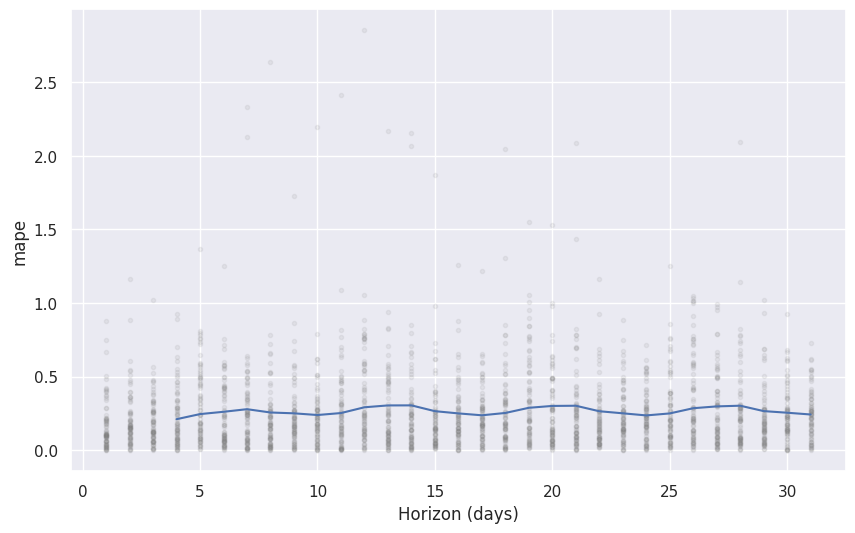

In [341]:
plot_cross_validation_metric(cv_sales_results, metric='mape');

#### Values

In [322]:
# cross-validation for frequency daily
cv_values_results = cross_validation(
    model=prophet_total_shops_values['model'],
    initial='365.25 days', # one year
    horizon='31 days', # one month
    period='7 days'
)

  0%|          | 0/77 [00:00<?, ?it/s]

21:32:17 - cmdstanpy - INFO - Chain [1] start processing
21:32:17 - cmdstanpy - INFO - Chain [1] done processing
21:32:18 - cmdstanpy - INFO - Chain [1] start processing
21:32:18 - cmdstanpy - INFO - Chain [1] done processing
21:32:18 - cmdstanpy - INFO - Chain [1] start processing
21:32:18 - cmdstanpy - INFO - Chain [1] done processing
21:32:18 - cmdstanpy - INFO - Chain [1] start processing
21:32:18 - cmdstanpy - INFO - Chain [1] done processing
21:32:18 - cmdstanpy - INFO - Chain [1] start processing
21:32:18 - cmdstanpy - INFO - Chain [1] done processing
21:32:18 - cmdstanpy - INFO - Chain [1] start processing
21:32:19 - cmdstanpy - INFO - Chain [1] done processing
21:32:19 - cmdstanpy - INFO - Chain [1] start processing
21:32:19 - cmdstanpy - INFO - Chain [1] done processing
21:32:20 - cmdstanpy - INFO - Chain [1] start processing
21:32:20 - cmdstanpy - INFO - Chain [1] done processing
21:32:20 - cmdstanpy - INFO - Chain [1] start processing
21:32:20 - cmdstanpy - INFO - Chain [1]

21:32:39 - cmdstanpy - INFO - Chain [1] done processing
21:32:40 - cmdstanpy - INFO - Chain [1] start processing
21:32:40 - cmdstanpy - INFO - Chain [1] done processing
21:32:40 - cmdstanpy - INFO - Chain [1] start processing
21:32:40 - cmdstanpy - INFO - Chain [1] done processing
21:32:40 - cmdstanpy - INFO - Chain [1] start processing
21:32:40 - cmdstanpy - INFO - Chain [1] done processing
21:32:40 - cmdstanpy - INFO - Chain [1] start processing
21:32:40 - cmdstanpy - INFO - Chain [1] done processing


In [323]:
cv_values_results

ds          yhat    yhat_lower    yhat_upper            y  \
0    2014-01-03  7.885923e+06  5.975300e+06  9.672576e+06  2527949.500   
1    2014-01-04  6.298524e+06  4.458826e+06  8.152489e+06  2151254.750   
2    2014-01-05  5.315056e+06  3.391452e+06  7.238445e+06  2190894.500   
3    2014-01-06  4.724653e+06  2.868571e+06  6.539220e+06  1817862.500   
4    2014-01-07  4.906377e+06  2.951825e+06  6.862554e+06  1470788.250   
...         ...           ...           ...           ...          ...   
2382 2015-07-15  1.179396e+06 -4.144349e+05  2.710397e+06  1816737.750   
2383 2015-07-16  1.117203e+06 -4.675472e+05  2.728475e+06  1720119.000   
2384 2015-07-17  1.837689e+06  1.585569e+05  3.496873e+06  1831353.375   
2385 2015-07-18  2.119645e+06  4.824083e+05  3.625185e+06  1796791.375   
2386 2015-07-19  1.437522e+06 -2.073856e+05  3.097278e+06  1634154.125   

         cutoff  
0    2014-01-02  
1    2014-01-02  
2    2014-01-02  
3    2014-01-02  
4    2014-01-02  
...         ...  
2382 2015-06-18  
2383 2015-06-18  
2384 2015-06-18  
2385 2015-06-18  
2386 2015-06-18  

[2387 rows x 6 columns]

In [333]:
performance_values = performance_metrics(cv_values_results)
performance_values

horizon           mse          rmse           mae      mape     mdape  \
0   4 days  8.443513e+11  9.188859e+05  6.445496e+05  0.336176  0.254109   
1   5 days  2.184554e+12  1.478024e+06  8.013691e+05  0.413959  0.302068   
2   6 days  2.519110e+12  1.587170e+06  8.826172e+05  0.474343  0.380942   
3   7 days  2.662218e+12  1.631631e+06  9.342776e+05  0.494951  0.409961   
4   8 days  1.856122e+12  1.362396e+06  9.199644e+05  0.530168  0.410091   
5   9 days  1.602641e+12  1.265955e+06  8.979750e+05  0.486675  0.319097   
6  10 days  1.523789e+12  1.234419e+06  8.762650e+05  0.456059  0.287202   
7  11 days  1.178632e+12  1.085648e+06  7.882386e+05  0.441875  0.296164   
8  12 days  2.467057e+12  1.570687e+06  9.151919e+05  0.511941  0.385052   
9  13 days  2.721034e+12  1.649556e+06  9.543129e+05  0.541141  0.408774   
10 14 days  2.761070e+12  1.661647e+06  9.574793e+05  0.516513  0.372467   
11 15 days  1.836080e+12  1.355020e+06  9.111533e+05  0.523866  0.364036   
12 16 days  1.513939e+12  1.230422e+06  8.854076e+05  0.477904  0.315628   
13 17 days  1.400652e+12  1.183491e+06  8.700560e+05  0.448621  0.311509   
14 18 days  1.082661e+12  1.040510e+06  7.910718e+05  0.438215  0.313132   
15 19 days  2.409433e+12  1.552235e+06  9.225462e+05  0.500983  0.381677   
16 20 days  2.705516e+12  1.644845e+06  9.710322e+05  0.530273  0.404601   
17 21 days  2.788565e+12  1.669900e+06  9.859979e+05  0.509789  0.404924   
18 22 days  1.886077e+12  1.373345e+06  9.463629e+05  0.528512  0.402325   
19 23 days  1.544586e+12  1.242814e+06  9.105530e+05  0.485690  0.331375   
20 24 days  1.405321e+12  1.185462e+06  8.788846e+05  0.453982  0.313199   
21 25 days  1.062763e+12  1.030904e+06  7.870152e+05  0.434107  0.319670   
22 26 days  2.425172e+12  1.557296e+06  9.298119e+05  0.506453  0.367196   
23 27 days  2.719395e+12  1.649059e+06  9.850202e+05  0.536873  0.421498   
24 28 days  2.791690e+12  1.670835e+06  1.003430e+06  0.518324  0.428925   
25 29 days  1.889848e+12  1.374717e+06  9.501216e+05  0.526279  0.374727   
26 30 days  1.542972e+12  1.242164e+06  9.043086e+05  0.483056  0.305341   
27 31 days  1.404378e+12  1.185065e+06  8.672277e+05  0.450768  0.310399   

       smape  coverage  
0   0.329041  0.937739  
1   0.403160  0.914439  
2   0.460181  0.885027  
3   0.472173  0.871658  
4   0.452654  0.836516  
5   0.400715  0.831933  
6   0.370328  0.828495  
7   0.402933  0.862872  
8   0.462999  0.852559  
9   0.494238  0.844920  
10  0.473759  0.836898  
11  0.441923  0.813598  
12  0.391427  0.839954  
13  0.368988  0.857143  
14  0.408416  0.904125  
15  0.464945  0.875859  
16  0.496522  0.862872  
17  0.473739  0.837280  
18  0.446233  0.818182  
19  0.395041  0.828113  
20  0.368246  0.851795  
21  0.398581  0.883881  
22  0.461495  0.854087  
23  0.497160  0.833079  
24  0.479635  0.832315  
25  0.444939  0.817418  
26  0.392390  0.843774  
27  0.364664  0.849121

In [339]:
dir_path = '../raw_data/cross_val/'
file_name = 'cv_value_results.csv'
full_path = os.path.join(dir_path, file_name)
print(full_path)

cv_values_results.to_csv(full_path)

../raw_data/cross_val/cv_value_results.csv


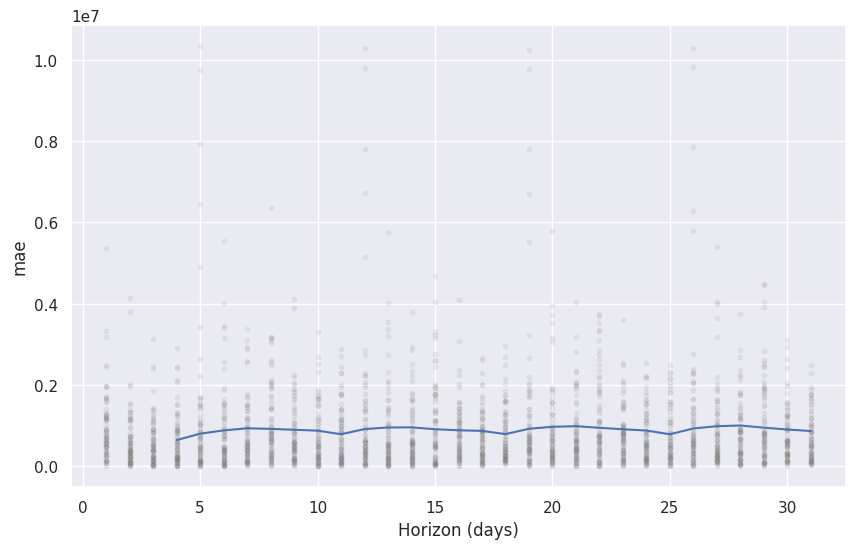

In [330]:
plot_cross_validation_metric(cv_values_results, metric='mae');

## Total Prediction (no train test split, _"split=1"_)

In [89]:
# total_Shops_Number_sales
prophet_total_shops_sales = prophet_model(
    total_sales,
    split=1
)

# total_Shops_Values
prophet_total_shops_values = prophet_model(
    total_values,
    split=1
)

18:59:38 - cmdstanpy - INFO - Chain [1] start processing
18:59:38 - cmdstanpy - INFO - Chain [1] done processing
18:59:38 - cmdstanpy - INFO - Chain [1] start processing
18:59:38 - cmdstanpy - INFO - Chain [1] done processing


In [90]:
prophet_total_shops_sales['forecast'].resample('m', on='ds').mean().round(2).head(2)

trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
ds                                                                     
2013-01-31  710.66       98.40     1404.84       710.66       710.66   
2013-02-28  778.05      134.16     1433.35       778.05       778.05   

            multiplicative_terms  multiplicative_terms_lower  \
ds                                                             
2013-01-31                  0.07                        0.07   
2013-02-28                  0.00                        0.00   

            multiplicative_terms_upper  weekly  weekly_lower  weekly_upper  \
ds                                                                           
2013-01-31                        0.07   -0.01         -0.01         -0.01   
2013-02-28                        0.00    0.00          0.00          0.00   

            yearly  yearly_lower  yearly_upper  additive_terms  \
ds                                                               
2013-01-31    0.08          0.08          0.08             0.0   
2013-02-28    0.00          0.00          0.00             0.0   

            additive_terms_lower  additive_terms_upper    yhat  
ds                                                              
2013-01-31                   0.0                   0.0  754.56  
2013-02-28                   0.0                   0.0  781.88

In [91]:
total_sales_pred = get_forecast_data(prophet_total_shops_sales)
total_values_pred = get_forecast_data(prophet_total_shops_values)

### Prediction (sales and values) for "only" the next month, all shops

In [92]:
# SALES
total_sales_pred = total_sales_pred['month']['yhat'][0]
total_sales_pred

69215.01

In [93]:
# VALUES
total_values_pred = total_values_pred['month']['yhat'][0]
total_values_pred

102760610.79

## Save and Load Models functions

In [57]:
# Save models to file, json(gz) and pickle
def save_model_data(prophet: dict, name: str, save=True):
    """
    Input is the prophet dict return of the prophet_model function.
    name: name of the file to be saved, in .json
    save: save the results in a external file
    Convert Prophet model to json file.
    Convert Data Frame to json file.
    Saves the model and all the data in the local /raw_data/prophet of the project
    Saves only the model in the /prophet_models, local and git repository.
    """
    if not save:
        return "=== MODEL NOT SAVED ==="
    
    print("=== START ===")
    model = {}
    forecast = {}
    train = {}
    test = {}
    horizon = {}
    
    # loop over the ids and features to build a dict with json files
    for id in prophet:
        model[id] = prophet[id]['model']
        forecast[id] = prophet[id]['forecast'].copy()
        train[id] = prophet[id]['train'].copy()
        test[id] = prophet[id]['test'].copy()
        horizon[id] = int(prophet[id]['horizon'])
        
        # prophet model to json
        model[id] = model_to_json(model[id])
              
        # DF to json
        forecast[id] = forecast[id].to_json()
        train[id] = train[id].to_json()
        test[id] = test[id].to_json()
        # horizon[id] = prophet[id]
    
    # save model and data localy
    with gzip.open('../raw_data/prophet/' + name + '_model.gz', 'wt') as model_dict:
        json.dump(model, model_dict)
        
    with gzip.open('../raw_data/prophet/' + name + '_forecast.gz', 'wt') as forecast_dict:
        json.dump(forecast, forecast_dict)
        
    with gzip.open('../raw_data/prophet/' + name + '_train.gz', 'wt') as train_dict:
        json.dump(train, train_dict)
        
    with gzip.open('../raw_data/prophet/' + name + '_test.gz', 'wt') as test_dict:
        json.dump(test, test_dict)
        
    with open('../raw_data/prophet/' + name + '_horizon.pkl', 'wb') as horizon_pkl:
        pickle.dump(horizon, horizon_pkl)
    
    print("=== MODEL SAVED ===")
    
    return None

In [151]:
# Load models from file
def load_model(file_name: str, path='../raw_data/prophet/') -> dict:    
    path_model = os.path.join(path, file_name + "_model.gz")
    path_forecast = os.path.join(path, file_name + "_forecast.gz")
    path_train = os.path.join(path, file_name + "_train.gz")
    path_test = os.path.join(path, file_name + "_test.gz")
    path_horizon = os.path.join(path, file_name + "_horizon.pkl")

    with gzip.open(path_model, 'rt') as mdl:
        model = json.load(mdl)
            
    with gzip.open(path_forecast, 'rt') as frct:
        forecast = json.load(frct)
            
    with gzip.open(path_train, 'rt') as trn:
        train = json.load(trn)
        
    with gzip.open(path_test, 'rt') as tst:
        test = json.load(tst)
            
    with open(path_horizon, 'rb') as hrzn:
        horizon = pickle.load(hrzn)
    
    #print("=====================================")
    #print(type(horizon))
    #print(horizon)
    #print()
    #print(list(horizon.keys())[0])
    #print(type(list(horizon.keys())[0]))
    #print()
    #print(type(horizon.keys()))
    #print("=====================================")
    #print(horizon[2])
    #print("=====================================")
    
    results = {}
    for id in model:
        #print(id)
        #print(type(id))
        prophet_dict = {}
        prophet_dict = {
            'model': fix_model_from_json(model[id]),
            'forecast': pd.read_json(forecast[id]),
            'train': pd.read_json(train[id]),
            'test': pd.read_json(test[id]),
            'horizon': int(horizon[int(id)]) #HARD CODED! why? no ideia.
        }
        prophet_dict['forecast']['ds'] = pd.to_datetime(prophet_dict['forecast'].ds, unit='ms')
        prophet_dict['train']['ds'] = pd.to_datetime(prophet_dict['train'].ds, unit='ms')
        prophet_dict['test']['ds'] = pd.to_datetime(prophet_dict['test'].ds, unit='ms')
        results[id] = prophet_dict
    
    return results

In [59]:
# Rum prophet or load model result
def run_load_model(df, load=False, model_name="", freq='d'):
    df_id_list = df.columns.to_list()
    prophet_id = {}    
    
    if load:
        print("=== START LOADING ===")
        models = load_model(model_name)
        
        print("=== MODEL LOADED ===")
        
        return models
    
    print("=== Running Prophet Model from Scratch ===")
    
    """
    for id in df_id_list:
        df_ids = df[id].fillna(0)
        prophet_result = prophet_model(
            df=df_ids,
            split=1
        )
        prophet_id[id] = prophet_result
    """
        
    with Pool(cpu_count()) as pool:
        prophet_id = list(pool.map(prophet_model, [df[id].fillna(0) for id in df]))
        
    prophet_id = dict(zip(df_id_list, prophet_id))
    
    print("=== END RUNNING ===")
    
    return prophet_id

##  Shop Prediction

### Sales

In [60]:
print(f"LOADED => {LOADED}", f"SAVED => {SAVED}", sep='\n')

LOADED => True
SAVED => False


In [173]:
%%time
# initialize model for each shop id
prophet_shops_id_sales = run_load_model(
    df=shops_sales,
    load=True,
    model_name="prophet_shops_id_sales",
    freq=freq_analysis)

=== START LOADING ===
=== MODEL LOADED ===
CPU times: user 1.18 s, sys: 20.1 ms, total: 1.2 s
Wall time: 1.2 s


In [174]:
# get the prediction for "only" the next month for every shop
shops_id_sales_pred = {}
for shop in prophet_shops_id_sales:
    pred = prophet_shops_id_sales[shop]
    pred = get_forecast_data(pred)
    shops_id_sales_pred[shop] = pred['month']['yhat'][0]

In [176]:
indice = prophet_shops_id_sales['2']['forecast']['ds']

In [177]:
prophet_shops_id_sales['2']['forecast']['yhat']

0       10.446709
1        9.806154
2        9.075969
3        9.738774
4       10.919909
          ...    
1091    61.713926
1092    67.760691
1093    64.947814
1094    61.565783
1095    66.500961
Name: yhat, Length: 1096, dtype: float64

In [178]:
xxx = pd.DataFrame(index=indice)
for id in prophet_shops_id_sales:
    xxx[id] = list(prophet_shops_id_sales[id]['forecast']['yhat'])
xxx

2          3          4          5           6  \
ds                                                                   
2013-01-01  10.446709  10.446580  24.810142   8.227451   53.850240   
2013-01-02   9.806154  10.145168  24.087406   7.838741   48.982233   
2013-01-03   9.075969  10.534219  22.461998   7.979788   48.355977   
2013-01-04   9.738774  10.940379  24.003245   8.529632   51.954165   
2013-01-05  10.919909  13.318110  27.134445  10.192701   55.979320   
...               ...        ...        ...        ...         ...   
2015-12-28  61.713926  44.729496  62.723440  61.161722   98.711126   
2015-12-29  67.760691  47.103813  66.387372  62.308593  106.295658   
2015-12-30  64.947814  46.742142  65.742225  60.199726   98.954147   
2015-12-31  61.565783  49.502228  62.745470  61.939507   99.203015   
2016-01-01  66.500961  52.307152  67.767862  66.509387  106.941229   

                     7         10          12         14          15  ...  \
ds                                                                    ...   
2013-01-01   36.153595  12.570259   21.436853  28.337710   40.384496  ...   
2013-01-02   33.630831  11.953291   14.029037  25.376643   39.116129  ...   
2013-01-03   32.868500  10.867396   14.402660  26.649560   38.824099  ...   
2013-01-04   34.156080  11.855182   10.247748  26.542901   40.898078  ...   
2013-01-05   38.844708  12.141094    1.631592  31.455122   45.813197  ...   
...                ...        ...         ...        ...         ...  ...   
2015-12-28  112.041303  27.007161  263.760763  66.897904  108.598202  ...   
2015-12-29  116.056900  30.220244  340.583459  70.852095  110.189434  ...   
2015-12-30  110.569550  29.151247  233.431994  65.225073  108.976079  ...   
2015-12-31  110.375624  26.995985  237.517608  69.412008  110.212605  ...   
2016-01-01  116.256191  29.455712  176.385357  70.241792  117.453028  ...   

                   48         49         50         52         53          55  \
ds                                                                              
2013-01-01  -0.461592  -0.640722  41.324367  23.484739  30.092189   -2.074745   
2013-01-02  -0.474856  -0.638501  40.072327  22.194251  27.863681   -1.902329   
2013-01-03  -0.432350  -0.625699  39.704104  21.214587  27.782289   -1.814955   
2013-01-04  -0.455732  -0.666494  42.054582  22.944715  28.982833   -1.806082   
2013-01-05  -0.580005  -0.815459  50.253647  24.698128  35.094772   -1.729498   
...               ...        ...        ...        ...        ...         ...   
2015-12-28  13.763740  46.323050  50.506695  69.260534  66.296293  132.548571   
2015-12-29  14.119989  46.976071  51.010453  71.037527  70.372958  139.088967   
2015-12-30  14.671578  48.274767  50.313124  68.638873  66.560246  136.777494   
2015-12-31  13.612524  48.775050  50.624759  67.054726  67.559441  140.982434   
2016-01-01  14.393835  53.332060  54.056087  73.028279  71.348607  152.413050   

                   56          57          58         59  
ds                                                        
2013-01-01  33.451390    3.223244    7.054927  27.248032  
2013-01-02  32.177818    3.881068    7.135831  25.782259  
2013-01-03  32.311089    4.320141    7.167752  26.219165  
2013-01-04  36.380861    5.300165    7.423425  26.663791  
2013-01-05  46.543422    6.663130    8.661025  33.909323  
...               ...         ...         ...        ...  
2015-12-28  61.642563  149.426464  129.013050  68.426178  
2015-12-29  64.580824  155.247999  128.994303  71.694908  
2015-12-30  63.357619  154.619515  127.331177  69.354402  
2015-12-31  64.812241  148.213659  125.071967  71.720109  
2016-01-01  73.706061  158.764605  126.206514  74.014378  

[1096 rows x 42 columns]

<font size="5"> Total Sales for next month, sun of all shops </font>

In [179]:
all_shops_id_sales_pred = sum(list(shops_id_sales_pred.values()))
all_shops_id_sales_pred

73229.54000000004

#### Save the data (on _raw\_data_) and model (on _git_) in json file

In [ ]:
save_model_data(prophet_shops_id_sales, 'prophet_shops_id_sales', save=True)

#### Plot example

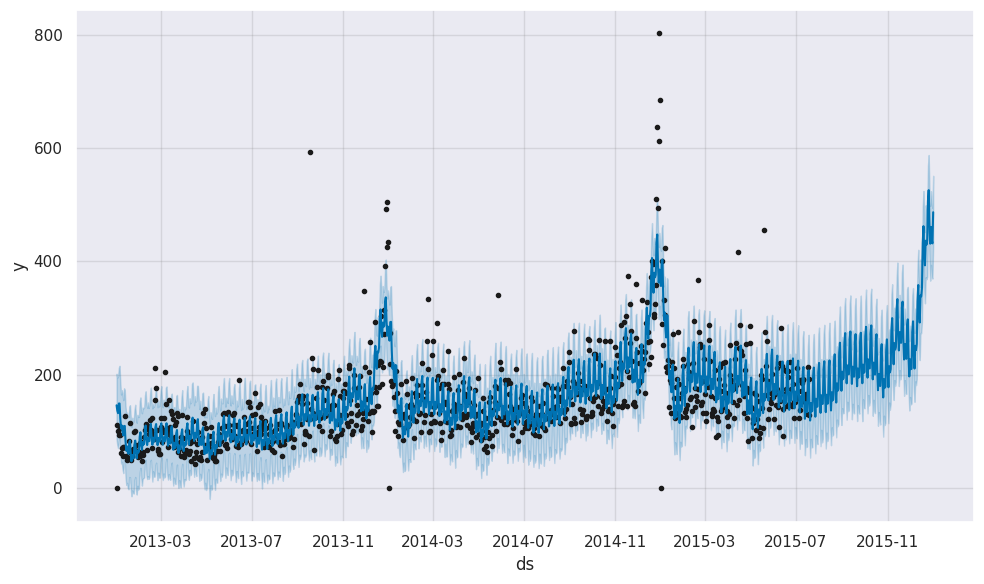

In [181]:
prophet_shops_id_sales['31']['model'].plot(prophet_shops_id_sales['31']['forecast']);

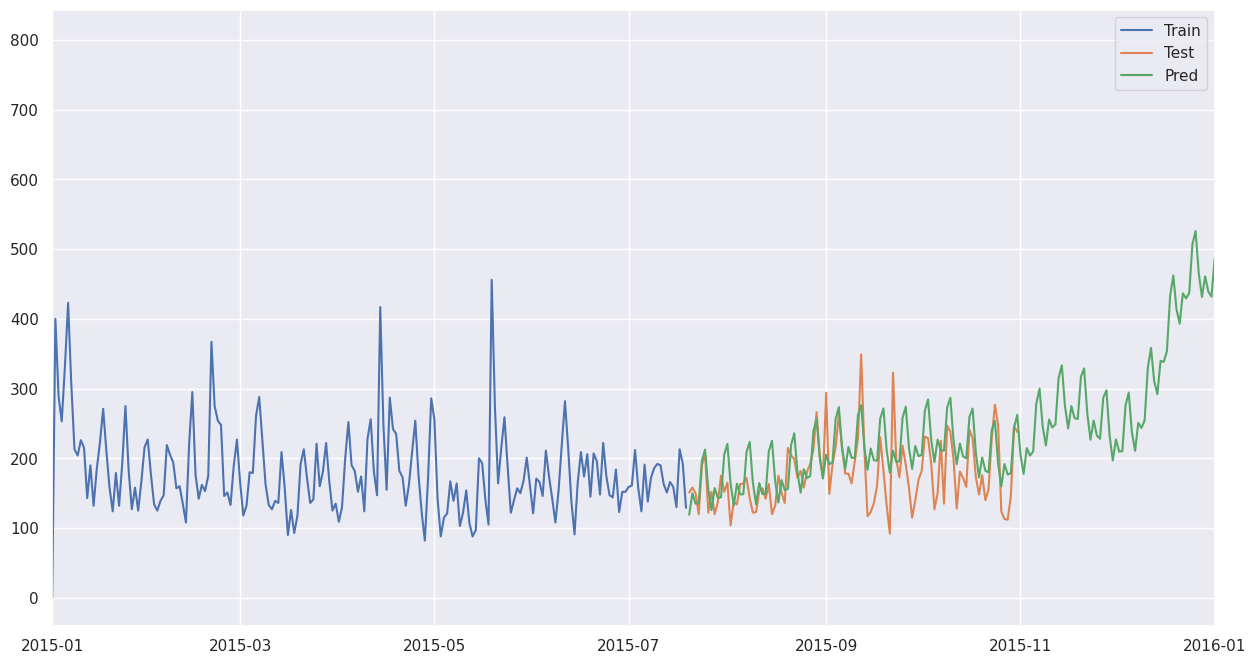

In [182]:
plot_forecast(prophet_shops_id_sales['31'], left='2015-01', right='2016-01')

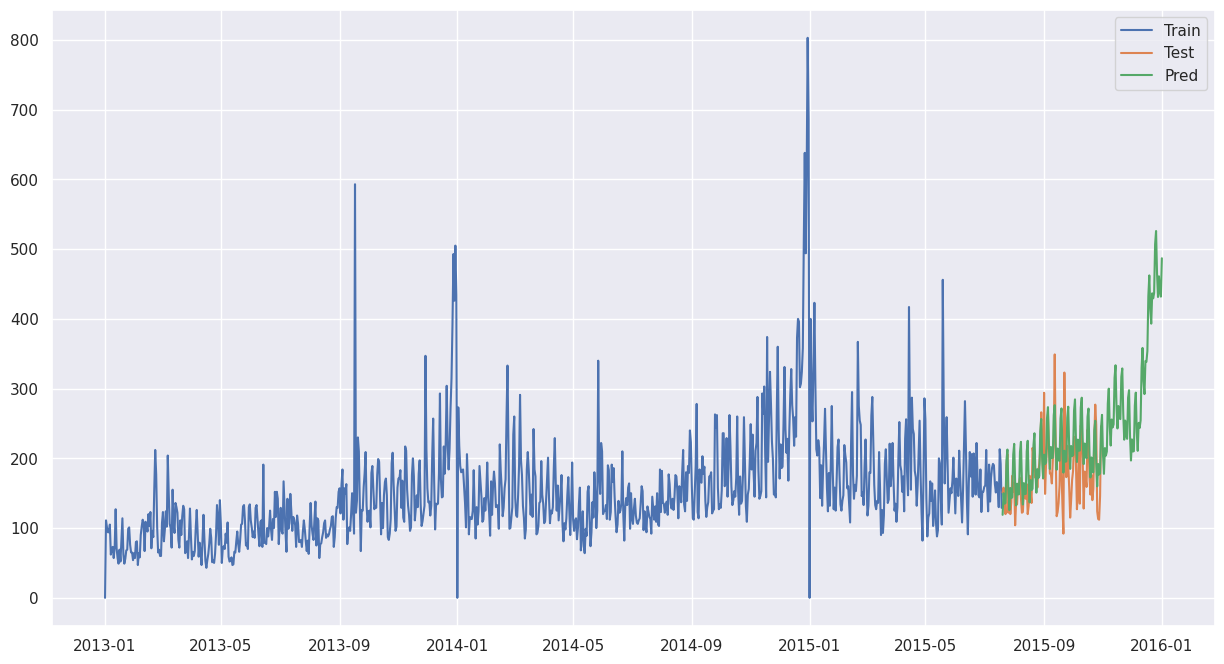

In [183]:
plot_forecast(prophet_shops_id_sales['31'])

### Values

In [184]:
%%time
# initialize model for each shop id
prophet_shops_id_values = run_load_model(
    df=shops_values,
    load=True,
    model_name="prophet_shops_id_values",
    freq=freq_analysis)

=== START LOADING ===
=== MODEL LOADED ===
CPU times: user 1.12 s, sys: 3.89 ms, total: 1.12 s
Wall time: 1.19 s


In [185]:
# get the prediction for "only" the next month for every shop
shops_id_values_pred = {}
for shop in prophet_shops_id_values:
    pred = prophet_shops_id_values[shop]
    pred = get_forecast_data(pred)
    shops_id_values_pred[shop] = pred['month']['yhat'][0]

<font size="5"> Total Values for next month, sun of all shops </font>

In [186]:
all_shops_id_values_pred = sum(list(shops_id_values_pred.values()))
all_shops_id_values_pred

104581586.60000004

#### Save the data (on raw_data) and model (on git) in json file

In [ ]:
save_model_data(prophet_shops_id_values, 'prophet_shops_id_values', save=True)

#### Plot example

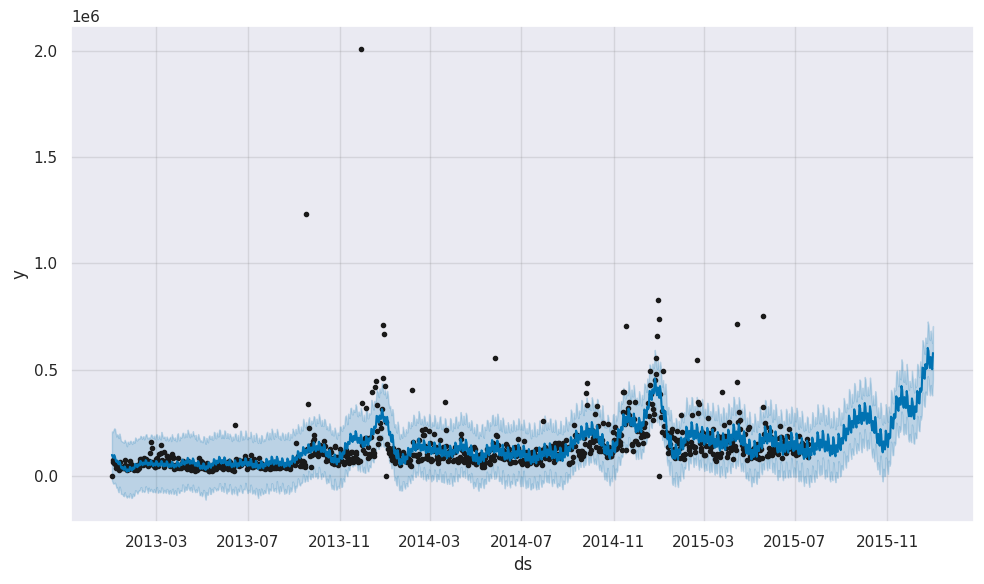

In [187]:
prophet_shops_id_values['31']['model'].plot(prophet_shops_id_values['31']['forecast']);

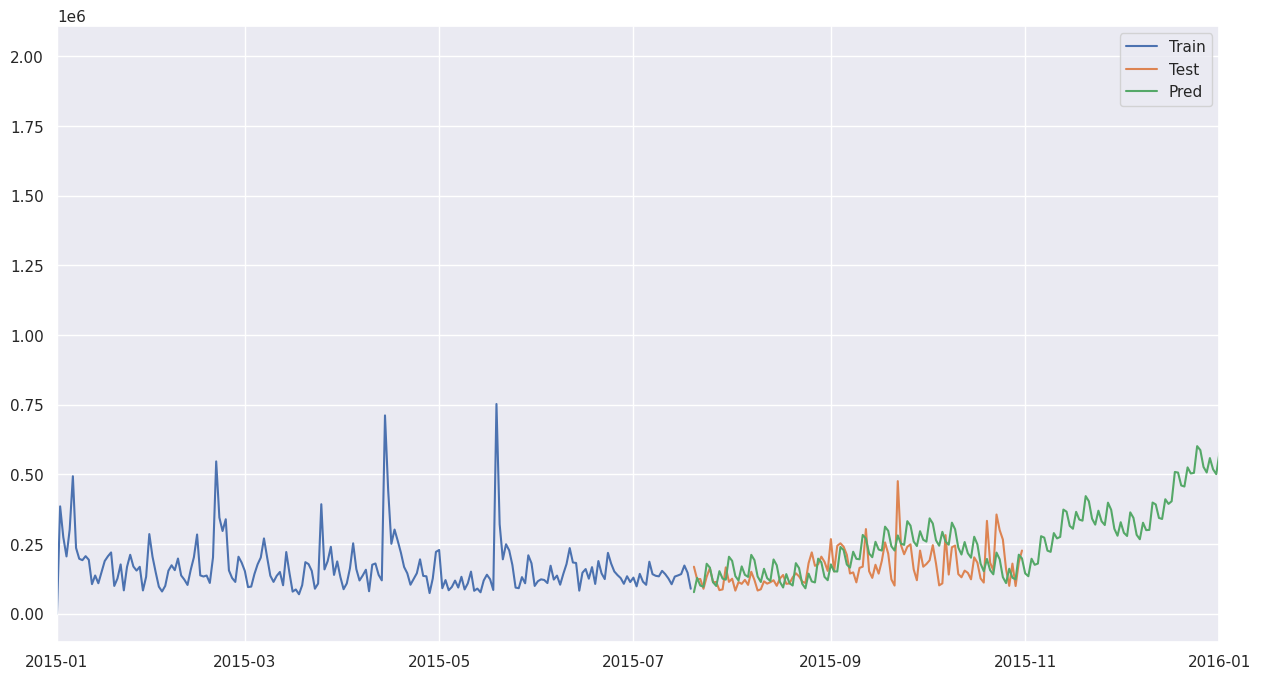

In [188]:
plot_forecast(prophet_shops_id_values['31'], left='2015-01', right='2016-01')

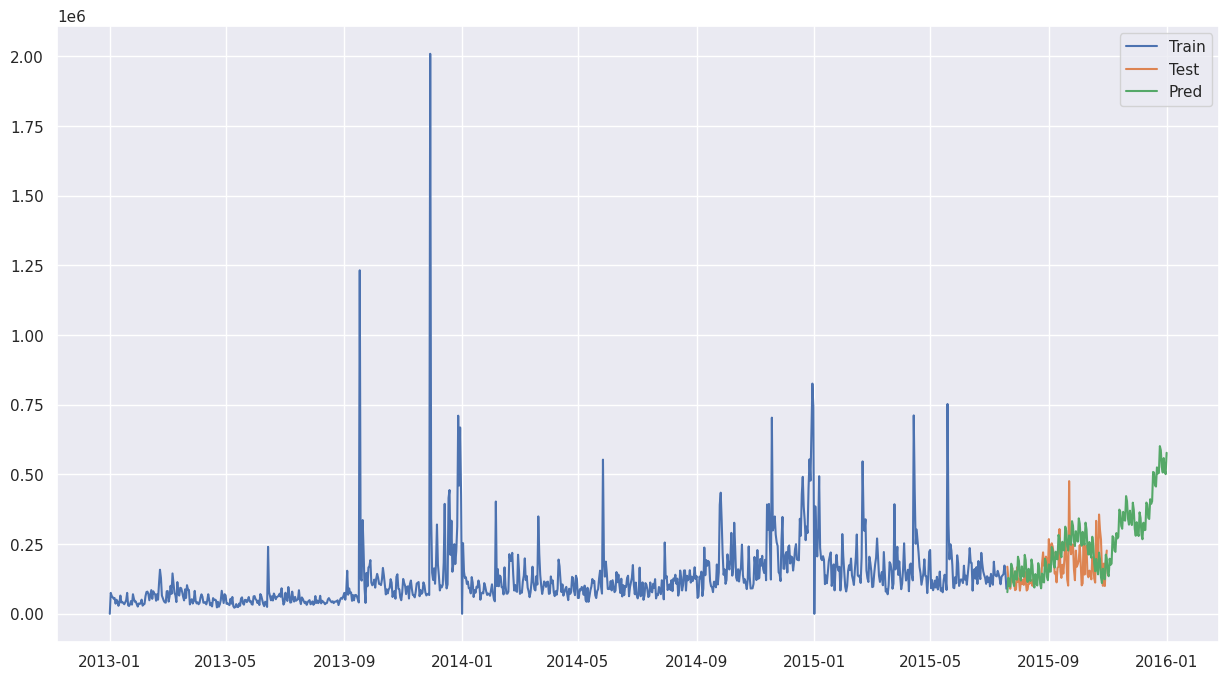

In [189]:
plot_forecast(prophet_shops_id_values['31'])

## Category Prediction

### Sales

In [152]:
%%time
# initialize model for each category id
prophet_cats_id_sales = run_load_model(
    df=cats_sales,
    load=True,
    model_name="prophet_cats_id_sales",
    freq=freq_analysis)

=== START LOADING ===
=== MODEL LOADED ===
CPU times: user 1.56 s, sys: 3.92 ms, total: 1.56 s
Wall time: 1.56 s


In [134]:
# get the prediction for "only" the next month for every category
cats_id_sales_pred = {}
for cat in prophet_cats_id_sales:
    pred = prophet_cats_id_sales[cat]
    pred = get_forecast_data(pred)
    cats_id_sales_pred[cat] = pred['month']['yhat'][0]

<font size="5"> Total Sales for next month, sun of all categories </font>

In [135]:
all_cats_id_sales_pred = sum(list(cats_id_sales_pred.values())).round(2)
all_cats_id_sales_pred

73615.7

#### Save the data (on raw_data) and model (on git) in json file

In [ ]:
save_model_data(prophet_cats_id_sales, 'prophet_cats_id_sales', save=True)

#### Plot Example

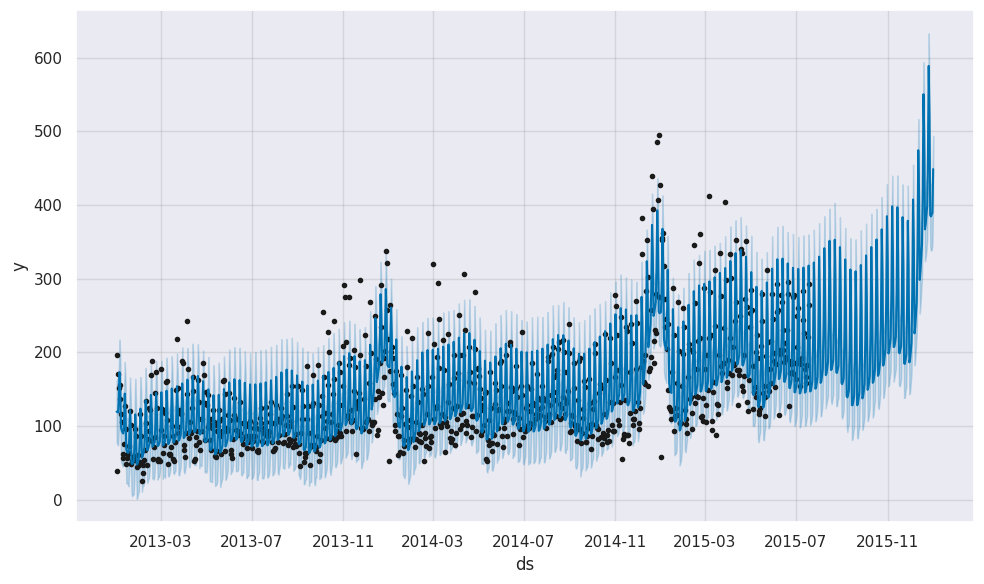

In [154]:
prophet_cats_id_sales['40']['model'].plot(prophet_cats_id_sales['40']['forecast']);

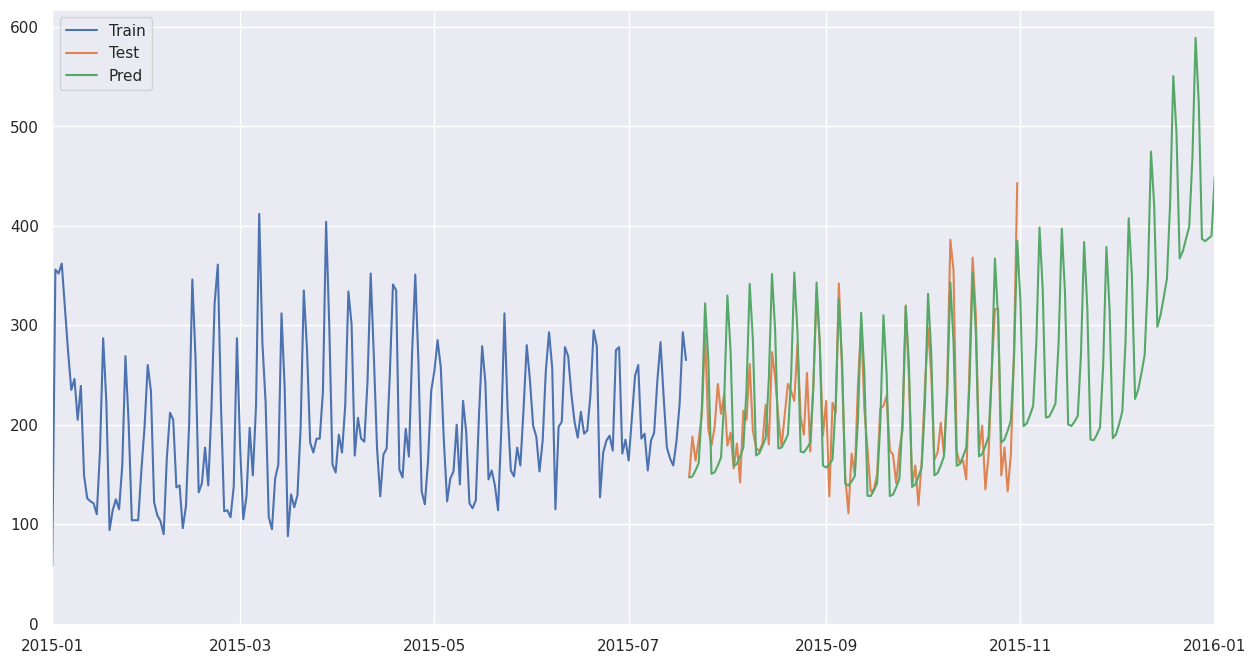

In [155]:
plot_forecast(prophet_cats_id_sales['40'], left='2015-01', right='2016-01')

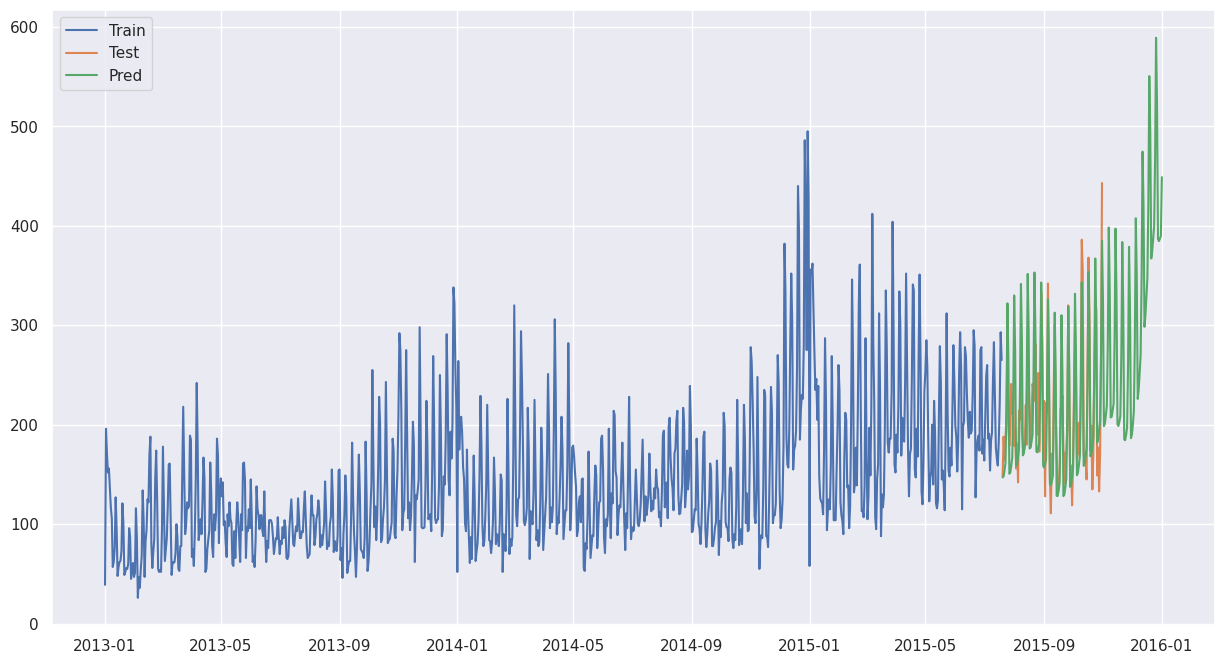

In [156]:
plot_forecast(prophet_cats_id_sales['40'])

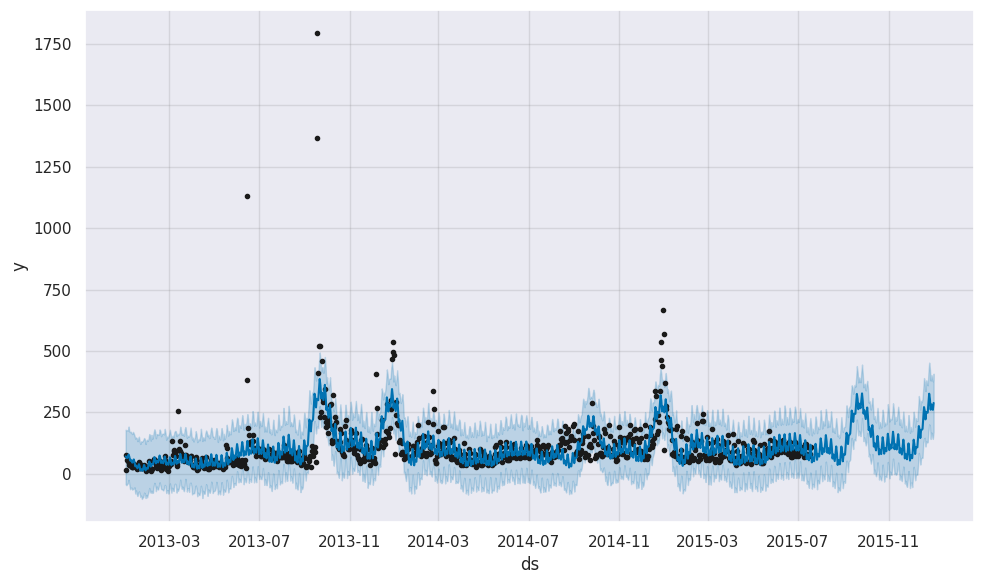

In [158]:
prophet_cats_id_sales['19']['model'].plot(prophet_cats_id_sales['19']['forecast']);

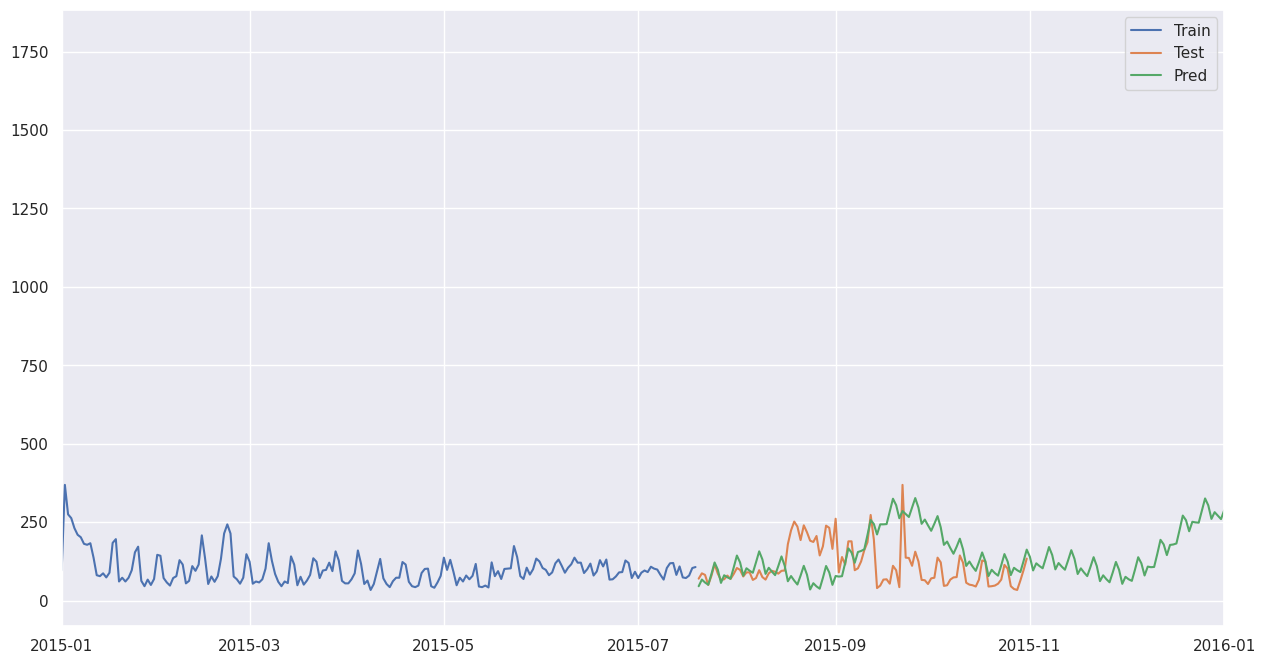

In [159]:
plot_forecast(prophet_cats_id_sales['19'], left='2015-01', right='2016-01')

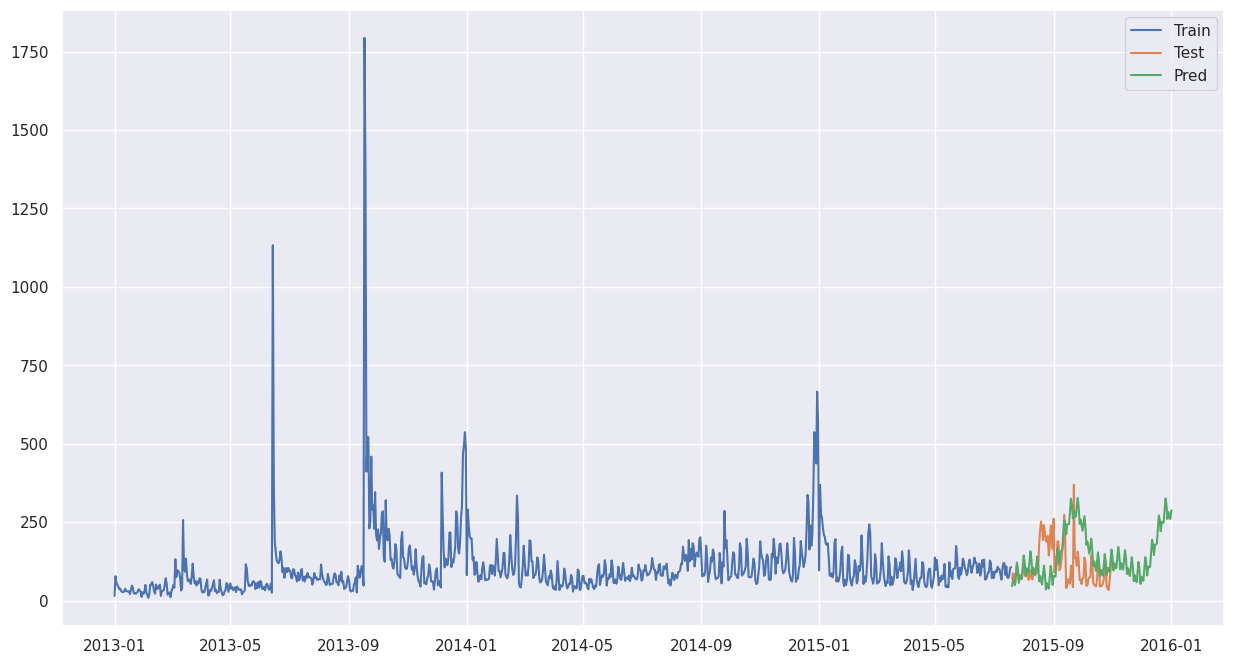

In [160]:
plot_forecast(prophet_cats_id_sales['19'])

### Values

In [162]:
%%time
# initialize model for each category id
prophet_cats_id_values = run_load_model(
    df=cats_values,
    load=True,
    model_name="prophet_cats_id_values",
    freq=freq_analysis)

=== START LOADING ===
=== MODEL LOADED ===
CPU times: user 1.62 s, sys: 7.89 ms, total: 1.63 s
Wall time: 1.63 s


In [163]:
# get the prediction for "only" the next month for every category
cats_id_values_pred = {}
for cat in prophet_cats_id_values:
    pred = prophet_cats_id_values[cat]
    pred = get_forecast_data(pred)
    cats_id_values_pred[cat] = pred['month']['yhat'][0]

<font size="5"> Total Values for next month, sun of all categories </font>

In [164]:
all_cats_id_values_pred = sum(list(cats_id_values_pred.values())).round(2)
all_cats_id_values_pred

118561327.57

#### Save the data (on raw_data) and model (on git) in json file

In [ ]:
save_model_data(prophet_cats_id_values, 'prophet_cats_id_values', save=True)

#### Plot Example

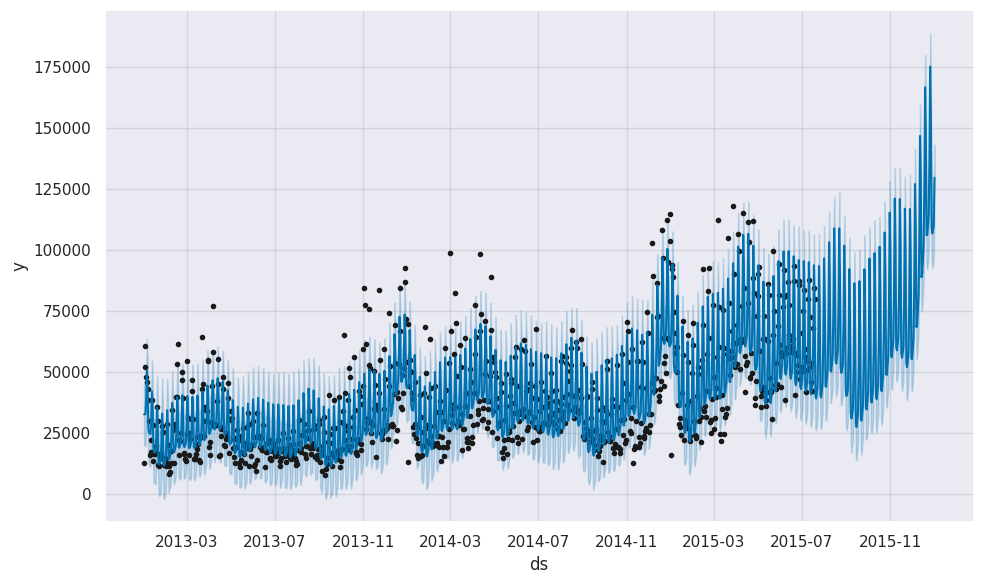

In [171]:
prophet_cats_id_values['40']['model'].plot(prophet_cats_id_values['40']['forecast']);

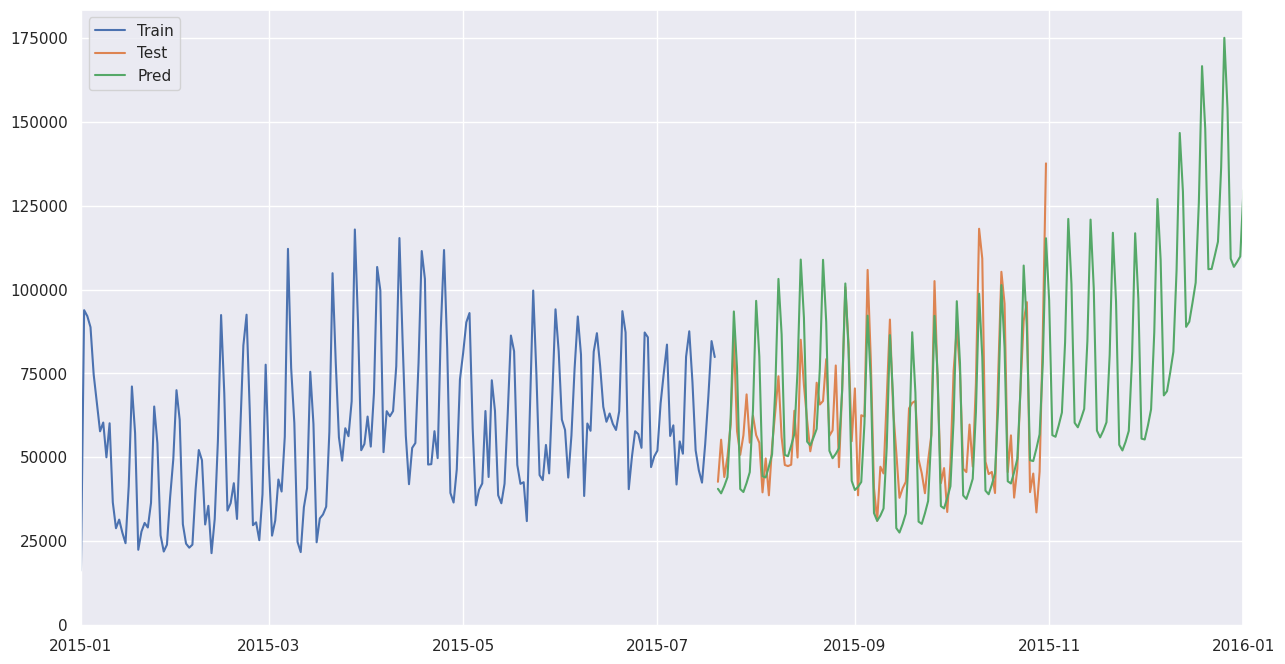

In [166]:
plot_forecast(prophet_cats_id_values['40'], left='2015-01', right='2016-01')

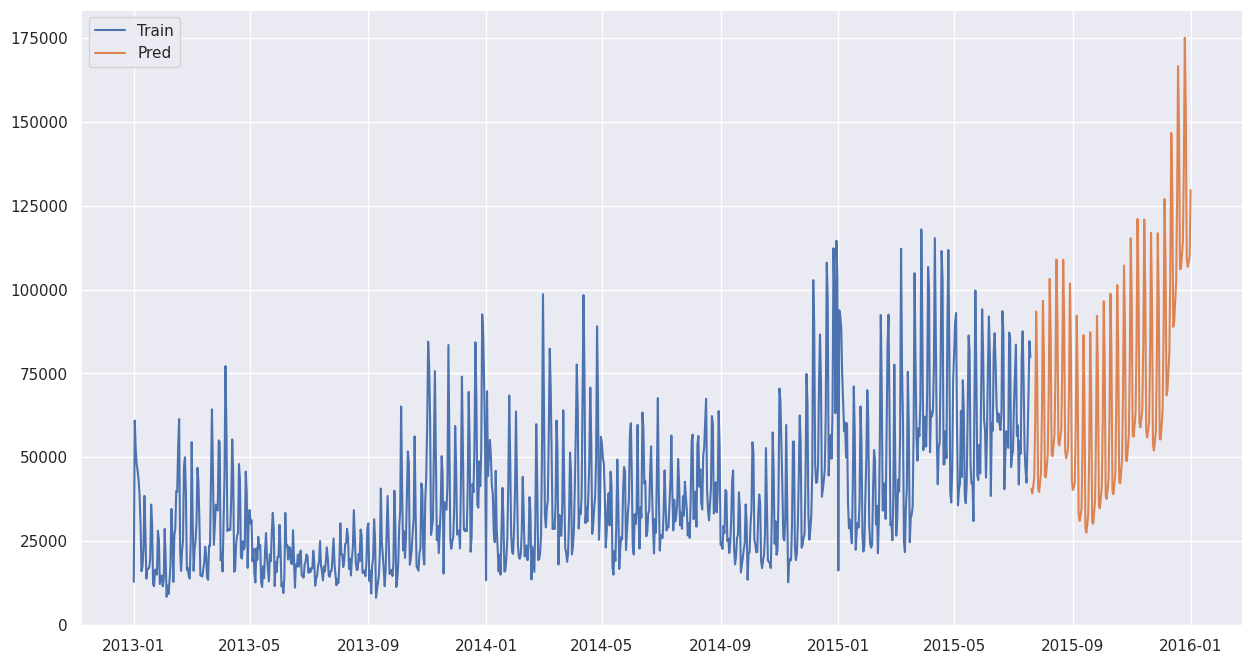

In [167]:
plot_forecast(prophet_cats_id_values['40'], test=False)

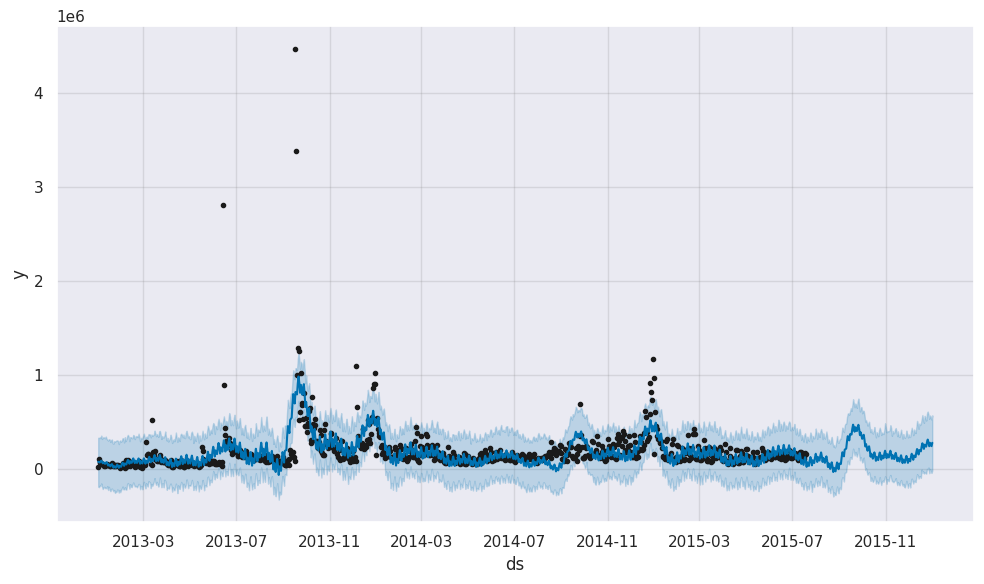

In [168]:
prophet_cats_id_values['19']['model'].plot(prophet_cats_id_values['19']['forecast']);

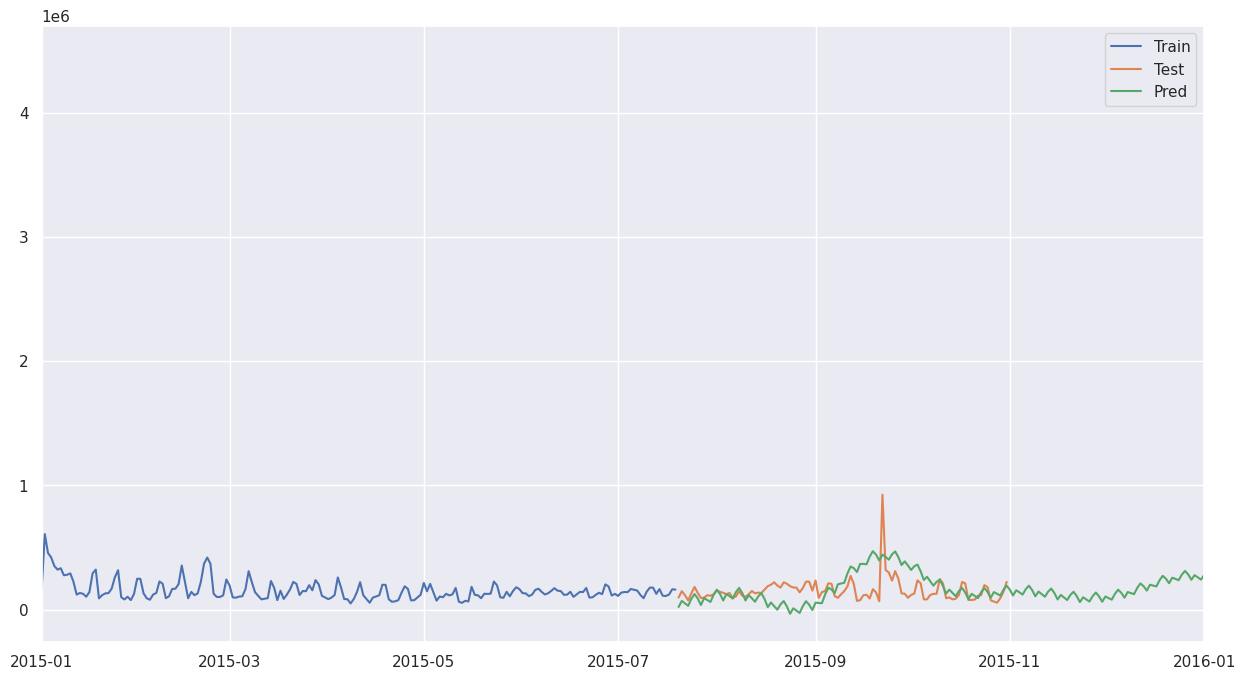

In [169]:
plot_forecast(prophet_cats_id_values['19'], left='2015-01', right='2016-01')

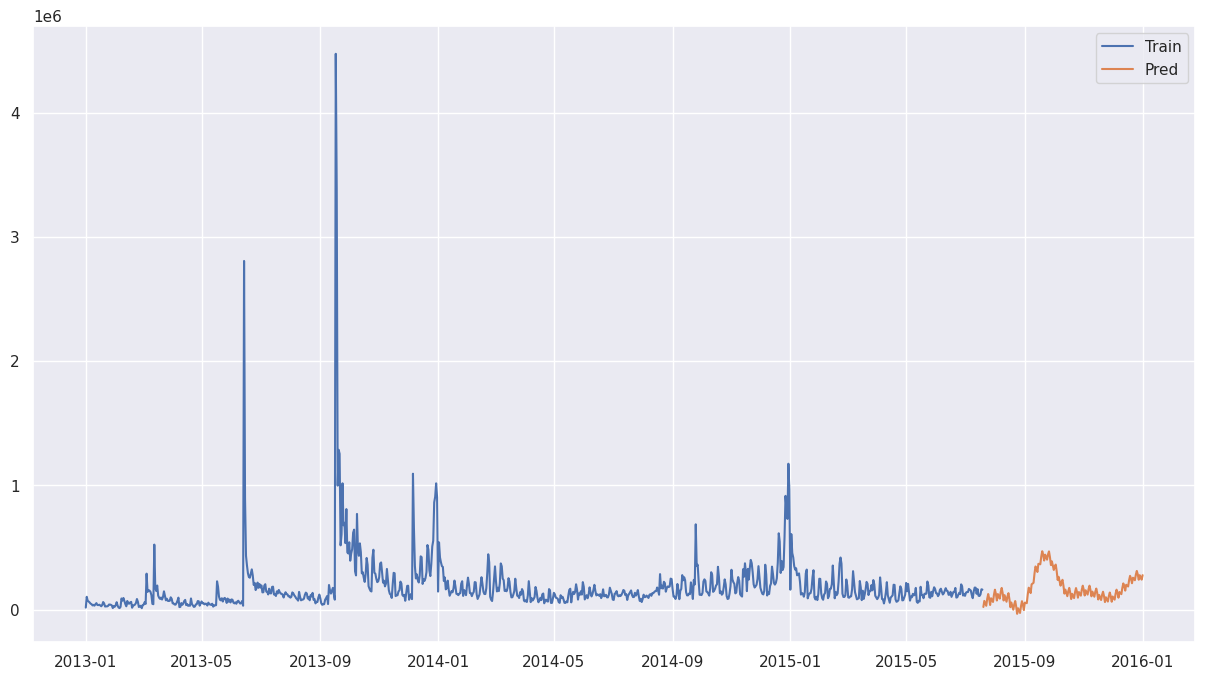

In [170]:
plot_forecast(prophet_cats_id_values['19'], test=False)

## Item Prediction

### Sales

In [61]:
%%time
# initialize model for each category id
prophet_items_id_sales = run_load_model(
    df=items_sales,
    load=False,
    model_name="prophet_items_id_sales",
    freq=freq_analysis)

=== Running Prophet Model from Scratch ===


18:36:06 - cmdstanpy - INFO - Chain [1] start processing
18:36:06 - cmdstanpy - INFO - Chain [1] start processing
18:36:06 - cmdstanpy - INFO - Chain [1] start processing
18:36:06 - cmdstanpy - INFO - Chain [1] start processing
18:36:06 - cmdstanpy - INFO - Chain [1] done processing
18:36:06 - cmdstanpy - INFO - Chain [1] start processing
18:36:06 - cmdstanpy - INFO - Chain [1] start processing
18:36:06 - cmdstanpy - INFO - Chain [1] done processing
18:36:07 - cmdstanpy - INFO - Chain [1] done processing
18:36:07 - cmdstanpy - INFO - Chain [1] done processing
18:36:07 - cmdstanpy - INFO - Chain [1] done processing
18:36:07 - cmdstanpy - INFO - Chain [1] done processing
18:36:07 - cmdstanpy - INFO - Chain [1] start processing
18:36:07 - cmdstanpy - INFO - Chain [1] start processing
18:36:08 - cmdstanpy - INFO - Chain [1] start processing
18:36:08 - cmdstanpy - INFO - Chain [1] start processing
18:36:08 - cmdstanpy - INFO - Chain [1] start processing
18:36:08 - cmdstanpy - INFO - Chain [

18:36:18 - cmdstanpy - INFO - Chain [1] done processing
18:36:18 - cmdstanpy - INFO - Chain [1] start processing
18:36:19 - cmdstanpy - INFO - Chain [1] start processing
18:36:19 - cmdstanpy - INFO - Chain [1] done processing
18:36:19 - cmdstanpy - INFO - Chain [1] start processing
18:36:19 - cmdstanpy - INFO - Chain [1] start processing
18:36:19 - cmdstanpy - INFO - Chain [1] done processing
18:36:19 - cmdstanpy - INFO - Chain [1] done processing
18:36:19 - cmdstanpy - INFO - Chain [1] start processing
18:36:19 - cmdstanpy - INFO - Chain [1] start processing
18:36:19 - cmdstanpy - INFO - Chain [1] done processing
18:36:19 - cmdstanpy - INFO - Chain [1] start processing
18:36:19 - cmdstanpy - INFO - Chain [1] done processing
18:36:19 - cmdstanpy - INFO - Chain [1] done processing
18:36:19 - cmdstanpy - INFO - Chain [1] done processing
18:36:20 - cmdstanpy - INFO - Chain [1] start processing
18:36:20 - cmdstanpy - INFO - Chain [1] start processing
18:36:20 - cmdstanpy - INFO - Chain [1]

18:36:31 - cmdstanpy - INFO - Chain [1] start processing
18:36:31 - cmdstanpy - INFO - Chain [1] done processing
18:36:31 - cmdstanpy - INFO - Chain [1] start processing
18:36:32 - cmdstanpy - INFO - Chain [1] start processing
18:36:31 - cmdstanpy - INFO - Chain [1] start processing
18:36:32 - cmdstanpy - INFO - Chain [1] done processing
18:36:32 - cmdstanpy - INFO - Chain [1] start processing
18:36:32 - cmdstanpy - INFO - Chain [1] done processing
18:36:32 - cmdstanpy - INFO - Chain [1] done processing
18:36:32 - cmdstanpy - INFO - Chain [1] done processing
18:36:32 - cmdstanpy - INFO - Chain [1] done processing
18:36:32 - cmdstanpy - INFO - Chain [1] start processing
18:36:32 - cmdstanpy - INFO - Chain [1] start processing
18:36:32 - cmdstanpy - INFO - Chain [1] done processing
18:36:32 - cmdstanpy - INFO - Chain [1] start processing
18:36:33 - cmdstanpy - INFO - Chain [1] start processing
18:36:33 - cmdstanpy - INFO - Chain [1] done processing
18:36:33 - cmdstanpy - INFO - Chain [1]

18:36:45 - cmdstanpy - INFO - Chain [1] start processing
18:36:46 - cmdstanpy - INFO - Chain [1] start processing
18:36:46 - cmdstanpy - INFO - Chain [1] done processing
18:36:46 - cmdstanpy - INFO - Chain [1] start processing
18:36:46 - cmdstanpy - INFO - Chain [1] done processing
18:36:46 - cmdstanpy - INFO - Chain [1] start processing
18:36:46 - cmdstanpy - INFO - Chain [1] start processing
18:36:46 - cmdstanpy - INFO - Chain [1] done processing
18:36:46 - cmdstanpy - INFO - Chain [1] done processing
18:36:46 - cmdstanpy - INFO - Chain [1] done processing
18:36:46 - cmdstanpy - INFO - Chain [1] done processing
18:36:46 - cmdstanpy - INFO - Chain [1] start processing
18:36:47 - cmdstanpy - INFO - Chain [1] start processing
18:36:47 - cmdstanpy - INFO - Chain [1] done processing
18:36:47 - cmdstanpy - INFO - Chain [1] done processing
18:36:47 - cmdstanpy - INFO - Chain [1] start processing
18:36:47 - cmdstanpy - INFO - Chain [1] start processing
18:36:47 - cmdstanpy - INFO - Chain [1]

18:37:02 - cmdstanpy - INFO - Chain [1] done processing
18:37:02 - cmdstanpy - INFO - Chain [1] start processing
18:37:02 - cmdstanpy - INFO - Chain [1] done processing
18:37:02 - cmdstanpy - INFO - Chain [1] start processing
18:37:02 - cmdstanpy - INFO - Chain [1] done processing
18:37:02 - cmdstanpy - INFO - Chain [1] done processing
18:37:02 - cmdstanpy - INFO - Chain [1] done processing
18:37:03 - cmdstanpy - INFO - Chain [1] start processing
18:37:03 - cmdstanpy - INFO - Chain [1] done processing
18:37:03 - cmdstanpy - INFO - Chain [1] start processing
18:37:03 - cmdstanpy - INFO - Chain [1] start processing
18:37:03 - cmdstanpy - INFO - Chain [1] start processing
18:37:03 - cmdstanpy - INFO - Chain [1] start processing
18:37:03 - cmdstanpy - INFO - Chain [1] done processing
18:37:03 - cmdstanpy - INFO - Chain [1] start processing
18:37:03 - cmdstanpy - INFO - Chain [1] done processing
18:37:04 - cmdstanpy - INFO - Chain [1] done processing
18:37:04 - cmdstanpy - INFO - Chain [1] 

18:37:17 - cmdstanpy - INFO - Chain [1] done processing
18:37:17 - cmdstanpy - INFO - Chain [1] start processing
18:37:17 - cmdstanpy - INFO - Chain [1] start processing
18:37:17 - cmdstanpy - INFO - Chain [1] start processing
18:37:17 - cmdstanpy - INFO - Chain [1] start processing
18:37:17 - cmdstanpy - INFO - Chain [1] done processing
18:37:17 - cmdstanpy - INFO - Chain [1] done processing
18:37:17 - cmdstanpy - INFO - Chain [1] done processing
18:37:17 - cmdstanpy - INFO - Chain [1] done processing
18:37:18 - cmdstanpy - INFO - Chain [1] start processing
18:37:18 - cmdstanpy - INFO - Chain [1] done processing
18:37:18 - cmdstanpy - INFO - Chain [1] start processing
18:37:18 - cmdstanpy - INFO - Chain [1] start processing
18:37:18 - cmdstanpy - INFO - Chain [1] start processing
18:37:18 - cmdstanpy - INFO - Chain [1] done processing
18:37:18 - cmdstanpy - INFO - Chain [1] done processing
18:37:18 - cmdstanpy - INFO - Chain [1] done processing
18:37:18 - cmdstanpy - INFO - Chain [1] 

18:37:32 - cmdstanpy - INFO - Chain [1] start processing
18:37:32 - cmdstanpy - INFO - Chain [1] done processing
18:37:32 - cmdstanpy - INFO - Chain [1] done processing
18:37:32 - cmdstanpy - INFO - Chain [1] done processing
18:37:32 - cmdstanpy - INFO - Chain [1] start processing
18:37:33 - cmdstanpy - INFO - Chain [1] start processing
18:37:33 - cmdstanpy - INFO - Chain [1] start processing
18:37:33 - cmdstanpy - INFO - Chain [1] done processing
18:37:33 - cmdstanpy - INFO - Chain [1] done processing
18:37:33 - cmdstanpy - INFO - Chain [1] done processing
18:37:33 - cmdstanpy - INFO - Chain [1] start processing
18:37:33 - cmdstanpy - INFO - Chain [1] done processing
18:37:33 - cmdstanpy - INFO - Chain [1] start processing
18:37:33 - cmdstanpy - INFO - Chain [1] start processing
18:37:34 - cmdstanpy - INFO - Chain [1] done processing
18:37:34 - cmdstanpy - INFO - Chain [1] start processing
18:37:34 - cmdstanpy - INFO - Chain [1] done processing
18:37:34 - cmdstanpy - INFO - Chain [1] 

18:37:47 - cmdstanpy - INFO - Chain [1] start processing
18:37:47 - cmdstanpy - INFO - Chain [1] done processing
18:37:47 - cmdstanpy - INFO - Chain [1] done processing
18:37:47 - cmdstanpy - INFO - Chain [1] start processing
18:37:47 - cmdstanpy - INFO - Chain [1] start processing
18:37:48 - cmdstanpy - INFO - Chain [1] done processing
18:37:48 - cmdstanpy - INFO - Chain [1] done processing
18:37:48 - cmdstanpy - INFO - Chain [1] start processing
18:37:48 - cmdstanpy - INFO - Chain [1] done processing
18:37:48 - cmdstanpy - INFO - Chain [1] done processing
18:37:49 - cmdstanpy - INFO - Chain [1] start processing
18:37:49 - cmdstanpy - INFO - Chain [1] start processing
18:37:49 - cmdstanpy - INFO - Chain [1] done processing
18:37:49 - cmdstanpy - INFO - Chain [1] start processing
18:37:49 - cmdstanpy - INFO - Chain [1] done processing
18:37:49 - cmdstanpy - INFO - Chain [1] start processing
18:37:49 - cmdstanpy - INFO - Chain [1] done processing
18:37:49 - cmdstanpy - INFO - Chain [1] 

18:38:04 - cmdstanpy - INFO - Chain [1] start processing
18:38:04 - cmdstanpy - INFO - Chain [1] done processing
18:38:04 - cmdstanpy - INFO - Chain [1] start processing
18:38:04 - cmdstanpy - INFO - Chain [1] start processing
18:38:04 - cmdstanpy - INFO - Chain [1] start processing
18:38:05 - cmdstanpy - INFO - Chain [1] done processing
18:38:05 - cmdstanpy - INFO - Chain [1] done processing
18:38:05 - cmdstanpy - INFO - Chain [1] start processing
18:38:05 - cmdstanpy - INFO - Chain [1] done processing
18:38:05 - cmdstanpy - INFO - Chain [1] start processing
18:38:05 - cmdstanpy - INFO - Chain [1] start processing
18:38:05 - cmdstanpy - INFO - Chain [1] start processing
18:38:05 - cmdstanpy - INFO - Chain [1] done processing
18:38:05 - cmdstanpy - INFO - Chain [1] done processing
18:38:05 - cmdstanpy - INFO - Chain [1] done processing
18:38:05 - cmdstanpy - INFO - Chain [1] done processing
18:38:06 - cmdstanpy - INFO - Chain [1] start processing
18:38:06 - cmdstanpy - INFO - Chain [1]

18:38:19 - cmdstanpy - INFO - Chain [1] start processing
18:38:19 - cmdstanpy - INFO - Chain [1] done processing
18:38:19 - cmdstanpy - INFO - Chain [1] done processing
18:38:19 - cmdstanpy - INFO - Chain [1] done processing
18:38:19 - cmdstanpy - INFO - Chain [1] done processing
18:38:19 - cmdstanpy - INFO - Chain [1] start processing
18:38:19 - cmdstanpy - INFO - Chain [1] done processing
18:38:20 - cmdstanpy - INFO - Chain [1] start processing
18:38:20 - cmdstanpy - INFO - Chain [1] start processing
18:38:20 - cmdstanpy - INFO - Chain [1] start processing
18:38:20 - cmdstanpy - INFO - Chain [1] done processing
18:38:20 - cmdstanpy - INFO - Chain [1] done processing
18:38:20 - cmdstanpy - INFO - Chain [1] done processing
18:38:20 - cmdstanpy - INFO - Chain [1] start processing
18:38:20 - cmdstanpy - INFO - Chain [1] start processing
18:38:20 - cmdstanpy - INFO - Chain [1] done processing
18:38:20 - cmdstanpy - INFO - Chain [1] start processing
18:38:20 - cmdstanpy - INFO - Chain [1] 

18:38:34 - cmdstanpy - INFO - Chain [1] done processing
18:38:34 - cmdstanpy - INFO - Chain [1] done processing
18:38:34 - cmdstanpy - INFO - Chain [1] done processing
18:38:34 - cmdstanpy - INFO - Chain [1] start processing
18:38:34 - cmdstanpy - INFO - Chain [1] done processing
18:38:35 - cmdstanpy - INFO - Chain [1] done processing
18:38:35 - cmdstanpy - INFO - Chain [1] start processing
18:38:35 - cmdstanpy - INFO - Chain [1] done processing
18:38:35 - cmdstanpy - INFO - Chain [1] start processing
18:38:35 - cmdstanpy - INFO - Chain [1] start processing
18:38:35 - cmdstanpy - INFO - Chain [1] start processing
18:38:35 - cmdstanpy - INFO - Chain [1] start processing
18:38:35 - cmdstanpy - INFO - Chain [1] done processing
18:38:35 - cmdstanpy - INFO - Chain [1] done processing
18:38:35 - cmdstanpy - INFO - Chain [1] start processing
18:38:35 - cmdstanpy - INFO - Chain [1] done processing
18:38:35 - cmdstanpy - INFO - Chain [1] done processing
18:38:36 - cmdstanpy - INFO - Chain [1] s

18:38:48 - cmdstanpy - INFO - Chain [1] done processing
18:38:48 - cmdstanpy - INFO - Chain [1] start processing
18:38:48 - cmdstanpy - INFO - Chain [1] start processing
18:38:49 - cmdstanpy - INFO - Chain [1] start processing
18:38:49 - cmdstanpy - INFO - Chain [1] start processing
18:38:49 - cmdstanpy - INFO - Chain [1] done processing
18:38:49 - cmdstanpy - INFO - Chain [1] start processing
18:38:49 - cmdstanpy - INFO - Chain [1] done processing
18:38:49 - cmdstanpy - INFO - Chain [1] done processing
18:38:49 - cmdstanpy - INFO - Chain [1] start processing
18:38:49 - cmdstanpy - INFO - Chain [1] done processing
18:38:49 - cmdstanpy - INFO - Chain [1] done processing
18:38:49 - cmdstanpy - INFO - Chain [1] start processing
18:38:50 - cmdstanpy - INFO - Chain [1] done processing
18:38:50 - cmdstanpy - INFO - Chain [1] start processing
18:38:50 - cmdstanpy - INFO - Chain [1] start processing
18:38:50 - cmdstanpy - INFO - Chain [1] start processing
18:38:50 - cmdstanpy - INFO - Chain [1

18:39:03 - cmdstanpy - INFO - Chain [1] start processing
18:39:03 - cmdstanpy - INFO - Chain [1] done processing
18:39:04 - cmdstanpy - INFO - Chain [1] start processing
18:39:04 - cmdstanpy - INFO - Chain [1] done processing
18:39:04 - cmdstanpy - INFO - Chain [1] done processing
18:39:04 - cmdstanpy - INFO - Chain [1] start processing
18:39:04 - cmdstanpy - INFO - Chain [1] done processing
18:39:04 - cmdstanpy - INFO - Chain [1] start processing
18:39:04 - cmdstanpy - INFO - Chain [1] done processing
18:39:04 - cmdstanpy - INFO - Chain [1] done processing
18:39:04 - cmdstanpy - INFO - Chain [1] start processing
18:39:04 - cmdstanpy - INFO - Chain [1] start processing
18:39:04 - cmdstanpy - INFO - Chain [1] start processing
18:39:05 - cmdstanpy - INFO - Chain [1] done processing
18:39:05 - cmdstanpy - INFO - Chain [1] done processing
18:39:05 - cmdstanpy - INFO - Chain [1] start processing
18:39:05 - cmdstanpy - INFO - Chain [1] done processing
18:39:05 - cmdstanpy - INFO - Chain [1] 

18:39:18 - cmdstanpy - INFO - Chain [1] start processing
18:39:18 - cmdstanpy - INFO - Chain [1] start processing
18:39:18 - cmdstanpy - INFO - Chain [1] done processing
18:39:18 - cmdstanpy - INFO - Chain [1] start processing
18:39:18 - cmdstanpy - INFO - Chain [1] start processing
18:39:18 - cmdstanpy - INFO - Chain [1] start processing
18:39:19 - cmdstanpy - INFO - Chain [1] done processing
18:39:19 - cmdstanpy - INFO - Chain [1] done processing
18:39:19 - cmdstanpy - INFO - Chain [1] done processing
18:39:19 - cmdstanpy - INFO - Chain [1] done processing
18:39:19 - cmdstanpy - INFO - Chain [1] start processing
18:39:19 - cmdstanpy - INFO - Chain [1] start processing
18:39:19 - cmdstanpy - INFO - Chain [1] start processing
18:39:19 - cmdstanpy - INFO - Chain [1] done processing
18:39:19 - cmdstanpy - INFO - Chain [1] done processing
18:39:19 - cmdstanpy - INFO - Chain [1] done processing
18:39:20 - cmdstanpy - INFO - Chain [1] start processing
18:39:20 - cmdstanpy - INFO - Chain [1]

18:39:36 - cmdstanpy - INFO - Chain [1] start processing
18:39:36 - cmdstanpy - INFO - Chain [1] start processing
18:39:36 - cmdstanpy - INFO - Chain [1] done processing
18:39:36 - cmdstanpy - INFO - Chain [1] done processing
18:39:36 - cmdstanpy - INFO - Chain [1] done processing
18:39:37 - cmdstanpy - INFO - Chain [1] start processing
18:39:37 - cmdstanpy - INFO - Chain [1] start processing
18:39:37 - cmdstanpy - INFO - Chain [1] start processing
18:39:37 - cmdstanpy - INFO - Chain [1] start processing
18:39:37 - cmdstanpy - INFO - Chain [1] done processing
18:39:37 - cmdstanpy - INFO - Chain [1] start processing
18:39:37 - cmdstanpy - INFO - Chain [1] done processing
18:39:37 - cmdstanpy - INFO - Chain [1] done processing
18:39:37 - cmdstanpy - INFO - Chain [1] done processing
18:39:37 - cmdstanpy - INFO - Chain [1] done processing
18:39:37 - cmdstanpy - INFO - Chain [1] start processing
18:39:37 - cmdstanpy - INFO - Chain [1] start processing
18:39:38 - cmdstanpy - INFO - Chain [1]

18:39:52 - cmdstanpy - INFO - Chain [1] start processing
18:39:52 - cmdstanpy - INFO - Chain [1] start processing
18:39:52 - cmdstanpy - INFO - Chain [1] done processing
18:39:52 - cmdstanpy - INFO - Chain [1] start processing
18:39:52 - cmdstanpy - INFO - Chain [1] done processing
18:39:52 - cmdstanpy - INFO - Chain [1] done processing
18:39:53 - cmdstanpy - INFO - Chain [1] done processing
18:39:53 - cmdstanpy - INFO - Chain [1] start processing
18:39:53 - cmdstanpy - INFO - Chain [1] start processing
18:39:53 - cmdstanpy - INFO - Chain [1] done processing
18:39:53 - cmdstanpy - INFO - Chain [1] start processing
18:39:53 - cmdstanpy - INFO - Chain [1] done processing
18:39:54 - cmdstanpy - INFO - Chain [1] start processing
18:39:54 - cmdstanpy - INFO - Chain [1] start processing
18:39:54 - cmdstanpy - INFO - Chain [1] start processing
18:39:54 - cmdstanpy - INFO - Chain [1] done processing
18:39:54 - cmdstanpy - INFO - Chain [1] done processing
18:39:54 - cmdstanpy - INFO - Chain [1]

18:40:08 - cmdstanpy - INFO - Chain [1] done processing
18:40:09 - cmdstanpy - INFO - Chain [1] done processing
18:40:09 - cmdstanpy - INFO - Chain [1] start processing
18:40:09 - cmdstanpy - INFO - Chain [1] start processing
18:40:09 - cmdstanpy - INFO - Chain [1] done processing
18:40:09 - cmdstanpy - INFO - Chain [1] start processing
18:40:09 - cmdstanpy - INFO - Chain [1] done processing
18:40:09 - cmdstanpy - INFO - Chain [1] start processing
18:40:09 - cmdstanpy - INFO - Chain [1] done processing
18:40:10 - cmdstanpy - INFO - Chain [1] done processing
18:40:10 - cmdstanpy - INFO - Chain [1] start processing
18:40:10 - cmdstanpy - INFO - Chain [1] start processing
18:40:10 - cmdstanpy - INFO - Chain [1] start processing
18:40:10 - cmdstanpy - INFO - Chain [1] done processing
18:40:10 - cmdstanpy - INFO - Chain [1] done processing
18:40:10 - cmdstanpy - INFO - Chain [1] done processing
18:40:10 - cmdstanpy - INFO - Chain [1] start processing
18:40:10 - cmdstanpy - INFO - Chain [1] 

18:40:24 - cmdstanpy - INFO - Chain [1] done processing
18:40:24 - cmdstanpy - INFO - Chain [1] start processing
18:40:24 - cmdstanpy - INFO - Chain [1] start processing
18:40:24 - cmdstanpy - INFO - Chain [1] start processing
18:40:24 - cmdstanpy - INFO - Chain [1] start processing
18:40:24 - cmdstanpy - INFO - Chain [1] done processing
18:40:24 - cmdstanpy - INFO - Chain [1] done processing
18:40:24 - cmdstanpy - INFO - Chain [1] start processing
18:40:24 - cmdstanpy - INFO - Chain [1] done processing
18:40:24 - cmdstanpy - INFO - Chain [1] done processing
18:40:25 - cmdstanpy - INFO - Chain [1] done processing
18:40:25 - cmdstanpy - INFO - Chain [1] start processing
18:40:25 - cmdstanpy - INFO - Chain [1] done processing
18:40:25 - cmdstanpy - INFO - Chain [1] start processing
18:40:25 - cmdstanpy - INFO - Chain [1] start processing
18:40:25 - cmdstanpy - INFO - Chain [1] start processing
18:40:25 - cmdstanpy - INFO - Chain [1] start processing
18:40:26 - cmdstanpy - INFO - Chain [1

18:40:39 - cmdstanpy - INFO - Chain [1] done processing
18:40:39 - cmdstanpy - INFO - Chain [1] done processing
18:40:39 - cmdstanpy - INFO - Chain [1] start processing
18:40:39 - cmdstanpy - INFO - Chain [1] start processing
18:40:39 - cmdstanpy - INFO - Chain [1] start processing
18:40:40 - cmdstanpy - INFO - Chain [1] start processing
18:40:40 - cmdstanpy - INFO - Chain [1] done processing
18:40:40 - cmdstanpy - INFO - Chain [1] done processing
18:40:40 - cmdstanpy - INFO - Chain [1] done processing
18:40:40 - cmdstanpy - INFO - Chain [1] start processing
18:40:40 - cmdstanpy - INFO - Chain [1] start processing
18:40:40 - cmdstanpy - INFO - Chain [1] done processing
18:40:40 - cmdstanpy - INFO - Chain [1] done processing
18:40:40 - cmdstanpy - INFO - Chain [1] start processing
18:40:40 - cmdstanpy - INFO - Chain [1] done processing
18:40:40 - cmdstanpy - INFO - Chain [1] start processing
18:40:40 - cmdstanpy - INFO - Chain [1] done processing
18:40:41 - cmdstanpy - INFO - Chain [1] 

18:40:55 - cmdstanpy - INFO - Chain [1] start processing
18:40:55 - cmdstanpy - INFO - Chain [1] start processing
18:40:55 - cmdstanpy - INFO - Chain [1] done processing
18:40:55 - cmdstanpy - INFO - Chain [1] start processing
18:40:55 - cmdstanpy - INFO - Chain [1] done processing
18:40:55 - cmdstanpy - INFO - Chain [1] done processing
18:40:56 - cmdstanpy - INFO - Chain [1] done processing
18:40:56 - cmdstanpy - INFO - Chain [1] done processing
18:40:56 - cmdstanpy - INFO - Chain [1] start processing
18:40:56 - cmdstanpy - INFO - Chain [1] done processing
18:40:57 - cmdstanpy - INFO - Chain [1] start processing
18:40:57 - cmdstanpy - INFO - Chain [1] start processing
18:40:57 - cmdstanpy - INFO - Chain [1] start processing
18:40:57 - cmdstanpy - INFO - Chain [1] done processing
18:40:57 - cmdstanpy - INFO - Chain [1] done processing
18:40:57 - cmdstanpy - INFO - Chain [1] start processing
18:40:57 - cmdstanpy - INFO - Chain [1] start processing
18:40:57 - cmdstanpy - INFO - Chain [1]

18:41:12 - cmdstanpy - INFO - Chain [1] done processing
18:41:12 - cmdstanpy - INFO - Chain [1] done processing
18:41:12 - cmdstanpy - INFO - Chain [1] start processing
18:41:12 - cmdstanpy - INFO - Chain [1] done processing
18:41:12 - cmdstanpy - INFO - Chain [1] start processing
18:41:12 - cmdstanpy - INFO - Chain [1] done processing
18:41:12 - cmdstanpy - INFO - Chain [1] done processing
18:41:13 - cmdstanpy - INFO - Chain [1] start processing
18:41:13 - cmdstanpy - INFO - Chain [1] start processing
18:41:13 - cmdstanpy - INFO - Chain [1] start processing
18:41:13 - cmdstanpy - INFO - Chain [1] start processing
18:41:13 - cmdstanpy - INFO - Chain [1] done processing
18:41:13 - cmdstanpy - INFO - Chain [1] done processing
18:41:13 - cmdstanpy - INFO - Chain [1] start processing
18:41:14 - cmdstanpy - INFO - Chain [1] start processing
18:41:14 - cmdstanpy - INFO - Chain [1] done processing
18:41:14 - cmdstanpy - INFO - Chain [1] done processing
18:41:14 - cmdstanpy - INFO - Chain [1] 

18:41:27 - cmdstanpy - INFO - Chain [1] start processing
18:41:27 - cmdstanpy - INFO - Chain [1] done processing
18:41:27 - cmdstanpy - INFO - Chain [1] done processing
18:41:27 - cmdstanpy - INFO - Chain [1] done processing
18:41:27 - cmdstanpy - INFO - Chain [1] done processing
18:41:27 - cmdstanpy - INFO - Chain [1] done processing
18:41:27 - cmdstanpy - INFO - Chain [1] start processing
18:41:27 - cmdstanpy - INFO - Chain [1] start processing
18:41:27 - cmdstanpy - INFO - Chain [1] done processing
18:41:27 - cmdstanpy - INFO - Chain [1] done processing
18:41:28 - cmdstanpy - INFO - Chain [1] start processing
18:41:28 - cmdstanpy - INFO - Chain [1] start processing
18:41:28 - cmdstanpy - INFO - Chain [1] start processing
18:41:28 - cmdstanpy - INFO - Chain [1] start processing
18:41:28 - cmdstanpy - INFO - Chain [1] done processing
18:41:28 - cmdstanpy - INFO - Chain [1] start processing
18:41:28 - cmdstanpy - INFO - Chain [1] done processing
18:41:28 - cmdstanpy - INFO - Chain [1] 

18:41:42 - cmdstanpy - INFO - Chain [1] start processing
18:41:42 - cmdstanpy - INFO - Chain [1] start processing
18:41:42 - cmdstanpy - INFO - Chain [1] start processing
18:41:42 - cmdstanpy - INFO - Chain [1] done processing
18:41:42 - cmdstanpy - INFO - Chain [1] done processing
18:41:42 - cmdstanpy - INFO - Chain [1] done processing
18:41:42 - cmdstanpy - INFO - Chain [1] done processing
18:41:42 - cmdstanpy - INFO - Chain [1] start processing
18:41:42 - cmdstanpy - INFO - Chain [1] start processing
18:41:42 - cmdstanpy - INFO - Chain [1] done processing
18:41:42 - cmdstanpy - INFO - Chain [1] done processing
18:41:43 - cmdstanpy - INFO - Chain [1] done processing
18:41:43 - cmdstanpy - INFO - Chain [1] start processing
18:41:43 - cmdstanpy - INFO - Chain [1] start processing
18:41:43 - cmdstanpy - INFO - Chain [1] done processing
18:41:43 - cmdstanpy - INFO - Chain [1] done processing
18:41:43 - cmdstanpy - INFO - Chain [1] start processing
18:41:43 - cmdstanpy - INFO - Chain [1] 

18:41:57 - cmdstanpy - INFO - Chain [1] done processing
18:41:58 - cmdstanpy - INFO - Chain [1] start processing
18:41:58 - cmdstanpy - INFO - Chain [1] done processing
18:41:58 - cmdstanpy - INFO - Chain [1] start processing
18:41:58 - cmdstanpy - INFO - Chain [1] start processing
18:41:58 - cmdstanpy - INFO - Chain [1] done processing
18:41:58 - cmdstanpy - INFO - Chain [1] done processing
18:41:59 - cmdstanpy - INFO - Chain [1] done processing
18:41:59 - cmdstanpy - INFO - Chain [1] start processing
18:41:59 - cmdstanpy - INFO - Chain [1] done processing
18:41:59 - cmdstanpy - INFO - Chain [1] done processing
18:41:59 - cmdstanpy - INFO - Chain [1] start processing
18:41:59 - cmdstanpy - INFO - Chain [1] done processing
18:41:59 - cmdstanpy - INFO - Chain [1] start processing
18:42:00 - cmdstanpy - INFO - Chain [1] start processing
18:42:00 - cmdstanpy - INFO - Chain [1] done processing
18:42:00 - cmdstanpy - INFO - Chain [1] start processing
18:42:00 - cmdstanpy - INFO - Chain [1] 

18:42:13 - cmdstanpy - INFO - Chain [1] start processing
18:42:13 - cmdstanpy - INFO - Chain [1] start processing
18:42:13 - cmdstanpy - INFO - Chain [1] done processing
18:42:13 - cmdstanpy - INFO - Chain [1] start processing
18:42:13 - cmdstanpy - INFO - Chain [1] done processing
18:42:13 - cmdstanpy - INFO - Chain [1] done processing
18:42:13 - cmdstanpy - INFO - Chain [1] done processing
18:42:14 - cmdstanpy - INFO - Chain [1] start processing
18:42:14 - cmdstanpy - INFO - Chain [1] start processing
18:42:14 - cmdstanpy - INFO - Chain [1] start processing
18:42:14 - cmdstanpy - INFO - Chain [1] done processing
18:42:14 - cmdstanpy - INFO - Chain [1] done processing
18:42:14 - cmdstanpy - INFO - Chain [1] start processing
18:42:15 - cmdstanpy - INFO - Chain [1] start processing
18:42:15 - cmdstanpy - INFO - Chain [1] done processing
18:42:15 - cmdstanpy - INFO - Chain [1] start processing
18:42:15 - cmdstanpy - INFO - Chain [1] done processing
18:42:15 - cmdstanpy - INFO - Chain [1]

18:42:30 - cmdstanpy - INFO - Chain [1] done processing
18:42:30 - cmdstanpy - INFO - Chain [1] start processing
18:42:30 - cmdstanpy - INFO - Chain [1] done processing
18:42:30 - cmdstanpy - INFO - Chain [1] done processing
18:42:30 - cmdstanpy - INFO - Chain [1] start processing
18:42:31 - cmdstanpy - INFO - Chain [1] done processing
18:42:31 - cmdstanpy - INFO - Chain [1] start processing
18:42:31 - cmdstanpy - INFO - Chain [1] start processing
18:42:31 - cmdstanpy - INFO - Chain [1] start processing
18:42:31 - cmdstanpy - INFO - Chain [1] start processing
18:42:31 - cmdstanpy - INFO - Chain [1] done processing
18:42:31 - cmdstanpy - INFO - Chain [1] start processing
18:42:31 - cmdstanpy - INFO - Chain [1] done processing
18:42:31 - cmdstanpy - INFO - Chain [1] done processing
18:42:31 - cmdstanpy - INFO - Chain [1] done processing
18:42:32 - cmdstanpy - INFO - Chain [1] start processing
18:42:32 - cmdstanpy - INFO - Chain [1] start processing
18:42:32 - cmdstanpy - INFO - Chain [1]

18:42:46 - cmdstanpy - INFO - Chain [1] done processing
18:42:46 - cmdstanpy - INFO - Chain [1] start processing
18:42:46 - cmdstanpy - INFO - Chain [1] start processing
18:42:47 - cmdstanpy - INFO - Chain [1] start processing
18:42:47 - cmdstanpy - INFO - Chain [1] start processing
18:42:47 - cmdstanpy - INFO - Chain [1] done processing
18:42:47 - cmdstanpy - INFO - Chain [1] start processing
18:42:47 - cmdstanpy - INFO - Chain [1] start processing
18:42:47 - cmdstanpy - INFO - Chain [1] done processing
18:42:47 - cmdstanpy - INFO - Chain [1] done processing
18:42:47 - cmdstanpy - INFO - Chain [1] done processing
18:42:47 - cmdstanpy - INFO - Chain [1] done processing
18:42:47 - cmdstanpy - INFO - Chain [1] done processing
18:42:47 - cmdstanpy - INFO - Chain [1] start processing
18:42:48 - cmdstanpy - INFO - Chain [1] done processing
18:42:48 - cmdstanpy - INFO - Chain [1] start processing
18:42:48 - cmdstanpy - INFO - Chain [1] start processing
18:42:48 - cmdstanpy - INFO - Chain [1]

18:43:02 - cmdstanpy - INFO - Chain [1] start processing
18:43:02 - cmdstanpy - INFO - Chain [1] start processing
18:43:02 - cmdstanpy - INFO - Chain [1] start processing
18:43:02 - cmdstanpy - INFO - Chain [1] done processing
18:43:02 - cmdstanpy - INFO - Chain [1] start processing
18:43:02 - cmdstanpy - INFO - Chain [1] done processing
18:43:02 - cmdstanpy - INFO - Chain [1] start processing
18:43:02 - cmdstanpy - INFO - Chain [1] done processing
18:43:02 - cmdstanpy - INFO - Chain [1] done processing
18:43:02 - cmdstanpy - INFO - Chain [1] start processing
18:43:02 - cmdstanpy - INFO - Chain [1] done processing
18:43:03 - cmdstanpy - INFO - Chain [1] done processing
18:43:03 - cmdstanpy - INFO - Chain [1] start processing
18:43:03 - cmdstanpy - INFO - Chain [1] start processing
18:43:03 - cmdstanpy - INFO - Chain [1] start processing
18:43:03 - cmdstanpy - INFO - Chain [1] done processing
18:43:03 - cmdstanpy - INFO - Chain [1] start processing
18:43:03 - cmdstanpy - INFO - Chain [1

18:43:17 - cmdstanpy - INFO - Chain [1] done processing
18:43:17 - cmdstanpy - INFO - Chain [1] start processing
18:43:17 - cmdstanpy - INFO - Chain [1] start processing
18:43:17 - cmdstanpy - INFO - Chain [1] done processing
18:43:17 - cmdstanpy - INFO - Chain [1] done processing
18:43:18 - cmdstanpy - INFO - Chain [1] start processing
18:43:18 - cmdstanpy - INFO - Chain [1] start processing
18:43:18 - cmdstanpy - INFO - Chain [1] start processing
18:43:18 - cmdstanpy - INFO - Chain [1] start processing
18:43:18 - cmdstanpy - INFO - Chain [1] done processing
18:43:18 - cmdstanpy - INFO - Chain [1] done processing
18:43:18 - cmdstanpy - INFO - Chain [1] done processing
18:43:18 - cmdstanpy - INFO - Chain [1] done processing
18:43:19 - cmdstanpy - INFO - Chain [1] start processing
18:43:19 - cmdstanpy - INFO - Chain [1] done processing
18:43:19 - cmdstanpy - INFO - Chain [1] start processing
18:43:19 - cmdstanpy - INFO - Chain [1] start processing
18:43:19 - cmdstanpy - INFO - Chain [1]

18:43:34 - cmdstanpy - INFO - Chain [1] start processing
18:43:34 - cmdstanpy - INFO - Chain [1] done processing
18:43:34 - cmdstanpy - INFO - Chain [1] start processing
18:43:34 - cmdstanpy - INFO - Chain [1] done processing
18:43:35 - cmdstanpy - INFO - Chain [1] start processing
18:43:35 - cmdstanpy - INFO - Chain [1] done processing
18:43:35 - cmdstanpy - INFO - Chain [1] start processing
18:43:35 - cmdstanpy - INFO - Chain [1] done processing
18:43:35 - cmdstanpy - INFO - Chain [1] start processing
18:43:35 - cmdstanpy - INFO - Chain [1] done processing
18:43:35 - cmdstanpy - INFO - Chain [1] start processing
18:43:36 - cmdstanpy - INFO - Chain [1] start processing
18:43:36 - cmdstanpy - INFO - Chain [1] start processing
18:43:36 - cmdstanpy - INFO - Chain [1] start processing
18:43:36 - cmdstanpy - INFO - Chain [1] done processing
18:43:36 - cmdstanpy - INFO - Chain [1] done processing
18:43:36 - cmdstanpy - INFO - Chain [1] start processing
18:43:36 - cmdstanpy - INFO - Chain [1

18:43:50 - cmdstanpy - INFO - Chain [1] done processing
18:43:50 - cmdstanpy - INFO - Chain [1] done processing
18:43:50 - cmdstanpy - INFO - Chain [1] done processing
18:43:50 - cmdstanpy - INFO - Chain [1] start processing
18:43:50 - cmdstanpy - INFO - Chain [1] done processing
18:43:50 - cmdstanpy - INFO - Chain [1] done processing
18:43:50 - cmdstanpy - INFO - Chain [1] done processing
18:43:51 - cmdstanpy - INFO - Chain [1] start processing
18:43:51 - cmdstanpy - INFO - Chain [1] done processing
18:43:51 - cmdstanpy - INFO - Chain [1] done processing
18:43:51 - cmdstanpy - INFO - Chain [1] start processing
18:43:51 - cmdstanpy - INFO - Chain [1] start processing
18:43:51 - cmdstanpy - INFO - Chain [1] start processing
18:43:51 - cmdstanpy - INFO - Chain [1] start processing
18:43:51 - cmdstanpy - INFO - Chain [1] start processing
18:43:51 - cmdstanpy - INFO - Chain [1] done processing
18:43:51 - cmdstanpy - INFO - Chain [1] done processing
18:43:52 - cmdstanpy - INFO - Chain [1] d

18:44:06 - cmdstanpy - INFO - Chain [1] start processing
18:44:06 - cmdstanpy - INFO - Chain [1] start processing
18:44:06 - cmdstanpy - INFO - Chain [1] start processing
18:44:06 - cmdstanpy - INFO - Chain [1] done processing
18:44:06 - cmdstanpy - INFO - Chain [1] done processing
18:44:06 - cmdstanpy - INFO - Chain [1] done processing
18:44:06 - cmdstanpy - INFO - Chain [1] done processing
18:44:07 - cmdstanpy - INFO - Chain [1] start processing
18:44:07 - cmdstanpy - INFO - Chain [1] start processing
18:44:07 - cmdstanpy - INFO - Chain [1] start processing
18:44:07 - cmdstanpy - INFO - Chain [1] done processing
18:44:07 - cmdstanpy - INFO - Chain [1] done processing
18:44:07 - cmdstanpy - INFO - Chain [1] done processing
18:44:07 - cmdstanpy - INFO - Chain [1] start processing
18:44:08 - cmdstanpy - INFO - Chain [1] start processing
18:44:08 - cmdstanpy - INFO - Chain [1] done processing
18:44:08 - cmdstanpy - INFO - Chain [1] start processing
18:44:08 - cmdstanpy - INFO - Chain [1]

18:44:22 - cmdstanpy - INFO - Chain [1] done processing
18:44:22 - cmdstanpy - INFO - Chain [1] start processing
18:44:22 - cmdstanpy - INFO - Chain [1] start processing
18:44:22 - cmdstanpy - INFO - Chain [1] done processing
18:44:22 - cmdstanpy - INFO - Chain [1] done processing
18:44:22 - cmdstanpy - INFO - Chain [1] done processing
18:44:22 - cmdstanpy - INFO - Chain [1] done processing
18:44:23 - cmdstanpy - INFO - Chain [1] start processing
18:44:23 - cmdstanpy - INFO - Chain [1] start processing
18:44:23 - cmdstanpy - INFO - Chain [1] start processing
18:44:23 - cmdstanpy - INFO - Chain [1] done processing
18:44:23 - cmdstanpy - INFO - Chain [1] done processing
18:44:23 - cmdstanpy - INFO - Chain [1] done processing
18:44:23 - cmdstanpy - INFO - Chain [1] start processing
18:44:23 - cmdstanpy - INFO - Chain [1] start processing
18:44:23 - cmdstanpy - INFO - Chain [1] start processing
18:44:23 - cmdstanpy - INFO - Chain [1] start processing
18:44:23 - cmdstanpy - INFO - Chain [1]

18:44:36 - cmdstanpy - INFO - Chain [1] done processing
18:44:37 - cmdstanpy - INFO - Chain [1] start processing
18:44:37 - cmdstanpy - INFO - Chain [1] start processing
18:44:37 - cmdstanpy - INFO - Chain [1] start processing
18:44:37 - cmdstanpy - INFO - Chain [1] done processing
18:44:37 - cmdstanpy - INFO - Chain [1] start processing
18:44:37 - cmdstanpy - INFO - Chain [1] start processing
18:44:37 - cmdstanpy - INFO - Chain [1] done processing
18:44:37 - cmdstanpy - INFO - Chain [1] done processing
18:44:37 - cmdstanpy - INFO - Chain [1] done processing
18:44:37 - cmdstanpy - INFO - Chain [1] done processing
18:44:37 - cmdstanpy - INFO - Chain [1] start processing
18:44:37 - cmdstanpy - INFO - Chain [1] start processing
18:44:37 - cmdstanpy - INFO - Chain [1] start processing
18:44:38 - cmdstanpy - INFO - Chain [1] done processing
18:44:38 - cmdstanpy - INFO - Chain [1] done processing
18:44:38 - cmdstanpy - INFO - Chain [1] start processing
18:44:38 - cmdstanpy - INFO - Chain [1]

18:44:52 - cmdstanpy - INFO - Chain [1] done processing
18:44:52 - cmdstanpy - INFO - Chain [1] start processing
18:44:52 - cmdstanpy - INFO - Chain [1] done processing
18:44:52 - cmdstanpy - INFO - Chain [1] done processing
18:44:53 - cmdstanpy - INFO - Chain [1] start processing
18:44:53 - cmdstanpy - INFO - Chain [1] start processing
18:44:53 - cmdstanpy - INFO - Chain [1] done processing
18:44:53 - cmdstanpy - INFO - Chain [1] start processing
18:44:53 - cmdstanpy - INFO - Chain [1] start processing
18:44:53 - cmdstanpy - INFO - Chain [1] start processing
18:44:53 - cmdstanpy - INFO - Chain [1] start processing
18:44:53 - cmdstanpy - INFO - Chain [1] done processing
18:44:53 - cmdstanpy - INFO - Chain [1] done processing
18:44:53 - cmdstanpy - INFO - Chain [1] done processing
18:44:54 - cmdstanpy - INFO - Chain [1] done processing
18:44:54 - cmdstanpy - INFO - Chain [1] done processing
18:44:54 - cmdstanpy - INFO - Chain [1] start processing
18:44:54 - cmdstanpy - INFO - Chain [1] 

18:45:09 - cmdstanpy - INFO - Chain [1] done processing
18:45:09 - cmdstanpy - INFO - Chain [1] done processing
18:45:09 - cmdstanpy - INFO - Chain [1] start processing
18:45:09 - cmdstanpy - INFO - Chain [1] start processing
18:45:09 - cmdstanpy - INFO - Chain [1] done processing
18:45:09 - cmdstanpy - INFO - Chain [1] start processing
18:45:09 - cmdstanpy - INFO - Chain [1] start processing
18:45:09 - cmdstanpy - INFO - Chain [1] done processing
18:45:10 - cmdstanpy - INFO - Chain [1] done processing
18:45:10 - cmdstanpy - INFO - Chain [1] start processing
18:45:10 - cmdstanpy - INFO - Chain [1] done processing
18:45:10 - cmdstanpy - INFO - Chain [1] done processing
18:45:10 - cmdstanpy - INFO - Chain [1] start processing
18:45:10 - cmdstanpy - INFO - Chain [1] start processing
18:45:10 - cmdstanpy - INFO - Chain [1] start processing
18:45:10 - cmdstanpy - INFO - Chain [1] done processing
18:45:10 - cmdstanpy - INFO - Chain [1] done processing
18:45:11 - cmdstanpy - INFO - Chain [1] 

18:45:27 - cmdstanpy - INFO - Chain [1] done processing
18:45:27 - cmdstanpy - INFO - Chain [1] start processing
18:45:27 - cmdstanpy - INFO - Chain [1] done processing
18:45:27 - cmdstanpy - INFO - Chain [1] done processing
18:45:27 - cmdstanpy - INFO - Chain [1] start processing
18:45:27 - cmdstanpy - INFO - Chain [1] start processing
18:45:28 - cmdstanpy - INFO - Chain [1] done processing
18:45:28 - cmdstanpy - INFO - Chain [1] start processing
18:45:28 - cmdstanpy - INFO - Chain [1] done processing
18:45:28 - cmdstanpy - INFO - Chain [1] start processing
18:45:28 - cmdstanpy - INFO - Chain [1] done processing
18:45:28 - cmdstanpy - INFO - Chain [1] start processing
18:45:28 - cmdstanpy - INFO - Chain [1] done processing
18:45:29 - cmdstanpy - INFO - Chain [1] done processing
18:45:29 - cmdstanpy - INFO - Chain [1] start processing
18:45:29 - cmdstanpy - INFO - Chain [1] start processing
18:45:29 - cmdstanpy - INFO - Chain [1] done processing
18:45:29 - cmdstanpy - INFO - Chain [1] 

18:45:48 - cmdstanpy - INFO - Chain [1] start processing
18:45:48 - cmdstanpy - INFO - Chain [1] done processing
18:45:48 - cmdstanpy - INFO - Chain [1] done processing
18:45:48 - cmdstanpy - INFO - Chain [1] done processing
18:45:49 - cmdstanpy - INFO - Chain [1] start processing
18:45:49 - cmdstanpy - INFO - Chain [1] start processing
18:45:49 - cmdstanpy - INFO - Chain [1] start processing
18:45:49 - cmdstanpy - INFO - Chain [1] done processing
18:45:49 - cmdstanpy - INFO - Chain [1] start processing
18:45:49 - cmdstanpy - INFO - Chain [1] start processing
18:45:49 - cmdstanpy - INFO - Chain [1] done processing
18:45:49 - cmdstanpy - INFO - Chain [1] done processing
18:45:50 - cmdstanpy - INFO - Chain [1] done processing
18:45:50 - cmdstanpy - INFO - Chain [1] done processing
18:45:50 - cmdstanpy - INFO - Chain [1] start processing
18:45:50 - cmdstanpy - INFO - Chain [1] done processing
18:45:50 - cmdstanpy - INFO - Chain [1] start processing
18:45:50 - cmdstanpy - INFO - Chain [1] 

18:46:08 - cmdstanpy - INFO - Chain [1] done processing
18:46:08 - cmdstanpy - INFO - Chain [1] start processing
18:46:08 - cmdstanpy - INFO - Chain [1] start processing
18:46:08 - cmdstanpy - INFO - Chain [1] done processing
18:46:09 - cmdstanpy - INFO - Chain [1] start processing
18:46:09 - cmdstanpy - INFO - Chain [1] done processing
18:46:09 - cmdstanpy - INFO - Chain [1] done processing
18:46:09 - cmdstanpy - INFO - Chain [1] start processing
18:46:09 - cmdstanpy - INFO - Chain [1] start processing
18:46:09 - cmdstanpy - INFO - Chain [1] start processing
18:46:09 - cmdstanpy - INFO - Chain [1] start processing
18:46:09 - cmdstanpy - INFO - Chain [1] done processing
18:46:09 - cmdstanpy - INFO - Chain [1] done processing
18:46:09 - cmdstanpy - INFO - Chain [1] done processing
18:46:09 - cmdstanpy - INFO - Chain [1] done processing
18:46:10 - cmdstanpy - INFO - Chain [1] start processing
18:46:10 - cmdstanpy - INFO - Chain [1] start processing
18:46:10 - cmdstanpy - INFO - Chain [1]

18:46:25 - cmdstanpy - INFO - Chain [1] done processing
18:46:25 - cmdstanpy - INFO - Chain [1] start processing
18:46:26 - cmdstanpy - INFO - Chain [1] done processing
18:46:26 - cmdstanpy - INFO - Chain [1] start processing
18:46:26 - cmdstanpy - INFO - Chain [1] done processing
18:46:26 - cmdstanpy - INFO - Chain [1] start processing
18:46:26 - cmdstanpy - INFO - Chain [1] done processing
18:46:26 - cmdstanpy - INFO - Chain [1] done processing
18:46:26 - cmdstanpy - INFO - Chain [1] start processing
18:46:26 - cmdstanpy - INFO - Chain [1] start processing
18:46:26 - cmdstanpy - INFO - Chain [1] start processing
18:46:27 - cmdstanpy - INFO - Chain [1] start processing
18:46:27 - cmdstanpy - INFO - Chain [1] done processing
18:46:27 - cmdstanpy - INFO - Chain [1] done processing
18:46:27 - cmdstanpy - INFO - Chain [1] done processing
18:46:27 - cmdstanpy - INFO - Chain [1] done processing
18:46:27 - cmdstanpy - INFO - Chain [1] start processing
18:46:27 - cmdstanpy - INFO - Chain [1] 

18:46:43 - cmdstanpy - INFO - Chain [1] start processing
18:46:43 - cmdstanpy - INFO - Chain [1] start processing
18:46:43 - cmdstanpy - INFO - Chain [1] done processing
18:46:43 - cmdstanpy - INFO - Chain [1] done processing
18:46:43 - cmdstanpy - INFO - Chain [1] start processing
18:46:44 - cmdstanpy - INFO - Chain [1] done processing
18:46:44 - cmdstanpy - INFO - Chain [1] done processing
18:46:44 - cmdstanpy - INFO - Chain [1] start processing
18:46:44 - cmdstanpy - INFO - Chain [1] done processing
18:46:44 - cmdstanpy - INFO - Chain [1] start processing
18:46:44 - cmdstanpy - INFO - Chain [1] start processing
18:46:45 - cmdstanpy - INFO - Chain [1] done processing
18:46:45 - cmdstanpy - INFO - Chain [1] start processing
18:46:45 - cmdstanpy - INFO - Chain [1] start processing
18:46:45 - cmdstanpy - INFO - Chain [1] start processing
18:46:45 - cmdstanpy - INFO - Chain [1] done processing
18:46:45 - cmdstanpy - INFO - Chain [1] done processing
18:46:45 - cmdstanpy - INFO - Chain [1]

18:47:00 - cmdstanpy - INFO - Chain [1] done processing
18:47:00 - cmdstanpy - INFO - Chain [1] done processing
18:47:01 - cmdstanpy - INFO - Chain [1] start processing
18:47:01 - cmdstanpy - INFO - Chain [1] start processing
18:47:01 - cmdstanpy - INFO - Chain [1] done processing
18:47:01 - cmdstanpy - INFO - Chain [1] done processing
18:47:01 - cmdstanpy - INFO - Chain [1] done processing
18:47:01 - cmdstanpy - INFO - Chain [1] start processing
18:47:02 - cmdstanpy - INFO - Chain [1] done processing
18:47:02 - cmdstanpy - INFO - Chain [1] start processing
18:47:02 - cmdstanpy - INFO - Chain [1] start processing
18:47:02 - cmdstanpy - INFO - Chain [1] done processing
18:47:02 - cmdstanpy - INFO - Chain [1] done processing
18:47:02 - cmdstanpy - INFO - Chain [1] start processing
18:47:02 - cmdstanpy - INFO - Chain [1] done processing
18:47:03 - cmdstanpy - INFO - Chain [1] start processing
18:47:03 - cmdstanpy - INFO - Chain [1] start processing
18:47:03 - cmdstanpy - INFO - Chain [1] 

18:47:16 - cmdstanpy - INFO - Chain [1] done processing
18:47:16 - cmdstanpy - INFO - Chain [1] done processing
18:47:16 - cmdstanpy - INFO - Chain [1] done processing
18:47:16 - cmdstanpy - INFO - Chain [1] start processing
18:47:16 - cmdstanpy - INFO - Chain [1] start processing
18:47:16 - cmdstanpy - INFO - Chain [1] start processing
18:47:16 - cmdstanpy - INFO - Chain [1] start processing
18:47:16 - cmdstanpy - INFO - Chain [1] done processing
18:47:16 - cmdstanpy - INFO - Chain [1] done processing
18:47:17 - cmdstanpy - INFO - Chain [1] done processing
18:47:17 - cmdstanpy - INFO - Chain [1] done processing
18:47:17 - cmdstanpy - INFO - Chain [1] start processing
18:47:17 - cmdstanpy - INFO - Chain [1] done processing
18:47:17 - cmdstanpy - INFO - Chain [1] start processing
18:47:17 - cmdstanpy - INFO - Chain [1] start processing
18:47:17 - cmdstanpy - INFO - Chain [1] done processing
18:47:18 - cmdstanpy - INFO - Chain [1] start processing
18:47:18 - cmdstanpy - INFO - Chain [1] 

18:47:33 - cmdstanpy - INFO - Chain [1] done processing
18:47:33 - cmdstanpy - INFO - Chain [1] done processing
18:47:33 - cmdstanpy - INFO - Chain [1] done processing
18:47:33 - cmdstanpy - INFO - Chain [1] start processing
18:47:33 - cmdstanpy - INFO - Chain [1] start processing
18:47:33 - cmdstanpy - INFO - Chain [1] done processing
18:47:33 - cmdstanpy - INFO - Chain [1] done processing
18:47:33 - cmdstanpy - INFO - Chain [1] start processing
18:47:34 - cmdstanpy - INFO - Chain [1] start processing
18:47:34 - cmdstanpy - INFO - Chain [1] done processing
18:47:34 - cmdstanpy - INFO - Chain [1] done processing
18:47:34 - cmdstanpy - INFO - Chain [1] start processing
18:47:34 - cmdstanpy - INFO - Chain [1] start processing
18:47:34 - cmdstanpy - INFO - Chain [1] start processing
18:47:34 - cmdstanpy - INFO - Chain [1] done processing
18:47:34 - cmdstanpy - INFO - Chain [1] done processing
18:47:34 - cmdstanpy - INFO - Chain [1] done processing
18:47:34 - cmdstanpy - INFO - Chain [1] s

18:47:49 - cmdstanpy - INFO - Chain [1] start processing
18:47:49 - cmdstanpy - INFO - Chain [1] start processing
18:47:49 - cmdstanpy - INFO - Chain [1] start processing
18:47:49 - cmdstanpy - INFO - Chain [1] start processing
18:47:49 - cmdstanpy - INFO - Chain [1] done processing
18:47:49 - cmdstanpy - INFO - Chain [1] done processing
18:47:49 - cmdstanpy - INFO - Chain [1] done processing
18:47:49 - cmdstanpy - INFO - Chain [1] done processing
18:47:49 - cmdstanpy - INFO - Chain [1] start processing
18:47:50 - cmdstanpy - INFO - Chain [1] done processing
18:47:50 - cmdstanpy - INFO - Chain [1] done processing
18:47:50 - cmdstanpy - INFO - Chain [1] start processing
18:47:50 - cmdstanpy - INFO - Chain [1] done processing
18:47:50 - cmdstanpy - INFO - Chain [1] start processing
18:47:50 - cmdstanpy - INFO - Chain [1] start processing
18:47:50 - cmdstanpy - INFO - Chain [1] done processing
18:47:50 - cmdstanpy - INFO - Chain [1] start processing
18:47:50 - cmdstanpy - INFO - Chain [1]

18:48:05 - cmdstanpy - INFO - Chain [1] start processing
18:48:05 - cmdstanpy - INFO - Chain [1] done processing
18:48:05 - cmdstanpy - INFO - Chain [1] done processing
18:48:05 - cmdstanpy - INFO - Chain [1] start processing
18:48:05 - cmdstanpy - INFO - Chain [1] start processing
18:48:06 - cmdstanpy - INFO - Chain [1] start processing
18:48:06 - cmdstanpy - INFO - Chain [1] done processing
18:48:06 - cmdstanpy - INFO - Chain [1] done processing
18:48:06 - cmdstanpy - INFO - Chain [1] done processing
18:48:06 - cmdstanpy - INFO - Chain [1] start processing
18:48:06 - cmdstanpy - INFO - Chain [1] done processing
18:48:06 - cmdstanpy - INFO - Chain [1] done processing
18:48:06 - cmdstanpy - INFO - Chain [1] start processing
18:48:06 - cmdstanpy - INFO - Chain [1] start processing
18:48:06 - cmdstanpy - INFO - Chain [1] start processing
18:48:07 - cmdstanpy - INFO - Chain [1] done processing
18:48:07 - cmdstanpy - INFO - Chain [1] done processing
18:48:07 - cmdstanpy - INFO - Chain [1] 

18:48:21 - cmdstanpy - INFO - Chain [1] done processing
18:48:21 - cmdstanpy - INFO - Chain [1] start processing
18:48:21 - cmdstanpy - INFO - Chain [1] start processing
18:48:21 - cmdstanpy - INFO - Chain [1] done processing
18:48:21 - cmdstanpy - INFO - Chain [1] done processing
18:48:21 - cmdstanpy - INFO - Chain [1] done processing
18:48:22 - cmdstanpy - INFO - Chain [1] start processing
18:48:22 - cmdstanpy - INFO - Chain [1] start processing
18:48:22 - cmdstanpy - INFO - Chain [1] start processing
18:48:22 - cmdstanpy - INFO - Chain [1] done processing
18:48:22 - cmdstanpy - INFO - Chain [1] start processing
18:48:22 - cmdstanpy - INFO - Chain [1] start processing
18:48:22 - cmdstanpy - INFO - Chain [1] done processing
18:48:22 - cmdstanpy - INFO - Chain [1] done processing
18:48:22 - cmdstanpy - INFO - Chain [1] start processing
18:48:22 - cmdstanpy - INFO - Chain [1] done processing
18:48:23 - cmdstanpy - INFO - Chain [1] done processing
18:48:23 - cmdstanpy - INFO - Chain [1] 

18:48:36 - cmdstanpy - INFO - Chain [1] start processing
18:48:37 - cmdstanpy - INFO - Chain [1] start processing
18:48:37 - cmdstanpy - INFO - Chain [1] done processing
18:48:37 - cmdstanpy - INFO - Chain [1] start processing
18:48:37 - cmdstanpy - INFO - Chain [1] done processing
18:48:37 - cmdstanpy - INFO - Chain [1] done processing
18:48:37 - cmdstanpy - INFO - Chain [1] done processing
18:48:37 - cmdstanpy - INFO - Chain [1] done processing
18:48:37 - cmdstanpy - INFO - Chain [1] done processing
18:48:37 - cmdstanpy - INFO - Chain [1] start processing
18:48:37 - cmdstanpy - INFO - Chain [1] done processing
18:48:37 - cmdstanpy - INFO - Chain [1] done processing
18:48:38 - cmdstanpy - INFO - Chain [1] start processing
18:48:38 - cmdstanpy - INFO - Chain [1] start processing
18:48:38 - cmdstanpy - INFO - Chain [1] start processing
18:48:38 - cmdstanpy - INFO - Chain [1] start processing
18:48:38 - cmdstanpy - INFO - Chain [1] start processing
18:48:38 - cmdstanpy - INFO - Chain [1]

18:48:51 - cmdstanpy - INFO - Chain [1] done processing
18:48:52 - cmdstanpy - INFO - Chain [1] start processing
18:48:52 - cmdstanpy - INFO - Chain [1] start processing
18:48:52 - cmdstanpy - INFO - Chain [1] start processing
18:48:52 - cmdstanpy - INFO - Chain [1] done processing
18:48:52 - cmdstanpy - INFO - Chain [1] start processing
18:48:52 - cmdstanpy - INFO - Chain [1] done processing
18:48:52 - cmdstanpy - INFO - Chain [1] done processing
18:48:52 - cmdstanpy - INFO - Chain [1] start processing
18:48:52 - cmdstanpy - INFO - Chain [1] done processing
18:48:52 - cmdstanpy - INFO - Chain [1] done processing
18:48:52 - cmdstanpy - INFO - Chain [1] done processing
18:48:53 - cmdstanpy - INFO - Chain [1] start processing
18:48:53 - cmdstanpy - INFO - Chain [1] start processing
18:48:53 - cmdstanpy - INFO - Chain [1] done processing
18:48:53 - cmdstanpy - INFO - Chain [1] done processing
18:48:53 - cmdstanpy - INFO - Chain [1] start processing
18:48:53 - cmdstanpy - INFO - Chain [1] 

18:49:06 - cmdstanpy - INFO - Chain [1] done processing
18:49:06 - cmdstanpy - INFO - Chain [1] done processing
18:49:06 - cmdstanpy - INFO - Chain [1] done processing
18:49:06 - cmdstanpy - INFO - Chain [1] start processing
18:49:07 - cmdstanpy - INFO - Chain [1] done processing
18:49:07 - cmdstanpy - INFO - Chain [1] start processing
18:49:07 - cmdstanpy - INFO - Chain [1] start processing
18:49:07 - cmdstanpy - INFO - Chain [1] done processing
18:49:07 - cmdstanpy - INFO - Chain [1] start processing
18:49:07 - cmdstanpy - INFO - Chain [1] done processing
18:49:08 - cmdstanpy - INFO - Chain [1] done processing
18:49:08 - cmdstanpy - INFO - Chain [1] start processing
18:49:08 - cmdstanpy - INFO - Chain [1] start processing
18:49:08 - cmdstanpy - INFO - Chain [1] start processing
18:49:08 - cmdstanpy - INFO - Chain [1] done processing
18:49:08 - cmdstanpy - INFO - Chain [1] done processing
18:49:08 - cmdstanpy - INFO - Chain [1] done processing
18:49:08 - cmdstanpy - INFO - Chain [1] s

18:49:24 - cmdstanpy - INFO - Chain [1] start processing
18:49:24 - cmdstanpy - INFO - Chain [1] done processing
18:49:24 - cmdstanpy - INFO - Chain [1] done processing
18:49:24 - cmdstanpy - INFO - Chain [1] done processing
18:49:24 - cmdstanpy - INFO - Chain [1] done processing
18:49:24 - cmdstanpy - INFO - Chain [1] done processing
18:49:24 - cmdstanpy - INFO - Chain [1] start processing
18:49:25 - cmdstanpy - INFO - Chain [1] done processing
18:49:25 - cmdstanpy - INFO - Chain [1] start processing
18:49:25 - cmdstanpy - INFO - Chain [1] start processing
18:49:25 - cmdstanpy - INFO - Chain [1] start processing
18:49:25 - cmdstanpy - INFO - Chain [1] start processing
18:49:25 - cmdstanpy - INFO - Chain [1] start processing
18:49:25 - cmdstanpy - INFO - Chain [1] done processing
18:49:25 - cmdstanpy - INFO - Chain [1] done processing
18:49:25 - cmdstanpy - INFO - Chain [1] done processing
18:49:25 - cmdstanpy - INFO - Chain [1] start processing
18:49:25 - cmdstanpy - INFO - Chain [1] 

18:49:41 - cmdstanpy - INFO - Chain [1] done processing
18:49:41 - cmdstanpy - INFO - Chain [1] start processing
18:49:41 - cmdstanpy - INFO - Chain [1] start processing
18:49:41 - cmdstanpy - INFO - Chain [1] done processing
18:49:41 - cmdstanpy - INFO - Chain [1] done processing
18:49:41 - cmdstanpy - INFO - Chain [1] start processing
18:49:41 - cmdstanpy - INFO - Chain [1] start processing
18:49:41 - cmdstanpy - INFO - Chain [1] done processing
18:49:41 - cmdstanpy - INFO - Chain [1] done processing
18:49:42 - cmdstanpy - INFO - Chain [1] done processing
18:49:42 - cmdstanpy - INFO - Chain [1] start processing
18:49:42 - cmdstanpy - INFO - Chain [1] start processing
18:49:42 - cmdstanpy - INFO - Chain [1] done processing
18:49:42 - cmdstanpy - INFO - Chain [1] start processing
18:49:42 - cmdstanpy - INFO - Chain [1] done processing
18:49:42 - cmdstanpy - INFO - Chain [1] start processing
18:49:42 - cmdstanpy - INFO - Chain [1] done processing
18:49:43 - cmdstanpy - INFO - Chain [1] 

18:49:57 - cmdstanpy - INFO - Chain [1] done processing
18:49:57 - cmdstanpy - INFO - Chain [1] done processing
18:49:57 - cmdstanpy - INFO - Chain [1] done processing
18:49:58 - cmdstanpy - INFO - Chain [1] start processing
18:49:58 - cmdstanpy - INFO - Chain [1] start processing
18:49:58 - cmdstanpy - INFO - Chain [1] start processing
18:49:58 - cmdstanpy - INFO - Chain [1] start processing
18:49:58 - cmdstanpy - INFO - Chain [1] done processing
18:49:58 - cmdstanpy - INFO - Chain [1] done processing
18:49:58 - cmdstanpy - INFO - Chain [1] done processing
18:49:58 - cmdstanpy - INFO - Chain [1] done processing
18:49:58 - cmdstanpy - INFO - Chain [1] start processing
18:49:58 - cmdstanpy - INFO - Chain [1] start processing
18:49:58 - cmdstanpy - INFO - Chain [1] start processing
18:49:58 - cmdstanpy - INFO - Chain [1] start processing
18:49:59 - cmdstanpy - INFO - Chain [1] done processing
18:49:59 - cmdstanpy - INFO - Chain [1] done processing
18:49:59 - cmdstanpy - INFO - Chain [1] 

18:50:12 - cmdstanpy - INFO - Chain [1] done processing
18:50:12 - cmdstanpy - INFO - Chain [1] start processing
18:50:12 - cmdstanpy - INFO - Chain [1] start processing
18:50:12 - cmdstanpy - INFO - Chain [1] done processing
18:50:13 - cmdstanpy - INFO - Chain [1] done processing
18:50:13 - cmdstanpy - INFO - Chain [1] start processing
18:50:13 - cmdstanpy - INFO - Chain [1] start processing
18:50:13 - cmdstanpy - INFO - Chain [1] start processing
18:50:13 - cmdstanpy - INFO - Chain [1] start processing
18:50:13 - cmdstanpy - INFO - Chain [1] start processing
18:50:13 - cmdstanpy - INFO - Chain [1] done processing
18:50:13 - cmdstanpy - INFO - Chain [1] done processing
18:50:13 - cmdstanpy - INFO - Chain [1] done processing
18:50:13 - cmdstanpy - INFO - Chain [1] done processing
18:50:14 - cmdstanpy - INFO - Chain [1] start processing
18:50:14 - cmdstanpy - INFO - Chain [1] start processing
18:50:14 - cmdstanpy - INFO - Chain [1] start processing
18:50:14 - cmdstanpy - INFO - Chain [1

18:50:29 - cmdstanpy - INFO - Chain [1] start processing
18:50:29 - cmdstanpy - INFO - Chain [1] done processing
18:50:29 - cmdstanpy - INFO - Chain [1] done processing
18:50:29 - cmdstanpy - INFO - Chain [1] done processing
18:50:29 - cmdstanpy - INFO - Chain [1] start processing
18:50:29 - cmdstanpy - INFO - Chain [1] start processing
18:50:29 - cmdstanpy - INFO - Chain [1] done processing
18:50:29 - cmdstanpy - INFO - Chain [1] done processing
18:50:30 - cmdstanpy - INFO - Chain [1] start processing
18:50:30 - cmdstanpy - INFO - Chain [1] start processing
18:50:30 - cmdstanpy - INFO - Chain [1] done processing
18:50:30 - cmdstanpy - INFO - Chain [1] start processing
18:50:30 - cmdstanpy - INFO - Chain [1] start processing
18:50:30 - cmdstanpy - INFO - Chain [1] start processing
18:50:30 - cmdstanpy - INFO - Chain [1] done processing
18:50:30 - cmdstanpy - INFO - Chain [1] start processing
18:50:30 - cmdstanpy - INFO - Chain [1] done processing
18:50:30 - cmdstanpy - INFO - Chain [1]

=== END RUNNING ===
CPU times: user 17.9 s, sys: 3.9 s, total: 21.8 s
Wall time: 14min 40s


In [63]:
# get the prediction for "only" the next month for every item
items_id_sales_pred = {}
for item in prophet_items_id_sales:
    pred = prophet_items_id_sales[item]
    pred = get_forecast_data(pred)
    items_id_sales_pred[item] = pred['month']['yhat'][0]

In [64]:
items_id_sales_pred

{30: 0.55,
 31: 3.23,
 32: 25.47,
 33: 4.12,
 38: 6.12,
 42: -0.37,
 45: 1.93,
 51: -0.01,
 53: 2.43,
 57: 1.94,
 59: 1.82,
 62: 13.63,
 64: 20.67,
 67: 28.24,
 69: 28.8,
 70: 23.61,
 72: -0.46,
 76: -4.58,
 80: 0.26,
 88: -0.48,
 91: -2.39,
 93: 3.23,
 109: 2.13,
 138: 0.0,
 149: 2.78,
 153: 0.68,
 154: 2.0,
 166: 0.83,
 180: 0.0,
 202: 0.72,
 205: 0.0,
 213: 2.01,
 226: 0.85,
 234: 4.94,
 248: -6.43,
 253: 1.08,
 259: 0.77,
 269: 5.93,
 308: 2.81,
 313: 2.44,
 315: 0.0,
 325: 1.97,
 342: 0.0,
 353: 0.98,
 356: 2.19,
 388: 1.47,
 407: 0.0,
 408: -0.24,
 413: 2.07,
 421: -0.65,
 445: 0.0,
 448: 1.18,
 464: 25.47,
 473: 0.0,
 474: 0.89,
 477: 0.25,
 478: 0.09,
 482: 33.51,
 486: 412.41,
 491: 4.22,
 492: 119.08,
 494: -0.03,
 496: 0.92,
 502: 1.56,
 503: 1.26,
 504: 3.15,
 505: 1.13,
 508: 1.17,
 515: 3.41,
 521: 0.91,
 524: 0.0,
 528: -0.09,
 536: 0.85,
 539: -1.23,
 544: -1.75,
 547: 0.0,
 560: -1.11,
 562: 0.0,
 563: 2.56,
 568: -0.35,
 571: 0.0,
 578: 0.92,
 583: -0.21,
 585: -0.26,

<font size="5"> Total Sales for next month, sun of all items </font>

In [65]:
all_items_id_sales_pred = sum(list(items_id_sales_pred.values())).round(2)
all_items_id_sales_pred

60028.57

#### Save the data (on raw_data) and model (on git) in json file

In [62]:
save_model_data(prophet_items_id_sales, 'prophet_items_id_sales', save=True)

=== START ===
=== MODEL SAVED ===


#### Plot Example

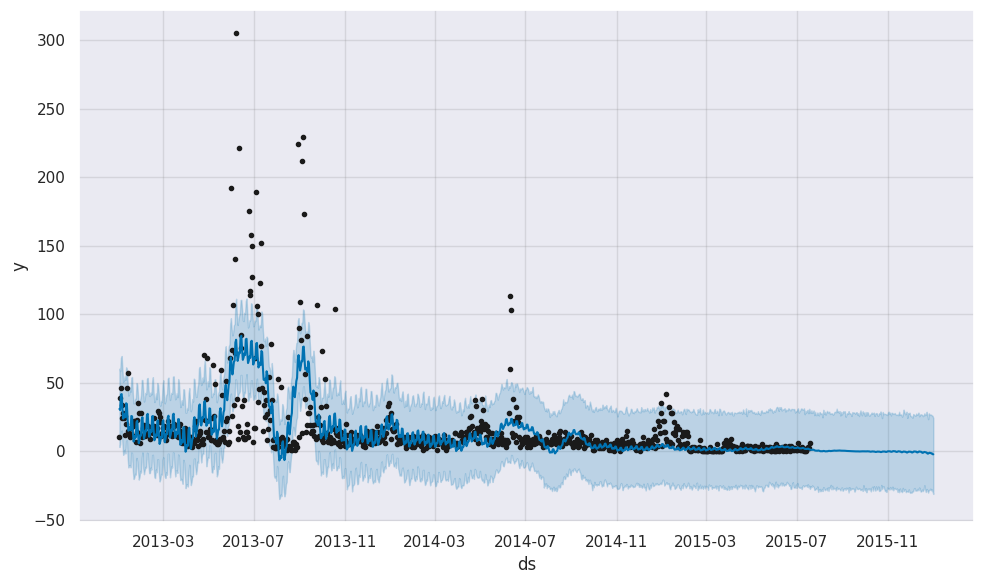

In [69]:
prophet_items_id_sales[2808]['model'].plot(prophet_items_id_sales[2808]['forecast']);

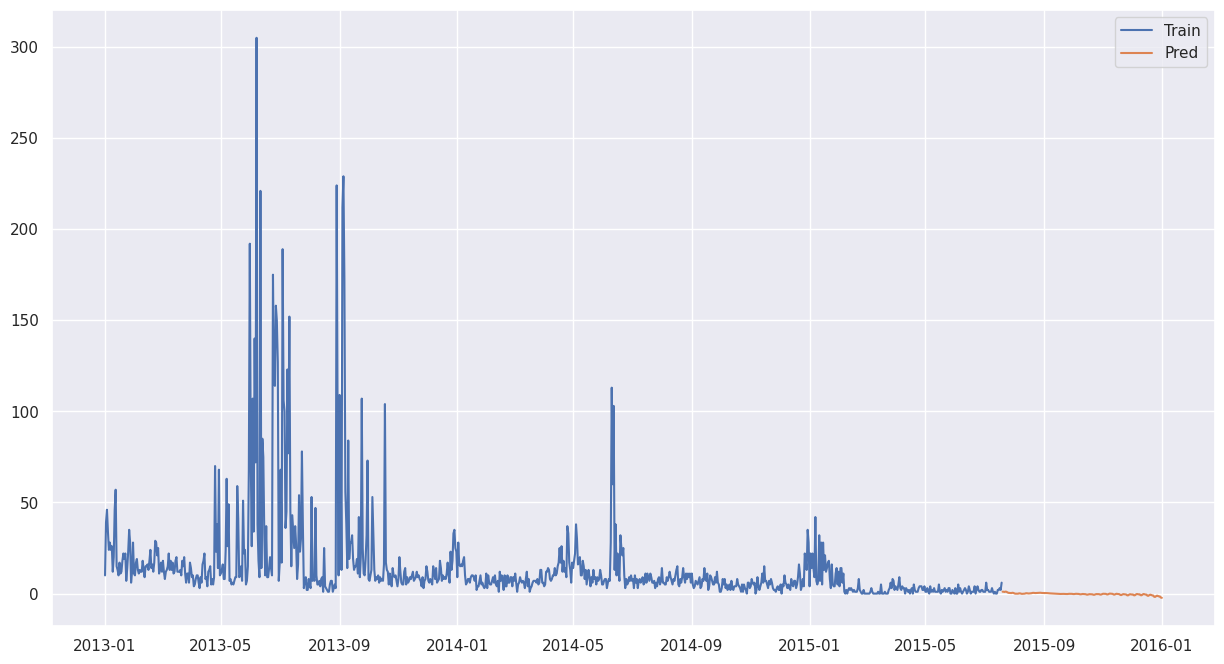

In [70]:
plot_forecast(prophet_items_id_sales[2808], test=False)

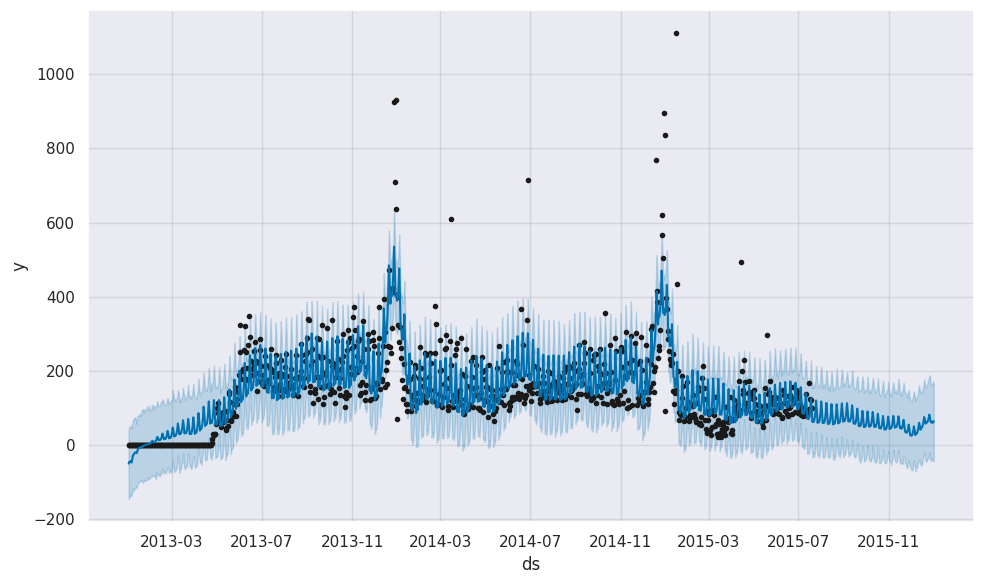

In [71]:
prophet_items_id_sales[20949]['model'].plot(prophet_items_id_sales[20949]['forecast']);

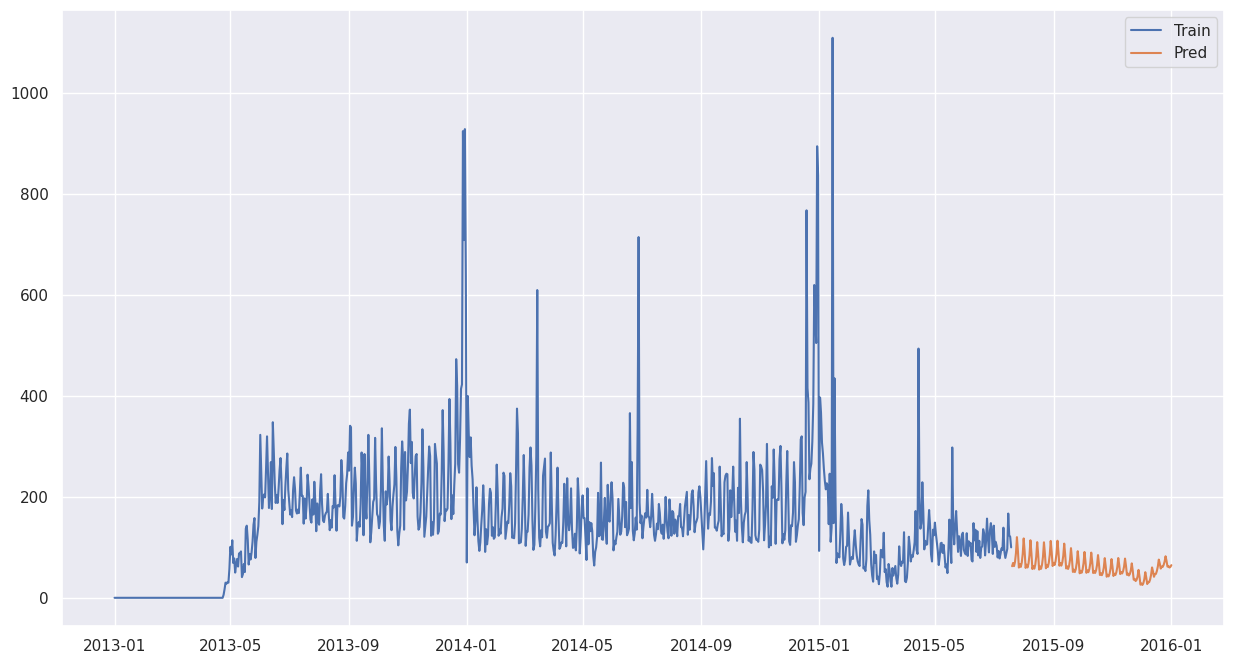

In [72]:
plot_forecast(prophet_items_id_sales[20949], test=False)

### Values

In [ ]:
%%time
# initialize model for each category id
prophet_items_id_values = run_load_model(
    df=items_values,
    load=False,
    model_name="prophet_items_id_values",
    freq=freq_analysis)

<font size="5"> Total Sales for next month, sun of all items </font>

#### Save the data (on raw_data) and model (on git) in json file

#### Plot Example

## Categories by Shop Prediction

### Sales

In [73]:
LOADED

True

In [94]:
%%time
# initialize model for each category id
prophet_cats_shops_id_sales = run_load_model(
    df=cats_shops_sales,
    load=False,
    model_name="prophet_cats_shops_id_sales",
    freq=freq_analysis)

=== Running Prophet Model from Scratch ===


19:00:26 - cmdstanpy - INFO - Chain [1] start processing
19:00:26 - cmdstanpy - INFO - Chain [1] start processing
19:00:26 - cmdstanpy - INFO - Chain [1] start processing
19:00:26 - cmdstanpy - INFO - Chain [1] start processing
19:00:26 - cmdstanpy - INFO - Chain [1] start processing
19:00:26 - cmdstanpy - INFO - Chain [1] start processing
19:00:26 - cmdstanpy - INFO - Chain [1] done processing
19:00:26 - cmdstanpy - INFO - Chain [1] start processing
19:00:26 - cmdstanpy - INFO - Chain [1] start processing
19:00:26 - cmdstanpy - INFO - Chain [1] done processing
19:00:26 - cmdstanpy - INFO - Chain [1] done processing
19:00:26 - cmdstanpy - INFO - Chain [1] done processing
19:00:26 - cmdstanpy - INFO - Chain [1] done processing
19:00:26 - cmdstanpy - INFO - Chain [1] done processing
19:00:26 - cmdstanpy - INFO - Chain [1] done processing
19:00:27 - cmdstanpy - INFO - Chain [1] done processing
19:00:27 - cmdstanpy - INFO - Chain [1] start processing
19:00:27 - cmdstanpy - INFO - Chain [1]

19:00:38 - cmdstanpy - INFO - Chain [1] done processing
19:00:38 - cmdstanpy - INFO - Chain [1] start processing
19:00:38 - cmdstanpy - INFO - Chain [1] start processing
19:00:38 - cmdstanpy - INFO - Chain [1] start processing
19:00:38 - cmdstanpy - INFO - Chain [1] start processing
19:00:38 - cmdstanpy - INFO - Chain [1] start processing
19:00:38 - cmdstanpy - INFO - Chain [1] start processing
19:00:38 - cmdstanpy - INFO - Chain [1] done processing
19:00:38 - cmdstanpy - INFO - Chain [1] done processing
19:00:38 - cmdstanpy - INFO - Chain [1] done processing
19:00:38 - cmdstanpy - INFO - Chain [1] done processing
19:00:38 - cmdstanpy - INFO - Chain [1] start processing
19:00:38 - cmdstanpy - INFO - Chain [1] start processing
19:00:39 - cmdstanpy - INFO - Chain [1] done processing
19:00:39 - cmdstanpy - INFO - Chain [1] done processing
19:00:39 - cmdstanpy - INFO - Chain [1] done processing
19:00:39 - cmdstanpy - INFO - Chain [1] start processing
19:00:39 - cmdstanpy - INFO - Chain [1]

19:00:51 - cmdstanpy - INFO - Chain [1] start processing
19:00:51 - cmdstanpy - INFO - Chain [1] done processing
19:00:51 - cmdstanpy - INFO - Chain [1] start processing
19:00:51 - cmdstanpy - INFO - Chain [1] done processing
19:00:51 - cmdstanpy - INFO - Chain [1] done processing
19:00:51 - cmdstanpy - INFO - Chain [1] done processing
19:00:51 - cmdstanpy - INFO - Chain [1] start processing
19:00:51 - cmdstanpy - INFO - Chain [1] start processing
19:00:51 - cmdstanpy - INFO - Chain [1] done processing
19:00:51 - cmdstanpy - INFO - Chain [1] done processing
19:00:52 - cmdstanpy - INFO - Chain [1] start processing
19:00:52 - cmdstanpy - INFO - Chain [1] start processing
19:00:52 - cmdstanpy - INFO - Chain [1] start processing
19:00:52 - cmdstanpy - INFO - Chain [1] done processing
19:00:52 - cmdstanpy - INFO - Chain [1] done processing
19:00:52 - cmdstanpy - INFO - Chain [1] done processing
19:00:52 - cmdstanpy - INFO - Chain [1] start processing
19:00:52 - cmdstanpy - INFO - Chain [1] 

19:01:06 - cmdstanpy - INFO - Chain [1] done processing
19:01:06 - cmdstanpy - INFO - Chain [1] done processing
19:01:06 - cmdstanpy - INFO - Chain [1] start processing
19:01:06 - cmdstanpy - INFO - Chain [1] start processing
19:01:06 - cmdstanpy - INFO - Chain [1] start processing
19:01:06 - cmdstanpy - INFO - Chain [1] start processing
19:01:07 - cmdstanpy - INFO - Chain [1] done processing
19:01:07 - cmdstanpy - INFO - Chain [1] done processing
19:01:07 - cmdstanpy - INFO - Chain [1] start processing
19:01:07 - cmdstanpy - INFO - Chain [1] done processing
19:01:07 - cmdstanpy - INFO - Chain [1] done processing
19:01:07 - cmdstanpy - INFO - Chain [1] done processing
19:01:07 - cmdstanpy - INFO - Chain [1] start processing
19:01:07 - cmdstanpy - INFO - Chain [1] start processing
19:01:07 - cmdstanpy - INFO - Chain [1] start processing
19:01:07 - cmdstanpy - INFO - Chain [1] done processing
19:01:08 - cmdstanpy - INFO - Chain [1] start processing
19:01:08 - cmdstanpy - INFO - Chain [1]

19:01:21 - cmdstanpy - INFO - Chain [1] start processing
19:01:21 - cmdstanpy - INFO - Chain [1] start processing
19:01:21 - cmdstanpy - INFO - Chain [1] start processing
19:01:21 - cmdstanpy - INFO - Chain [1] start processing
19:01:21 - cmdstanpy - INFO - Chain [1] start processing
19:01:21 - cmdstanpy - INFO - Chain [1] done processing
19:01:21 - cmdstanpy - INFO - Chain [1] done processing
19:01:21 - cmdstanpy - INFO - Chain [1] start processing
19:01:21 - cmdstanpy - INFO - Chain [1] done processing
19:01:21 - cmdstanpy - INFO - Chain [1] start processing
19:01:21 - cmdstanpy - INFO - Chain [1] done processing
19:01:21 - cmdstanpy - INFO - Chain [1] done processing
19:01:21 - cmdstanpy - INFO - Chain [1] done processing
19:01:21 - cmdstanpy - INFO - Chain [1] done processing
19:01:21 - cmdstanpy - INFO - Chain [1] start processing
19:01:22 - cmdstanpy - INFO - Chain [1] done processing
19:01:22 - cmdstanpy - INFO - Chain [1] start processing
19:01:22 - cmdstanpy - INFO - Chain [1]

19:01:34 - cmdstanpy - INFO - Chain [1] done processing
19:01:34 - cmdstanpy - INFO - Chain [1] done processing
19:01:34 - cmdstanpy - INFO - Chain [1] start processing
19:01:34 - cmdstanpy - INFO - Chain [1] start processing
19:01:35 - cmdstanpy - INFO - Chain [1] done processing
19:01:35 - cmdstanpy - INFO - Chain [1] done processing
19:01:35 - cmdstanpy - INFO - Chain [1] done processing
19:01:35 - cmdstanpy - INFO - Chain [1] start processing
19:01:35 - cmdstanpy - INFO - Chain [1] start processing
19:01:35 - cmdstanpy - INFO - Chain [1] start processing
19:01:35 - cmdstanpy - INFO - Chain [1] done processing
19:01:35 - cmdstanpy - INFO - Chain [1] done processing
19:01:35 - cmdstanpy - INFO - Chain [1] start processing
19:01:35 - cmdstanpy - INFO - Chain [1] done processing
19:01:36 - cmdstanpy - INFO - Chain [1] start processing
19:01:36 - cmdstanpy - INFO - Chain [1] done processing
19:01:36 - cmdstanpy - INFO - Chain [1] start processing
19:01:36 - cmdstanpy - INFO - Chain [1] 

19:01:49 - cmdstanpy - INFO - Chain [1] done processing
19:01:49 - cmdstanpy - INFO - Chain [1] start processing
19:01:49 - cmdstanpy - INFO - Chain [1] done processing
19:01:49 - cmdstanpy - INFO - Chain [1] start processing
19:01:49 - cmdstanpy - INFO - Chain [1] start processing
19:01:50 - cmdstanpy - INFO - Chain [1] start processing
19:01:50 - cmdstanpy - INFO - Chain [1] done processing
19:01:50 - cmdstanpy - INFO - Chain [1] start processing
19:01:50 - cmdstanpy - INFO - Chain [1] done processing
19:01:50 - cmdstanpy - INFO - Chain [1] done processing
19:01:50 - cmdstanpy - INFO - Chain [1] done processing
19:01:50 - cmdstanpy - INFO - Chain [1] start processing
19:01:50 - cmdstanpy - INFO - Chain [1] start processing
19:01:50 - cmdstanpy - INFO - Chain [1] done processing
19:01:50 - cmdstanpy - INFO - Chain [1] done processing
19:01:50 - cmdstanpy - INFO - Chain [1] start processing
19:01:50 - cmdstanpy - INFO - Chain [1] done processing
19:01:50 - cmdstanpy - INFO - Chain [1] 

19:02:03 - cmdstanpy - INFO - Chain [1] start processing
19:02:03 - cmdstanpy - INFO - Chain [1] done processing
19:02:03 - cmdstanpy - INFO - Chain [1] done processing
19:02:03 - cmdstanpy - INFO - Chain [1] start processing
19:02:03 - cmdstanpy - INFO - Chain [1] done processing
19:02:03 - cmdstanpy - INFO - Chain [1] done processing
19:02:04 - cmdstanpy - INFO - Chain [1] start processing
19:02:04 - cmdstanpy - INFO - Chain [1] done processing
19:02:04 - cmdstanpy - INFO - Chain [1] start processing
19:02:04 - cmdstanpy - INFO - Chain [1] start processing
19:02:04 - cmdstanpy - INFO - Chain [1] done processing
19:02:04 - cmdstanpy - INFO - Chain [1] start processing
19:02:04 - cmdstanpy - INFO - Chain [1] start processing
19:02:04 - cmdstanpy - INFO - Chain [1] done processing
19:02:04 - cmdstanpy - INFO - Chain [1] done processing
19:02:05 - cmdstanpy - INFO - Chain [1] start processing
19:02:05 - cmdstanpy - INFO - Chain [1] done processing
19:02:05 - cmdstanpy - INFO - Chain [1] 

19:02:17 - cmdstanpy - INFO - Chain [1] done processing
19:02:17 - cmdstanpy - INFO - Chain [1] done processing
19:02:18 - cmdstanpy - INFO - Chain [1] done processing
19:02:18 - cmdstanpy - INFO - Chain [1] start processing
19:02:18 - cmdstanpy - INFO - Chain [1] start processing
19:02:18 - cmdstanpy - INFO - Chain [1] done processing
19:02:18 - cmdstanpy - INFO - Chain [1] start processing
19:02:18 - cmdstanpy - INFO - Chain [1] start processing
19:02:18 - cmdstanpy - INFO - Chain [1] start processing
19:02:18 - cmdstanpy - INFO - Chain [1] done processing
19:02:18 - cmdstanpy - INFO - Chain [1] done processing
19:02:18 - cmdstanpy - INFO - Chain [1] done processing
19:02:18 - cmdstanpy - INFO - Chain [1] done processing
19:02:19 - cmdstanpy - INFO - Chain [1] start processing
19:02:19 - cmdstanpy - INFO - Chain [1] start processing
19:02:19 - cmdstanpy - INFO - Chain [1] done processing
19:02:19 - cmdstanpy - INFO - Chain [1] done processing
19:02:19 - cmdstanpy - INFO - Chain [1] s

19:02:32 - cmdstanpy - INFO - Chain [1] start processing
19:02:32 - cmdstanpy - INFO - Chain [1] done processing
19:02:32 - cmdstanpy - INFO - Chain [1] start processing
19:02:32 - cmdstanpy - INFO - Chain [1] start processing
19:02:32 - cmdstanpy - INFO - Chain [1] start processing
19:02:32 - cmdstanpy - INFO - Chain [1] done processing
19:02:32 - cmdstanpy - INFO - Chain [1] done processing
19:02:32 - cmdstanpy - INFO - Chain [1] done processing
19:02:32 - cmdstanpy - INFO - Chain [1] done processing
19:02:32 - cmdstanpy - INFO - Chain [1] start processing
19:02:33 - cmdstanpy - INFO - Chain [1] start processing
19:02:33 - cmdstanpy - INFO - Chain [1] done processing
19:02:33 - cmdstanpy - INFO - Chain [1] done processing
19:02:33 - cmdstanpy - INFO - Chain [1] start processing
19:02:33 - cmdstanpy - INFO - Chain [1] done processing
19:02:33 - cmdstanpy - INFO - Chain [1] start processing
19:02:33 - cmdstanpy - INFO - Chain [1] start processing
19:02:33 - cmdstanpy - INFO - Chain [1]

19:02:46 - cmdstanpy - INFO - Chain [1] start processing
19:02:46 - cmdstanpy - INFO - Chain [1] start processing
19:02:46 - cmdstanpy - INFO - Chain [1] done processing
19:02:46 - cmdstanpy - INFO - Chain [1] start processing
19:02:46 - cmdstanpy - INFO - Chain [1] done processing
19:02:46 - cmdstanpy - INFO - Chain [1] done processing
19:02:47 - cmdstanpy - INFO - Chain [1] done processing
19:02:47 - cmdstanpy - INFO - Chain [1] start processing
19:02:47 - cmdstanpy - INFO - Chain [1] start processing
19:02:47 - cmdstanpy - INFO - Chain [1] start processing
19:02:47 - cmdstanpy - INFO - Chain [1] done processing
19:02:47 - cmdstanpy - INFO - Chain [1] done processing
19:02:47 - cmdstanpy - INFO - Chain [1] done processing
19:02:48 - cmdstanpy - INFO - Chain [1] start processing
19:02:48 - cmdstanpy - INFO - Chain [1] start processing
19:02:48 - cmdstanpy - INFO - Chain [1] start processing
19:02:48 - cmdstanpy - INFO - Chain [1] start processing
19:02:48 - cmdstanpy - INFO - Chain [1

19:03:00 - cmdstanpy - INFO - Chain [1] done processing
19:03:00 - cmdstanpy - INFO - Chain [1] start processing
19:03:00 - cmdstanpy - INFO - Chain [1] start processing
19:03:00 - cmdstanpy - INFO - Chain [1] done processing
19:03:00 - cmdstanpy - INFO - Chain [1] done processing
19:03:00 - cmdstanpy - INFO - Chain [1] done processing
19:03:01 - cmdstanpy - INFO - Chain [1] start processing
19:03:01 - cmdstanpy - INFO - Chain [1] start processing
19:03:01 - cmdstanpy - INFO - Chain [1] done processing
19:03:01 - cmdstanpy - INFO - Chain [1] done processing
19:03:01 - cmdstanpy - INFO - Chain [1] start processing
19:03:01 - cmdstanpy - INFO - Chain [1] start processing
19:03:01 - cmdstanpy - INFO - Chain [1] start processing
19:03:01 - cmdstanpy - INFO - Chain [1] start processing
19:03:01 - cmdstanpy - INFO - Chain [1] done processing
19:03:01 - cmdstanpy - INFO - Chain [1] start processing
19:03:01 - cmdstanpy - INFO - Chain [1] done processing
19:03:01 - cmdstanpy - INFO - Chain [1]

19:03:14 - cmdstanpy - INFO - Chain [1] done processing
19:03:14 - cmdstanpy - INFO - Chain [1] done processing
19:03:15 - cmdstanpy - INFO - Chain [1] start processing
19:03:15 - cmdstanpy - INFO - Chain [1] done processing
19:03:15 - cmdstanpy - INFO - Chain [1] start processing
19:03:15 - cmdstanpy - INFO - Chain [1] start processing
19:03:15 - cmdstanpy - INFO - Chain [1] start processing
19:03:15 - cmdstanpy - INFO - Chain [1] done processing
19:03:15 - cmdstanpy - INFO - Chain [1] done processing
19:03:15 - cmdstanpy - INFO - Chain [1] done processing
19:03:15 - cmdstanpy - INFO - Chain [1] start processing
19:03:16 - cmdstanpy - INFO - Chain [1] done processing
19:03:16 - cmdstanpy - INFO - Chain [1] start processing
19:03:16 - cmdstanpy - INFO - Chain [1] start processing
19:03:16 - cmdstanpy - INFO - Chain [1] start processing
19:03:16 - cmdstanpy - INFO - Chain [1] start processing
19:03:16 - cmdstanpy - INFO - Chain [1] start processing
19:03:16 - cmdstanpy - INFO - Chain [1

19:03:29 - cmdstanpy - INFO - Chain [1] done processing
19:03:29 - cmdstanpy - INFO - Chain [1] done processing
19:03:29 - cmdstanpy - INFO - Chain [1] start processing
19:03:29 - cmdstanpy - INFO - Chain [1] start processing
19:03:29 - cmdstanpy - INFO - Chain [1] done processing
19:03:29 - cmdstanpy - INFO - Chain [1] done processing
19:03:29 - cmdstanpy - INFO - Chain [1] done processing
19:03:29 - cmdstanpy - INFO - Chain [1] start processing
19:03:29 - cmdstanpy - INFO - Chain [1] done processing
19:03:30 - cmdstanpy - INFO - Chain [1] start processing
19:03:30 - cmdstanpy - INFO - Chain [1] done processing
19:03:30 - cmdstanpy - INFO - Chain [1] start processing
19:03:30 - cmdstanpy - INFO - Chain [1] start processing
19:03:30 - cmdstanpy - INFO - Chain [1] start processing
19:03:30 - cmdstanpy - INFO - Chain [1] start processing
19:03:30 - cmdstanpy - INFO - Chain [1] done processing
19:03:30 - cmdstanpy - INFO - Chain [1] start processing
19:03:30 - cmdstanpy - INFO - Chain [1]

19:03:43 - cmdstanpy - INFO - Chain [1] done processing
19:03:43 - cmdstanpy - INFO - Chain [1] done processing
19:03:43 - cmdstanpy - INFO - Chain [1] done processing
19:03:43 - cmdstanpy - INFO - Chain [1] done processing
19:03:44 - cmdstanpy - INFO - Chain [1] start processing
19:03:44 - cmdstanpy - INFO - Chain [1] done processing
19:03:44 - cmdstanpy - INFO - Chain [1] start processing
19:03:44 - cmdstanpy - INFO - Chain [1] start processing
19:03:44 - cmdstanpy - INFO - Chain [1] start processing
19:03:44 - cmdstanpy - INFO - Chain [1] start processing
19:03:44 - cmdstanpy - INFO - Chain [1] done processing
19:03:44 - cmdstanpy - INFO - Chain [1] done processing
19:03:44 - cmdstanpy - INFO - Chain [1] done processing
19:03:44 - cmdstanpy - INFO - Chain [1] done processing
19:03:44 - cmdstanpy - INFO - Chain [1] start processing
19:03:45 - cmdstanpy - INFO - Chain [1] done processing
19:03:45 - cmdstanpy - INFO - Chain [1] start processing
19:03:45 - cmdstanpy - INFO - Chain [1] s

19:03:57 - cmdstanpy - INFO - Chain [1] start processing
19:03:58 - cmdstanpy - INFO - Chain [1] done processing
19:03:58 - cmdstanpy - INFO - Chain [1] start processing
19:03:58 - cmdstanpy - INFO - Chain [1] done processing
19:03:58 - cmdstanpy - INFO - Chain [1] start processing
19:03:58 - cmdstanpy - INFO - Chain [1] start processing
19:03:58 - cmdstanpy - INFO - Chain [1] start processing
19:03:58 - cmdstanpy - INFO - Chain [1] done processing
19:03:58 - cmdstanpy - INFO - Chain [1] done processing
19:03:59 - cmdstanpy - INFO - Chain [1] start processing
19:03:59 - cmdstanpy - INFO - Chain [1] start processing
19:03:59 - cmdstanpy - INFO - Chain [1] done processing
19:03:59 - cmdstanpy - INFO - Chain [1] done processing
19:03:59 - cmdstanpy - INFO - Chain [1] start processing
19:03:59 - cmdstanpy - INFO - Chain [1] done processing
19:03:59 - cmdstanpy - INFO - Chain [1] done processing
19:03:59 - cmdstanpy - INFO - Chain [1] start processing
19:03:59 - cmdstanpy - INFO - Chain [1]

19:04:13 - cmdstanpy - INFO - Chain [1] done processing
19:04:13 - cmdstanpy - INFO - Chain [1] done processing
19:04:14 - cmdstanpy - INFO - Chain [1] start processing
19:04:14 - cmdstanpy - INFO - Chain [1] done processing
19:04:14 - cmdstanpy - INFO - Chain [1] start processing
19:04:14 - cmdstanpy - INFO - Chain [1] done processing
19:04:14 - cmdstanpy - INFO - Chain [1] done processing
19:04:14 - cmdstanpy - INFO - Chain [1] start processing
19:04:14 - cmdstanpy - INFO - Chain [1] done processing
19:04:15 - cmdstanpy - INFO - Chain [1] start processing
19:04:15 - cmdstanpy - INFO - Chain [1] done processing
19:04:15 - cmdstanpy - INFO - Chain [1] start processing
19:04:15 - cmdstanpy - INFO - Chain [1] start processing
19:04:15 - cmdstanpy - INFO - Chain [1] start processing
19:04:15 - cmdstanpy - INFO - Chain [1] start processing
19:04:15 - cmdstanpy - INFO - Chain [1] done processing
19:04:15 - cmdstanpy - INFO - Chain [1] done processing
19:04:15 - cmdstanpy - INFO - Chain [1] 

19:04:31 - cmdstanpy - INFO - Chain [1] done processing
19:04:31 - cmdstanpy - INFO - Chain [1] done processing
19:04:31 - cmdstanpy - INFO - Chain [1] done processing
19:04:31 - cmdstanpy - INFO - Chain [1] start processing
19:04:31 - cmdstanpy - INFO - Chain [1] done processing
19:04:32 - cmdstanpy - INFO - Chain [1] start processing
19:04:32 - cmdstanpy - INFO - Chain [1] start processing
19:04:32 - cmdstanpy - INFO - Chain [1] start processing
19:04:32 - cmdstanpy - INFO - Chain [1] start processing
19:04:32 - cmdstanpy - INFO - Chain [1] done processing
19:04:32 - cmdstanpy - INFO - Chain [1] start processing
19:04:32 - cmdstanpy - INFO - Chain [1] done processing
19:04:32 - cmdstanpy - INFO - Chain [1] done processing
19:04:32 - cmdstanpy - INFO - Chain [1] done processing
19:04:32 - cmdstanpy - INFO - Chain [1] done processing
19:04:32 - cmdstanpy - INFO - Chain [1] start processing
19:04:33 - cmdstanpy - INFO - Chain [1] done processing
19:04:33 - cmdstanpy - INFO - Chain [1] s

19:04:47 - cmdstanpy - INFO - Chain [1] start processing
19:04:47 - cmdstanpy - INFO - Chain [1] start processing
19:04:47 - cmdstanpy - INFO - Chain [1] done processing
19:04:47 - cmdstanpy - INFO - Chain [1] start processing
19:04:47 - cmdstanpy - INFO - Chain [1] done processing
19:04:47 - cmdstanpy - INFO - Chain [1] done processing
19:04:47 - cmdstanpy - INFO - Chain [1] done processing
19:04:47 - cmdstanpy - INFO - Chain [1] done processing
19:04:47 - cmdstanpy - INFO - Chain [1] done processing
19:04:47 - cmdstanpy - INFO - Chain [1] start processing
19:04:48 - cmdstanpy - INFO - Chain [1] start processing
19:04:48 - cmdstanpy - INFO - Chain [1] done processing
19:04:48 - cmdstanpy - INFO - Chain [1] done processing
19:04:48 - cmdstanpy - INFO - Chain [1] start processing
19:04:48 - cmdstanpy - INFO - Chain [1] start processing
19:04:48 - cmdstanpy - INFO - Chain [1] start processing
19:04:48 - cmdstanpy - INFO - Chain [1] done processing
19:04:48 - cmdstanpy - INFO - Chain [1] 

19:05:02 - cmdstanpy - INFO - Chain [1] done processing
19:05:02 - cmdstanpy - INFO - Chain [1] done processing
19:05:02 - cmdstanpy - INFO - Chain [1] start processing
19:05:02 - cmdstanpy - INFO - Chain [1] done processing
19:05:02 - cmdstanpy - INFO - Chain [1] done processing
19:05:02 - cmdstanpy - INFO - Chain [1] start processing
19:05:02 - cmdstanpy - INFO - Chain [1] start processing
19:05:02 - cmdstanpy - INFO - Chain [1] start processing
19:05:02 - cmdstanpy - INFO - Chain [1] done processing
19:05:02 - cmdstanpy - INFO - Chain [1] done processing
19:05:03 - cmdstanpy - INFO - Chain [1] done processing
19:05:03 - cmdstanpy - INFO - Chain [1] start processing
19:05:03 - cmdstanpy - INFO - Chain [1] start processing
19:05:03 - cmdstanpy - INFO - Chain [1] done processing
19:05:03 - cmdstanpy - INFO - Chain [1] start processing
19:05:03 - cmdstanpy - INFO - Chain [1] done processing
19:05:03 - cmdstanpy - INFO - Chain [1] start processing
19:05:04 - cmdstanpy - INFO - Chain [1] 

19:05:16 - cmdstanpy - INFO - Chain [1] done processing
19:05:16 - cmdstanpy - INFO - Chain [1] start processing
19:05:17 - cmdstanpy - INFO - Chain [1] done processing
19:05:17 - cmdstanpy - INFO - Chain [1] start processing
19:05:17 - cmdstanpy - INFO - Chain [1] start processing
19:05:17 - cmdstanpy - INFO - Chain [1] done processing
19:05:17 - cmdstanpy - INFO - Chain [1] done processing
19:05:17 - cmdstanpy - INFO - Chain [1] start processing
19:05:17 - cmdstanpy - INFO - Chain [1] start processing
19:05:17 - cmdstanpy - INFO - Chain [1] start processing
19:05:18 - cmdstanpy - INFO - Chain [1] start processing
19:05:18 - cmdstanpy - INFO - Chain [1] done processing
19:05:18 - cmdstanpy - INFO - Chain [1] done processing
19:05:18 - cmdstanpy - INFO - Chain [1] done processing
19:05:18 - cmdstanpy - INFO - Chain [1] done processing
19:05:18 - cmdstanpy - INFO - Chain [1] start processing
19:05:18 - cmdstanpy - INFO - Chain [1] done processing
19:05:18 - cmdstanpy - INFO - Chain [1] 

19:05:31 - cmdstanpy - INFO - Chain [1] done processing
19:05:31 - cmdstanpy - INFO - Chain [1] done processing
19:05:31 - cmdstanpy - INFO - Chain [1] start processing
19:05:31 - cmdstanpy - INFO - Chain [1] done processing
19:05:31 - cmdstanpy - INFO - Chain [1] start processing
19:05:32 - cmdstanpy - INFO - Chain [1] start processing
19:05:32 - cmdstanpy - INFO - Chain [1] start processing
19:05:32 - cmdstanpy - INFO - Chain [1] done processing
19:05:32 - cmdstanpy - INFO - Chain [1] start processing
19:05:32 - cmdstanpy - INFO - Chain [1] done processing
19:05:32 - cmdstanpy - INFO - Chain [1] start processing
19:05:32 - cmdstanpy - INFO - Chain [1] done processing
19:05:32 - cmdstanpy - INFO - Chain [1] done processing
19:05:32 - cmdstanpy - INFO - Chain [1] done processing
19:05:32 - cmdstanpy - INFO - Chain [1] start processing
19:05:32 - cmdstanpy - INFO - Chain [1] start processing
19:05:32 - cmdstanpy - INFO - Chain [1] done processing
19:05:32 - cmdstanpy - INFO - Chain [1] 

19:05:46 - cmdstanpy - INFO - Chain [1] done processing
19:05:46 - cmdstanpy - INFO - Chain [1] start processing
19:05:46 - cmdstanpy - INFO - Chain [1] done processing
19:05:46 - cmdstanpy - INFO - Chain [1] done processing
19:05:46 - cmdstanpy - INFO - Chain [1] done processing
19:05:46 - cmdstanpy - INFO - Chain [1] start processing
19:05:46 - cmdstanpy - INFO - Chain [1] start processing
19:05:46 - cmdstanpy - INFO - Chain [1] done processing
19:05:46 - cmdstanpy - INFO - Chain [1] done processing
19:05:47 - cmdstanpy - INFO - Chain [1] start processing
19:05:47 - cmdstanpy - INFO - Chain [1] start processing
19:05:47 - cmdstanpy - INFO - Chain [1] done processing
19:05:47 - cmdstanpy - INFO - Chain [1] start processing
19:05:47 - cmdstanpy - INFO - Chain [1] start processing
19:05:47 - cmdstanpy - INFO - Chain [1] done processing
19:05:47 - cmdstanpy - INFO - Chain [1] start processing
19:05:47 - cmdstanpy - INFO - Chain [1] done processing
19:05:47 - cmdstanpy - INFO - Chain [1] 

19:06:00 - cmdstanpy - INFO - Chain [1] start processing
19:06:00 - cmdstanpy - INFO - Chain [1] start processing
19:06:00 - cmdstanpy - INFO - Chain [1] done processing
19:06:00 - cmdstanpy - INFO - Chain [1] done processing
19:06:00 - cmdstanpy - INFO - Chain [1] done processing
19:06:00 - cmdstanpy - INFO - Chain [1] start processing
19:06:01 - cmdstanpy - INFO - Chain [1] start processing
19:06:01 - cmdstanpy - INFO - Chain [1] done processing
19:06:01 - cmdstanpy - INFO - Chain [1] start processing
19:06:01 - cmdstanpy - INFO - Chain [1] start processing
19:06:01 - cmdstanpy - INFO - Chain [1] done processing
19:06:01 - cmdstanpy - INFO - Chain [1] done processing
19:06:01 - cmdstanpy - INFO - Chain [1] done processing
19:06:01 - cmdstanpy - INFO - Chain [1] start processing
19:06:01 - cmdstanpy - INFO - Chain [1] done processing
19:06:02 - cmdstanpy - INFO - Chain [1] start processing
19:06:02 - cmdstanpy - INFO - Chain [1] done processing
19:06:02 - cmdstanpy - INFO - Chain [1] 

19:06:14 - cmdstanpy - INFO - Chain [1] done processing
19:06:14 - cmdstanpy - INFO - Chain [1] start processing
19:06:14 - cmdstanpy - INFO - Chain [1] done processing
19:06:15 - cmdstanpy - INFO - Chain [1] start processing
19:06:15 - cmdstanpy - INFO - Chain [1] done processing
19:06:15 - cmdstanpy - INFO - Chain [1] done processing
19:06:15 - cmdstanpy - INFO - Chain [1] start processing
19:06:15 - cmdstanpy - INFO - Chain [1] done processing
19:06:15 - cmdstanpy - INFO - Chain [1] start processing
19:06:15 - cmdstanpy - INFO - Chain [1] start processing
19:06:16 - cmdstanpy - INFO - Chain [1] start processing
19:06:16 - cmdstanpy - INFO - Chain [1] done processing
19:06:16 - cmdstanpy - INFO - Chain [1] done processing
19:06:16 - cmdstanpy - INFO - Chain [1] done processing
19:06:16 - cmdstanpy - INFO - Chain [1] start processing
19:06:16 - cmdstanpy - INFO - Chain [1] start processing
19:06:16 - cmdstanpy - INFO - Chain [1] done processing
19:06:16 - cmdstanpy - INFO - Chain [1] 

19:06:29 - cmdstanpy - INFO - Chain [1] done processing
19:06:29 - cmdstanpy - INFO - Chain [1] done processing
19:06:29 - cmdstanpy - INFO - Chain [1] start processing
19:06:29 - cmdstanpy - INFO - Chain [1] done processing
19:06:30 - cmdstanpy - INFO - Chain [1] start processing
19:06:30 - cmdstanpy - INFO - Chain [1] done processing
19:06:30 - cmdstanpy - INFO - Chain [1] done processing
19:06:30 - cmdstanpy - INFO - Chain [1] start processing
19:06:30 - cmdstanpy - INFO - Chain [1] start processing
19:06:30 - cmdstanpy - INFO - Chain [1] start processing
19:06:30 - cmdstanpy - INFO - Chain [1] start processing
19:06:30 - cmdstanpy - INFO - Chain [1] done processing
19:06:30 - cmdstanpy - INFO - Chain [1] done processing
19:06:31 - cmdstanpy - INFO - Chain [1] start processing
19:06:31 - cmdstanpy - INFO - Chain [1] done processing
19:06:31 - cmdstanpy - INFO - Chain [1] start processing
19:06:31 - cmdstanpy - INFO - Chain [1] done processing
19:06:31 - cmdstanpy - INFO - Chain [1] 

19:06:44 - cmdstanpy - INFO - Chain [1] start processing
19:06:44 - cmdstanpy - INFO - Chain [1] done processing
19:06:44 - cmdstanpy - INFO - Chain [1] done processing
19:06:44 - cmdstanpy - INFO - Chain [1] done processing
19:06:44 - cmdstanpy - INFO - Chain [1] done processing
19:06:45 - cmdstanpy - INFO - Chain [1] start processing
19:06:45 - cmdstanpy - INFO - Chain [1] start processing
19:06:45 - cmdstanpy - INFO - Chain [1] done processing
19:06:45 - cmdstanpy - INFO - Chain [1] start processing
19:06:45 - cmdstanpy - INFO - Chain [1] start processing
19:06:45 - cmdstanpy - INFO - Chain [1] start processing
19:06:46 - cmdstanpy - INFO - Chain [1] done processing
19:06:46 - cmdstanpy - INFO - Chain [1] done processing
19:06:46 - cmdstanpy - INFO - Chain [1] done processing
19:06:46 - cmdstanpy - INFO - Chain [1] done processing
19:06:46 - cmdstanpy - INFO - Chain [1] start processing
19:06:46 - cmdstanpy - INFO - Chain [1] start processing
19:06:46 - cmdstanpy - INFO - Chain [1] 

=== END RUNNING ===
CPU times: user 8.73 s, sys: 1.42 s, total: 10.2 s
Wall time: 6min 34s


In [ ]:
../raw_data/prophet/prophet_cats_shops_id_sales_test.gz

In [96]:
# get the prediction for "only" the next month for every item
cats_shops_id_sales_pred = {}
for item in prophet_cats_shops_id_sales:
    pred = prophet_cats_shops_id_sales[item]
    pred = get_forecast_data(pred)
    cats_shops_id_sales_pred[item] = pred['month']['yhat'][0]

In [97]:
cats_shops_id_sales_pred

{(2, 2): 2.34,
 (2, 3): 1.04,
 (2, 5): 0.0,
 (2, 6): 2.39,
 (2, 7): 3.5,
 (2, 11): 0.39,
 (2, 12): -2.0,
 (2, 15): 0.6,
 (2, 16): -1.17,
 (2, 19): 75.01,
 (2, 20): 205.23,
 (2, 21): 4.53,
 (2, 22): 4.01,
 (2, 23): 45.84,
 (2, 24): 31.31,
 (2, 25): 10.56,
 (2, 28): 81.9,
 (2, 29): -3.57,
 (2, 30): 137.06,
 (2, 33): 4.72,
 (2, 35): 5.2,
 (2, 37): 20.19,
 (2, 38): 23.97,
 (2, 40): 30.87,
 (2, 41): 6.79,
 (2, 42): 7.75,
 (2, 43): 0.0,
 (2, 47): 1.72,
 (2, 49): 1.06,
 (2, 55): -6.07,
 (2, 56): 5.34,
 (2, 57): -0.81,
 (2, 58): -0.23,
 (2, 61): -2.24,
 (2, 62): 0.26,
 (2, 63): 32.19,
 (2, 64): 26.89,
 (2, 65): 12.27,
 (2, 67): -0.28,
 (2, 69): 9.01,
 (2, 70): 40.47,
 (2, 71): 57.95,
 (2, 72): 40.71,
 (2, 73): 2.77,
 (2, 75): 6.97,
 (2, 77): 0.0,
 (2, 79): 56.47,
 (2, 83): 0.22,
 (3, 2): 13.72,
 (3, 3): 18.24,
 (3, 5): 0.2,
 (3, 6): 9.71,
 (3, 7): 8.34,
 (3, 11): 6.6,
 (3, 12): 0.9,
 (3, 15): -0.05,
 (3, 16): 0.07,
 (3, 19): 71.07,
 (3, 20): 220.68,
 (3, 21): 5.61,
 (3, 22): 2.68,
 (3, 23): 58

<font size="5"> Total Sales for next month, sun of all items </font>

In [98]:
all_cats_shops_id_sales_pred = sum(list(cats_shops_id_sales_pred.values())).round(2)
all_cats_shops_id_sales_pred

76671.19

#### Save the data (on raw_data) and model (on git) in json file

In [100]:
new_keys = [str(key[0])+"-"+str(key[1]) for key in prophet_cats_shops_id_sales.keys()]
prophet_cats_shops_id_sales_new = dict(zip(new_keys, prophet_cats_shops_id_sales.values()))

In [101]:
save_model_data(prophet_cats_shops_id_sales_new, 'prophet_cats_shops_id_sales', save=True)

=== START ===
=== MODEL SAVED ===


#### Plot Example

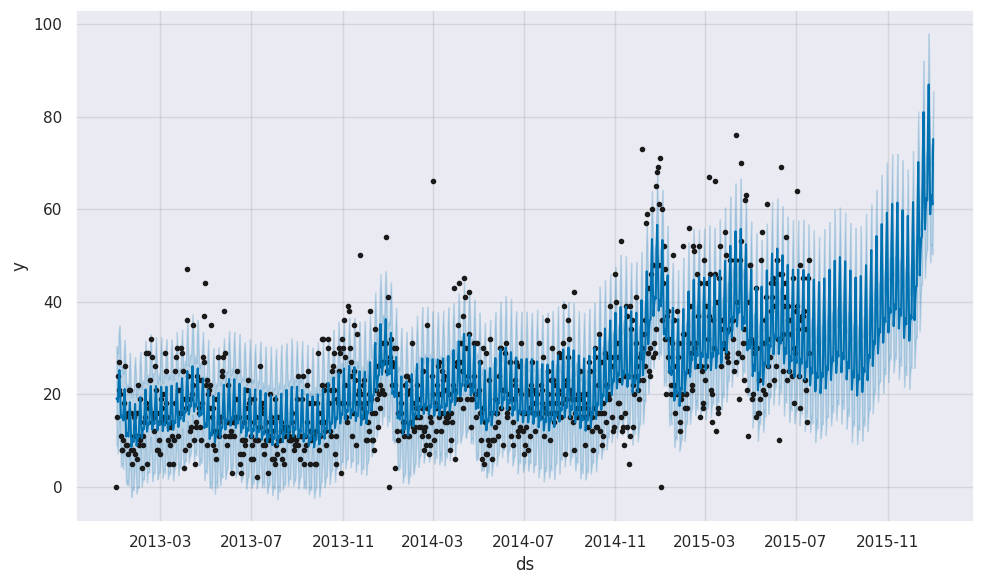

In [102]:
prophet_cats_shops_id_sales_new['31-40']['model'].plot(prophet_cats_shops_id_sales_new['31-40']['forecast']);

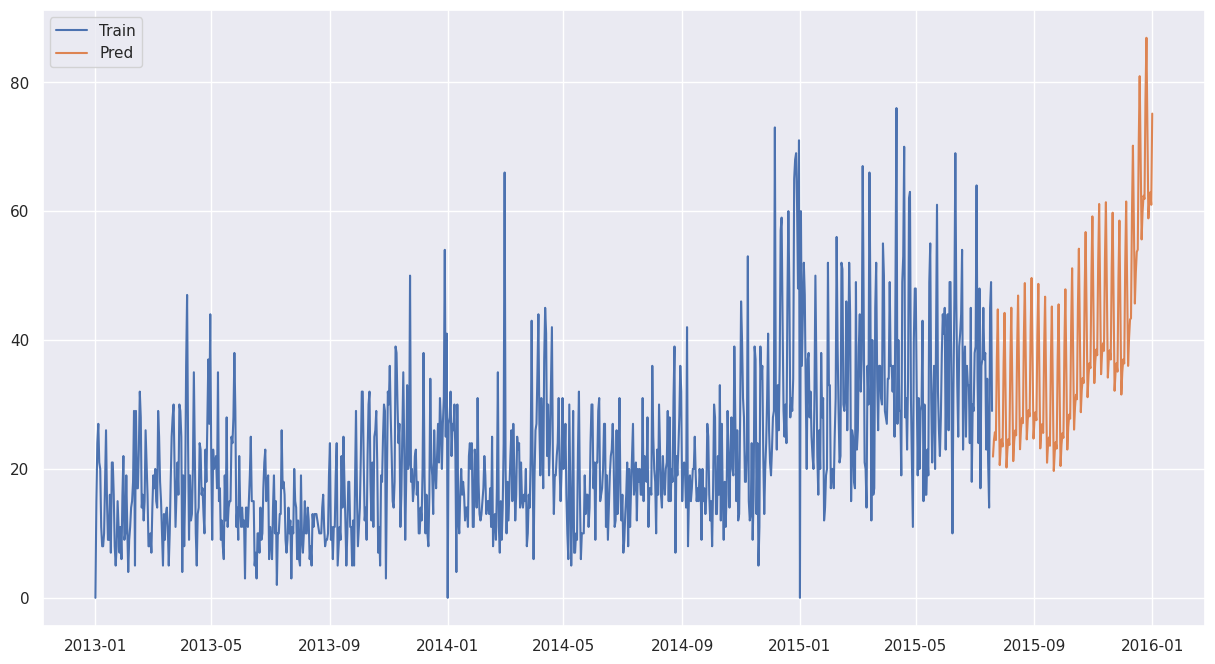

In [103]:
plot_forecast(prophet_cats_shops_id_sales_new['31-40'], test=False)

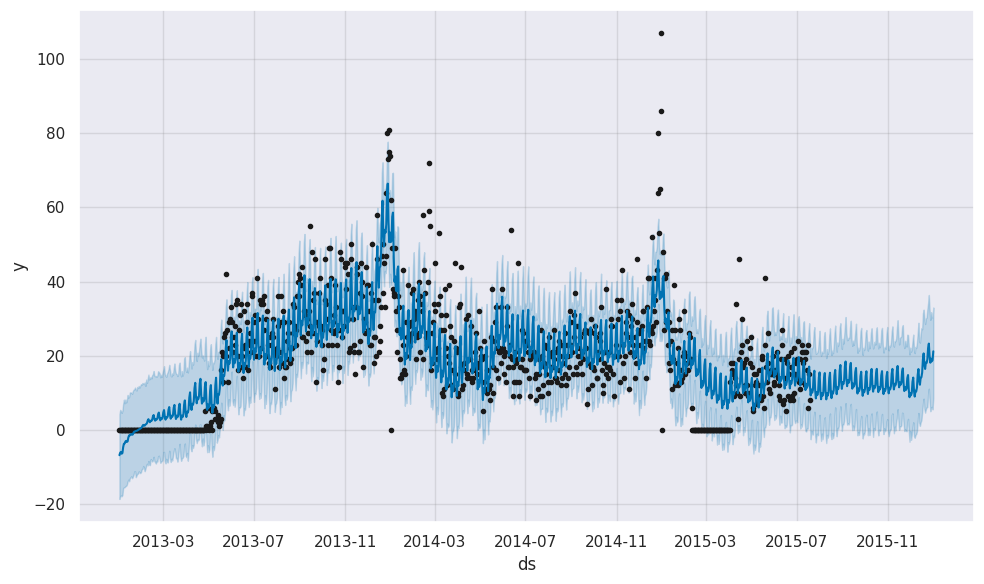

In [104]:
prophet_cats_shops_id_sales_new['31-71']['model'].plot(prophet_cats_shops_id_sales_new['31-71']['forecast']);

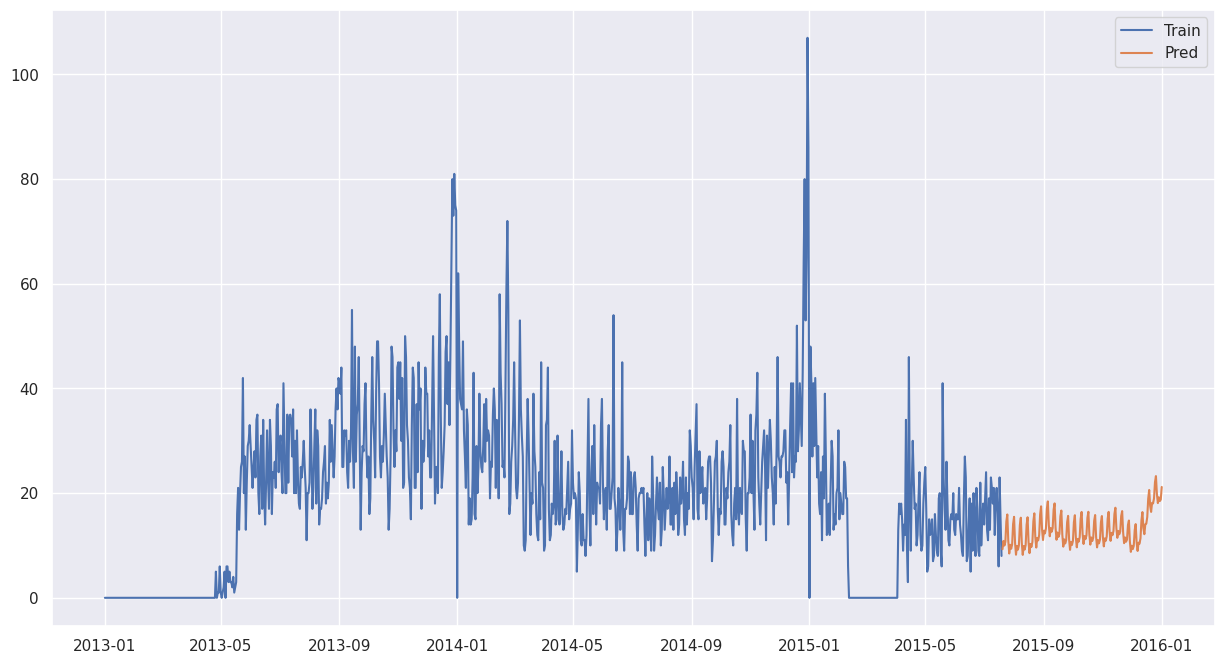

In [105]:
plot_forecast(prophet_cats_shops_id_sales_new['31-71'], test=False)

### Values

<font size="5"> Total Sales for next month, sun of all items </font>

#### Save the data (on raw_data) and model (on git) in json file

#### Plot Example

# Predictions
___

## For all Data Set, the sum of Shops and Category ids

In [306]:
pred_agg_total = pd.DataFrame(
    {'total':[total_sales_pred, total_values_pred],
     'shops_all_id':[all_shops_id_sales_pred, all_shops_id_values_pred],
     'cats_all_id':[all_cats_id_sales_pred, all_cats_id_values_pred],
     'items_all_id':[all_items_id_sales_pred, 0],
     'cats_shps_id':[all_cats_shops_id_sales_pred, 0]
    },
    
    
    index=['sales', 'values']
)
pred_agg_total

total  shops_all_id   cats_all_id  items_all_id  cats_shps_id
sales   6.921501e+04  7.322954e+04  7.361570e+04      60028.57      76671.19
values  1.027606e+08  1.045816e+08  1.185613e+08          0.00          0.00

In [307]:
pred_agg_total.to_csv('../raw_data/prophet/pred_agg_total.csv')

In [343]:
pred_agg_total.astype('int')

total  shops_all_id  cats_all_id  items_all_id  cats_shps_id
sales       69215         73229        73615         60028         76671
values  102760610     104581586    118561327             0             0

## Tables for predicted sales and values of all Models

In [266]:
pred_shops_id_sales_local_df = pd.DataFrame(shops_id_sales_pred, index=[0])
pred_shops_id_values_df = pd.DataFrame(shops_id_values_pred, index=[0])
pred_cats_id_sales_local_df = pd.DataFrame(cats_id_sales_pred, index=[0])
pred_cats_id_values_df = pd.DataFrame(cats_id_values_pred, index=[0])

In [267]:
pred_items_id_sales_local_df = pd.DataFrame(items_id_sales_pred, index=[0])
pred_cats_shops_id_sales_local_df = pd.DataFrame(cats_shops_id_sales_pred, index=[0])

In [268]:
shops_pred = pred_shops_id_sales_local_df.T
shops_pred['shop_id'] = [id for id in shops_pred.index]
shops_pred.rename(columns={0: 'shops_n_sales'}, inplace=True)
shops_pred

shops_n_sales shop_id
2          968.18       2
3          851.28       3
4         1002.65       4
5          900.64       5
6         1940.71       6
7         1579.45       7
10         611.75      10
12        6748.83      12
14        1400.21      14
15        1699.81      15
16        1244.02      16
18        1380.70      18
19        1705.52      19
21        2127.84      21
22        1529.62      22
24         923.31      24
25        5618.31      25
26        1623.67      26
28        3017.44      28
31        7417.84      31
34        1010.80      34
35        1291.76      35
36           0.00      36
37        1242.48      37
38        1395.07      38
39         558.62      39
41         715.36      41
42        5017.02      42
44         779.55      44
45         684.27      45
46        1978.13      46
47        2268.05      47
48         302.30      48
49         569.19      49
50         805.27      50
52        1061.89      52
53        1168.66      53
55        2508.43      55
56        1143.15      56
57        1719.13      57
58        1364.36      58
59        1354.27      59

In [269]:
shops_pred['shop_id'] = shops_pred['shop_id'].astype('int32')

In [270]:
shops_pred.to_csv('../raw_data/prophet/shops_pred.csv')

In [271]:
cat_pred = pred_cats_id_sales_local_df.T
cat_pred['cat_id'] = [id for id in cat_pred.index]
cat_pred.rename(columns={0: 'cats_n_sales'}, inplace=True)
cat_pred

cats_n_sales cat_id
2         128.08      2
3         735.29      3
5          27.12      5
6         166.38      6
7         289.74      7
9        3701.95      9
11          1.85     11
12          4.89     12
15        -40.48     15
16        -29.08     16
19       3075.13     19
20      15513.49     20
21         89.08     21
22        278.34     22
23       2571.63     23
24       2589.53     24
25         32.12     25
26          8.56     26
28       3369.52     28
29       -303.21     29
30       8130.88     30
31        552.64     31
33          9.16     33
34       1263.25     34
35        464.77     35
36          0.00     36
37       2369.53     37
38       1136.90     38
40       7389.52     40
41        679.52     41
42        623.33     42
43        147.65     43
44          0.19     44
45         41.12     45
47        203.35     47
49        549.96     49
54        196.07     54
55       4026.82     55
56        837.00     56
57        253.58     57
58        365.55     58
60         18.36     60
61        299.76     61
62         53.00     62
63       1576.87     63
64        940.69     64
65       2169.72     65
67        131.20     67
69        549.70     69
70       1589.21     70
71       1462.46     71
72       1135.46     72
73        396.09     73
74          0.00     74
75        749.17     75
76        272.86     76
77         -2.61     77
78         50.39     78
79        744.92     79
83         27.73     83

In [272]:
cat_pred['cat_id'] = cat_pred['cat_id'].astype('int32')

In [273]:
cat_pred.to_csv('../raw_data/prophet/cat_pred.csv')

In [274]:
items_pred = pred_items_id_sales_local_df.T
items_pred['item_id'] = [id for id in items_pred.index]
items_pred['item_id'] = items_pred['item_id'].astype('int64')
items_pred.rename(columns={0: 'items_n_sales'}, inplace=True)
items_pred

items_n_sales  item_id
30              0.55       30
31              3.23       31
32             25.47       32
33              4.12       33
38              6.12       38
...              ...      ...
22162         -19.19    22162
22163           0.00    22163
22164          -2.47    22164
22166           6.51    22166
22167          60.91    22167

[4716 rows x 2 columns]

In [275]:
items_pred['item_id'] = items_pred['item_id'].astype('int32')

In [276]:
items_pred.to_csv('../raw_data/prophet/items_pred.csv')

In [277]:
cats_shops_pred = pred_cats_shops_id_sales_local_df.T
cats_shops_pred['shop_id'] = [id[0] for id in cats_shops_pred.index]
cats_shops_pred['cat_id'] = [id[1] for id in cats_shops_pred.index]
cats_shops_pred.rename(columns={0: 'cat_shops_n_sales'}, inplace=True)
cats_shops_pred

cat_shops_n_sales  shop_id  cat_id
2  2                2.34        2       2
   3                1.04        2       3
   5                0.00        2       5
   6                2.39        2       6
   7                3.50        2       7
...                  ...      ...     ...
59 73               1.38       59      73
   75              12.72       59      75
   77               0.00       59      77
   79              91.45       59      79
   83               9.57       59      83

[2008 rows x 3 columns]

In [278]:
cats_shops_pred['shop_id'] = cats_shops_pred['shop_id'].astype('int32')
cats_shops_pred['cat_id'] = cats_shops_pred['cat_id'].astype('int32')

In [279]:
cats_shops_pred.to_csv('../raw_data/prophet/cats_shops_pred.csv')

### Plots

In [346]:
pred_shops_id_sales_local_df

2       3        4       5        6        7      10       12  \
0  968.18  851.28  1002.65  900.64  1940.71  1579.45  611.75  6748.83   

        14       15  ...     48      49      50       52       53       55  \
0  1400.21  1699.81  ...  302.3  569.19  805.27  1061.89  1168.66  2508.43   

        56       57       58       59  
0  1143.15  1719.13  1364.36  1354.27  

[1 rows x 42 columns]

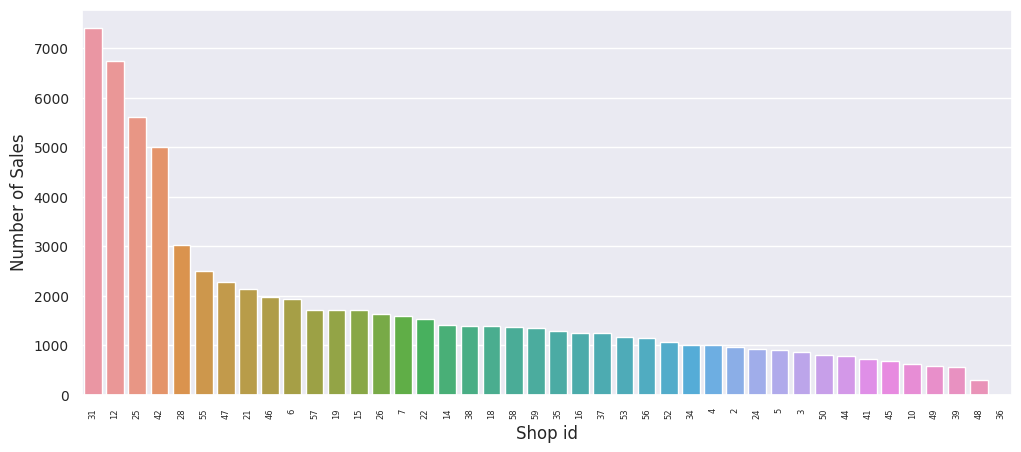

In [347]:
bar_plot_func(pred_shops_id_sales_local_df, "Shop id", "Number of Sales")

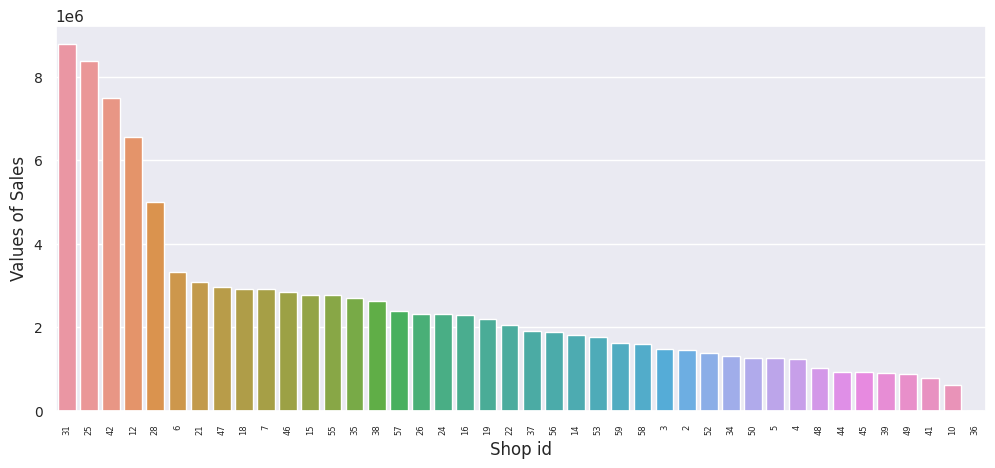

In [227]:
bar_plot_func(pred_shops_id_values_df, "Shop id", "Values of Sales")

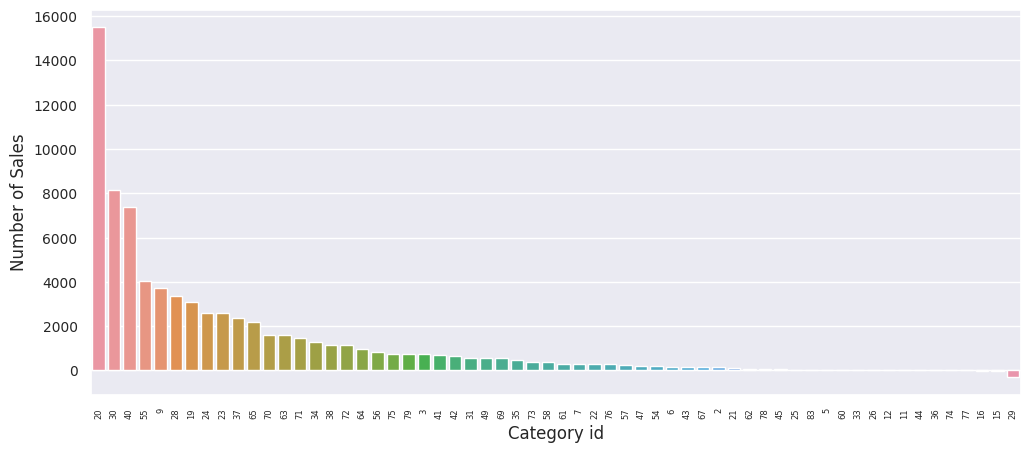

In [229]:
bar_plot_func(pred_cats_id_sales_local_df, "Category id", "Number of Sales")

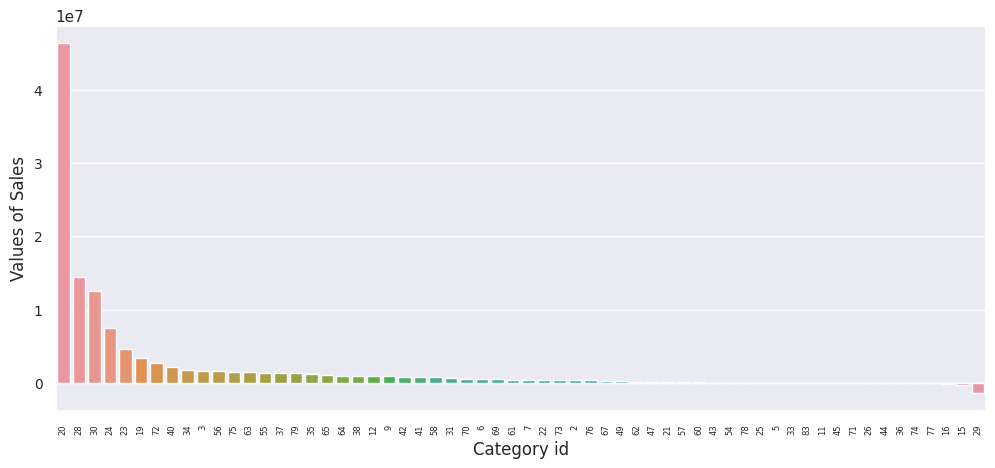

In [230]:
bar_plot_func(pred_cats_id_values_df, "Category id", "Values of Sales")

## Merge with test\_df

In [280]:
test_local_df = test_local_df.astype({
    'shop_id': 'int32',
    'item_id': 'int32',
    'cat_id': 'int32'
})
test_local_df.dtypes

ID         int64
shop_id    int32
item_id    int32
cat_id     int32
dtype: object

In [281]:
final_df = test_local_df.copy()
final_df = final_df.merge(shops_pred, how='left', on='shop_id')
final_df = final_df.merge(cat_pred, how='left', on='cat_id')
final_df = final_df.merge(items_pred, how='left', on='item_id')
final_df = final_df.merge(cats_shops_pred, how='left', on=['shop_id', 'cat_id'])
final_df.fillna(0, inplace=True)

In [282]:
final_df

ID  shop_id  item_id  cat_id  shops_n_sales  cats_n_sales  \
0            0        5     5037      19         900.64       3075.13   
1            1        5     5320      55         900.64       4026.82   
2            2        5     5233      19         900.64       3075.13   
3            3        5     5232      23         900.64       2571.63   
4            4        5     5268      20         900.64      15513.49   
...        ...      ...      ...     ...            ...           ...   
214195  214195       45    18454      55         684.27       4026.82   
214196  214196       45    16188      64         684.27        940.69   
214197  214197       45    15757      55         684.27       4026.82   
214198  214198       45    19648      40         684.27       7389.52   
214199  214199       45      969      37         684.27       2369.53   

        items_n_sales  cat_shops_n_sales  
0               32.97              54.79  
1                0.00              83.60  
2               69.27              54.79  
3                0.00              58.25  
4                0.00             125.89  
...               ...                ...  
214195          -1.91              76.22  
214196           0.00              15.39  
214197          10.24              76.22  
214198           1.10              57.71  
214199          -2.19              34.47  

[214200 rows x 8 columns]

In [283]:
final_df.to_csv('../raw_data/prophet/final.csv')

In [284]:
test_local_df

ID  shop_id  item_id  cat_id
0            0        5     5037      19
1            1        5     5320      55
2            2        5     5233      19
3            3        5     5232      23
4            4        5     5268      20
...        ...      ...      ...     ...
214195  214195       45    18454      55
214196  214196       45    16188      64
214197  214197       45    15757      55
214198  214198       45    19648      40
214199  214199       45      969      37

[214200 rows x 4 columns]

In [285]:
sample_local_df

ID  item_cnt_month
0            0             0.5
1            1             0.5
2            2             0.5
3            3             0.5
4            4             0.5
...        ...             ...
214195  214195             0.5
214196  214196             0.5
214197  214197             0.5
214198  214198             0.5
214199  214199             0.5

[214200 rows x 2 columns]

## some test func

In [ ]:
from itertools import product, combinations

In [ ]:
def test_func_1(a1, a2, a3):
    print("===============")
    print(a1, a2, a3)

In [ ]:
yyy = list(combinations(df_id, 3))
yyy

In [ ]:
df_id = ["shop_id", "cat_id", "item_id", "cat_shop_id"]
feutures = ["item_cnt_day", "final_price"]
day = ["d", "w", "m"]
xxx = list(product(df_id, feutures, day))
xxx

In [ ]:
"shop_id"[:-3]

In [ ]:
"_".join(["shop_id", "item_cnt_day", "d", "ver01"])

In [ ]:
list(map(test_func_1, (1,2,3),(4,5,6),(7,8,9)))

# Data Old and What?

## one

In [ ]:
shops_cats_sales = pd.pivot_table(
    sales_local_df, values='item_cnt_day',
    index=['shop_id', 'cat_id'], columns=['date'],
    aggfunc=np.sum 
)
shops_cats_sales.fillna(0, inplace=True)
#shops_cats_sales.reset_index(inplace=True)

In [ ]:
shops_cats_sales.T

In [ ]:
shops_sales

In [ ]:
shops_items_sales = pd.pivot_table(
    sales_local_df, values='item_cnt_day',
    index=['shop_id', 'item_id'], columns=['date_block_num'],
    aggfunc=np.sum 
)
shops_items_sales.fillna(0, inplace=True)
#shops_items_sales.reset_index(inplace=True)

In [ ]:
shops_items_sales

In [ ]:
shops_sales_month['final_id'] = shops_sales_month['shop_id'].astype(str) + "-" + shops_sales_month['item_id'].astype(str)
shops_sales_month.set_index('final_id', inplace=True)
shops_sales_month.drop(columns=['shop_id', 'item_id'], inplace=True)
shops_sales_month = shops_sales_month.T

In [ ]:
shops_sales_month

In [ ]:
plot_cols = ['0-32', '0-49', '59-22144', '59-22167']
plot_features = shops_sales_month[plot_cols]
plot_features.index = shops_sales_month.index
plot_features.plot(subplots = True);

## two

In [ ]:
sales_local_df[sales_local_df['shop_id'] == 10].sort_values("date").groupby(by='date').sum('item_cnt_day')

In [ ]:
shop_sales_month =pd.DataFrame({"date_block_num": range(34)})
type(shop_sales_month)

In [ ]:
total_month_dict = {}
for id in range(shops_local_df.shape[0]):
    shop_id = f"shop_id_{id}"
    df = sales_local_df[sales_local_df['shop_id'] == id].groupby(by='date_block_num').sum('item_cnt_day')
    total_month_dict[shop_id] = df.shape[0]
    shop_sales_month[shop_id] = df.item_cnt_day
shop_sales_month.fillna(0, inplace=True)
shop_sales_month.drop(columns=['date_block_num'], inplace=True)

In [ ]:
shop_sales_month

In [ ]:
closed_shops = shop_sales_month.iloc[31:34]
closed_shops = pd.DataFrame(shop_sales_month.iloc[31:34].sum()).T
closed_shops

In [ ]:
pd.DataFrame(shop_sales_month.iloc[31:34].sum()).head(60)

In [ ]:
plt.plot(shop_sales_month.shop_id_0)
plt.plot(shop_sales_month.shop_id_1)
plt.plot(shop_sales_month.shop_id_8)
plt.plot(shop_sales_month.shop_id_9)

plt.plot(shop_sales_month.shop_id_11)
plt.plot(shop_sales_month.shop_id_13)
plt.plot(shop_sales_month.shop_id_17)
plt.plot(shop_sales_month.shop_id_20)
plt.plot(shop_sales_month.shop_id_23)
plt.plot(shop_sales_month.shop_id_27)

plt.plot(shop_sales_month.shop_id_29)
plt.plot(shop_sales_month.shop_id_30)
plt.plot(shop_sales_month.shop_id_32)
plt.plot(shop_sales_month.shop_id_33)
plt.plot(shop_sales_month.shop_id_40)
plt.plot(shop_sales_month.shop_id_27)


plt.plot(shop_sales_month.shop_id_43)
plt.plot(shop_sales_month.shop_id_51)
plt.plot(shop_sales_month.shop_id_54)
plt.plot(range(34))

In [ ]:
plt.plot(shop_sales_month.shop_id_27)
#plt.plot(shop_sales_month.shop_id_41)
#plt.plot(shop_sales_month.shop_id_42)
#plt.plot(shop_sales_month.shop_id_43)
#plt.plot(shop_sales_month.shop_id_44)
#plt.plot(shop_sales_month.shop_id_45)
#plt.plot(shop_sales_month.shop_id_46)

In [ ]:
sns.displot(total_month_dict, bins=34)
plt.xlim(1, 35, )

In [ ]:
total_month_dict

In [ ]:
open_shops